## Importing Required Libraries

In [8]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np
from PIL import Image

%matplotlib inline

np.random.seed(0)

In [9]:
# raw data location
data_path = 'visapy_data.npy'

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

## Spike Detection

In [11]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [12]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)
H.DetectFromRaw()
H.LoadDetected()

File size: 122400102
Number of channels: 102
# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059

In [13]:
#H.spikes

In [14]:
somapos = np.loadtxt('ViSAPy_somapos.gdf')
ground_truth = np.loadtxt('ViSAPy_ground_truth.gdf')

In [15]:
ground_truth = ground_truth.astype(int)
somapos = np.array([somapos[:,0], somapos[:,1]])

In [16]:
print(ground_truth.shape)
print(somapos.shape)

(64441, 2)
(2, 56)


## Listing down all event frames

##### There are 102 channels which have recorded 1200001 data points each. Hence we have 1200001 frames to assess

In [17]:
data = np.load('visapy_data.npy')
# i = 101
# print(data[i*1200001: (i+1)*1200001])

In [18]:
frame_set = data.reshape((1200001,102))
print("Frame shape: ", frame_set.shape)
print("Whole Dataset: ", frame_set)

Frame shape:  (1200001, 102)
Whole Dataset:  [[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


##### Finding electrode positions

In [19]:
x_path = 'z_integer.npy'
y_path = 'y_integer.npy'
elec_x_int = np.load(x_path)
elec_y_int = np.load(y_path)

In [20]:
ky = 9 / np.max(np.diff(sorted(elec_y_int)))
elec_x = elec_x_int * ky
elec_y = elec_y_int * ky
elec_x -= np.min(elec_x)
elec_y -= np.min(elec_y)

In [21]:
datapoints = []
for i in range(len(elec_x)):
    datapoints.append([elec_x[i], elec_y[i]])
datapoints = np.asarray(datapoints)
print(datapoints)

[[ 59.54058193 179.98346095]
 [  0.         233.97886677]
 [ 74.42572741 242.97794793]
 [ 59.54058193  17.99816233]
 [ 29.77029096  35.99632466]
 [ 59.54058193 143.98621746]
 [ 44.65543645 242.97794793]
 [ 14.88514548 296.97243492]
 [ 74.42572741  44.99540582]
 [  0.         107.9898928 ]
 [ 29.77029096 143.98621746]
 [  0.          17.99816233]
 [ 59.54058193  53.99448698]
 [ 44.65543645  80.99264931]
 [ 74.42572741 170.98437979]
 [ 44.65543645 206.98070444]
 [  0.         197.98162328]
 [ 14.88514548 278.97427259]
 [ 44.65543645 296.97243492]
 [ 14.88514548  44.99540582]
 [ 59.54058193  89.99173047]
 [  0.         215.9797856 ]
 [ 74.42572741 278.97427259]
 [ 14.88514548  26.99724349]
 [ 44.65543645  44.99540582]
 [ 44.65543645  98.99081164]
 [ 74.42572741 152.98621746]
 [ 29.77029096   0.        ]
 [ 74.42572741  26.99724349]
 [  0.          53.99448698]
 [ 44.65543645 134.98713629]
 [ 44.65543645  62.99356815]
 [ 59.54058193 287.97335375]
 [ 59.54058193 215.9797856 ]
 [ 59.54058193

In [22]:
list_times = H.spikes['t'].tolist()
# list_times = np.asarray(list_times) - 1
list_ch = H.spikes['ch'].tolist()

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

print(len(x), len(list_times))

# A list of all time and channel combinations which have spikes
list_times_ch = []
for i in range(len(list_times)):
    list_times_ch.append((list_times[i], list_ch[i]))

19341 19341


## Loading the image files into dictionary with time and channel as key

In [23]:
import cv2
import copy

In [24]:
image_data = {}

for i in range(len(list_times)):
    filename = "frames_small_attention/frame_"+str(list_times[i])+"_"+str(list_ch[i])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    image_data[(list_times[i], list_ch[i])] = temp_pic

In [272]:
location = {}

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

for i in range(len(list_times)):
    location[(list_times[i], list_ch[i])] = (x[i], y[i])

### Splitting in Train-Test Data

In [273]:
train_lim = (int)(0.7*len(list_times_ch))
val_lim = (int)(0.8*len(list_times_ch))

list_times_ch_train = list_times_ch[:train_lim]
list_times_ch_val = list_times_ch[train_lim:val_lim]
list_times_ch_test = list_times_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

13538 1934 3869


# Designing the model

In [274]:
#torch.cuda.set_device(1)

class LocatorCNN(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.Tanh()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(33, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

### Training the Network

In [278]:
import random
random.seed(0)

def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss = criterion(out, loc)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss = criterion(val_out, v_loc)
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return out, losses, val_losses

In [279]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

## With Maxpooling

In [280]:
epoch_range = 5000
batch_size = 100
learning_rate = 0.0001

cnn_1 = LocatorCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:18653.59375, val:19196.03906
epoch [2/5000], loss:18497.09570, val:19088.66602
epoch [3/5000], loss:18394.55664, val:19005.01172
epoch [4/5000], loss:18306.87500, val:18924.77930
epoch [5/5000], loss:18229.35742, val:18826.73633
epoch [6/5000], loss:18137.57812, val:18737.27539
epoch [7/5000], loss:18041.24023, val:18628.21094
epoch [8/5000], loss:17937.98828, val:18507.93359
epoch [9/5000], loss:17817.62695, val:18389.02930
epoch [10/5000], loss:17684.05859, val:18218.91211
epoch [11/5000], loss:17517.71484, val:18043.36328
epoch [12/5000], loss:17373.95703, val:17883.97461
epoch [13/5000], loss:17185.07031, val:17656.00977
epoch [14/5000], loss:16983.75195, val:17433.92188
epoch [15/5000], loss:16764.50195, val:17136.39453
epoch [16/5000], loss:16478.76562, val:16817.38477
epoch [17/5000], loss:16193.12207, val:16489.29297
epoch [18/5000], loss:15865.56348, val:16119.88379
epoch [19/5000], loss:15463.60840, val:15762.49023
epoch [20/5000], loss:15091.06348, val:1

epoch [166/5000], loss:3951.55005, val:4459.20020
epoch [167/5000], loss:3825.23975, val:4443.63623
epoch [168/5000], loss:3944.36963, val:4594.26562
epoch [169/5000], loss:4098.75732, val:4306.66357
epoch [170/5000], loss:3972.96729, val:4165.08789
epoch [171/5000], loss:4148.10303, val:4220.94629
epoch [172/5000], loss:3966.60718, val:4389.95752
epoch [173/5000], loss:3847.12817, val:4069.23364
epoch [174/5000], loss:3963.69653, val:4260.56836
epoch [175/5000], loss:3933.88354, val:3948.61597
epoch [176/5000], loss:3931.14624, val:4306.90869
epoch [177/5000], loss:3918.77490, val:4319.81299
epoch [178/5000], loss:3891.59058, val:4248.82764
epoch [179/5000], loss:3896.15747, val:4168.41309
epoch [180/5000], loss:4016.51318, val:4252.85010
epoch [181/5000], loss:4092.09399, val:4131.22559
epoch [182/5000], loss:3915.51343, val:4223.80664
epoch [183/5000], loss:3843.30957, val:4171.32471
epoch [184/5000], loss:3944.60522, val:4151.74902
epoch [185/5000], loss:3947.99561, val:4290.83936


epoch [331/5000], loss:4056.17261, val:4232.94580
epoch [332/5000], loss:4062.43945, val:4290.17529
epoch [333/5000], loss:3855.47729, val:4346.25098
epoch [334/5000], loss:3835.27808, val:4465.35449
epoch [335/5000], loss:3900.02930, val:4212.53125
epoch [336/5000], loss:3871.83154, val:4315.38379
epoch [337/5000], loss:4023.37720, val:4248.93604
epoch [338/5000], loss:3851.71851, val:4380.97705
epoch [339/5000], loss:3867.65210, val:4187.82031
epoch [340/5000], loss:3956.72778, val:4204.10059
epoch [341/5000], loss:3974.16064, val:4258.81689
epoch [342/5000], loss:3858.49512, val:4418.93115
epoch [343/5000], loss:3866.77490, val:4267.75537
epoch [344/5000], loss:3868.53931, val:4422.33252
epoch [345/5000], loss:3773.66528, val:4311.12744
epoch [346/5000], loss:3881.11792, val:4259.71533
epoch [347/5000], loss:3894.80151, val:4222.21924
epoch [348/5000], loss:3994.49683, val:4056.71777
epoch [349/5000], loss:4100.36328, val:4268.65234
epoch [350/5000], loss:3986.19336, val:4245.41113


epoch [496/5000], loss:3780.15918, val:4216.30371
epoch [497/5000], loss:3825.33496, val:4246.54883
epoch [498/5000], loss:3895.93823, val:4296.42676
epoch [499/5000], loss:3987.75244, val:4115.16846
epoch [500/5000], loss:3858.09009, val:4542.40186
epoch [501/5000], loss:3815.32910, val:4104.21289
epoch [502/5000], loss:3860.16846, val:4316.23682
epoch [503/5000], loss:3768.67090, val:3885.80054
epoch [504/5000], loss:3811.64136, val:4193.79639
epoch [505/5000], loss:3744.60254, val:4341.78564
epoch [506/5000], loss:3825.06152, val:4208.49854
epoch [507/5000], loss:3812.65552, val:4314.37402
epoch [508/5000], loss:3730.32031, val:4210.02637
epoch [509/5000], loss:3813.43604, val:4028.52808
epoch [510/5000], loss:3766.48242, val:4214.89209
epoch [511/5000], loss:3810.58716, val:4308.93604
epoch [512/5000], loss:3832.52124, val:4110.09473
epoch [513/5000], loss:3798.76001, val:4117.90820
epoch [514/5000], loss:3955.19189, val:4079.46216
epoch [515/5000], loss:3727.59790, val:4162.68018


epoch [664/5000], loss:165.01018, val:235.00345
epoch [665/5000], loss:138.53577, val:136.00612
epoch [666/5000], loss:128.77098, val:224.09306
epoch [667/5000], loss:141.39696, val:127.18522
epoch [668/5000], loss:152.82889, val:228.20491
epoch [669/5000], loss:144.95941, val:160.33789
epoch [670/5000], loss:132.95566, val:200.02341
epoch [671/5000], loss:142.75929, val:257.93469
epoch [672/5000], loss:135.53802, val:244.21370
epoch [673/5000], loss:126.59071, val:228.15102
epoch [674/5000], loss:130.83002, val:241.27306
epoch [675/5000], loss:163.70782, val:128.87286
epoch [676/5000], loss:119.64293, val:199.91202
epoch [677/5000], loss:137.09792, val:127.52364
epoch [678/5000], loss:158.15569, val:183.03171
epoch [679/5000], loss:144.53052, val:227.67708
epoch [680/5000], loss:130.32394, val:225.84103
epoch [681/5000], loss:148.85811, val:153.84741
epoch [682/5000], loss:135.91338, val:219.69724
epoch [683/5000], loss:129.61690, val:155.76910
epoch [684/5000], loss:118.66238, val:13

epoch [838/5000], loss:90.54363, val:180.75235
epoch [839/5000], loss:88.88774, val:127.03876
epoch [840/5000], loss:85.76067, val:147.80159
epoch [841/5000], loss:101.25052, val:158.89345
epoch [842/5000], loss:79.77261, val:160.36739
epoch [843/5000], loss:75.93444, val:116.06664
epoch [844/5000], loss:94.30047, val:119.76953
epoch [845/5000], loss:83.12905, val:124.02433
epoch [846/5000], loss:92.90420, val:166.64946
epoch [847/5000], loss:78.10011, val:162.00790
epoch [848/5000], loss:92.78206, val:106.11246
epoch [849/5000], loss:80.02745, val:131.53062
epoch [850/5000], loss:83.02976, val:118.67641
epoch [851/5000], loss:88.50939, val:128.17700
epoch [852/5000], loss:86.45553, val:80.18233
epoch [853/5000], loss:74.50503, val:150.70403
epoch [854/5000], loss:79.44160, val:114.71110
epoch [855/5000], loss:83.20575, val:150.44991
epoch [856/5000], loss:78.27612, val:118.86315
epoch [857/5000], loss:90.26075, val:142.77631
epoch [858/5000], loss:91.70943, val:173.94841
epoch [859/50

epoch [1015/5000], loss:69.85915, val:88.62002
epoch [1016/5000], loss:69.63549, val:118.75591
epoch [1017/5000], loss:53.43243, val:96.94501
epoch [1018/5000], loss:79.30099, val:94.29933
epoch [1019/5000], loss:62.67599, val:116.56740
epoch [1020/5000], loss:63.31153, val:95.48009
epoch [1021/5000], loss:68.16801, val:79.16540
epoch [1022/5000], loss:56.79306, val:108.35081
epoch [1023/5000], loss:60.84298, val:117.07641
epoch [1024/5000], loss:56.82784, val:123.78224
epoch [1025/5000], loss:70.63401, val:115.48392
epoch [1026/5000], loss:58.39780, val:133.59230
epoch [1027/5000], loss:56.68651, val:156.53145
epoch [1028/5000], loss:54.79237, val:149.60036
epoch [1029/5000], loss:61.21907, val:142.46681
epoch [1030/5000], loss:55.85764, val:117.44165
epoch [1031/5000], loss:62.13276, val:129.49782
epoch [1032/5000], loss:71.84102, val:127.53265
epoch [1033/5000], loss:66.51955, val:111.62572
epoch [1034/5000], loss:80.26283, val:121.59934
epoch [1035/5000], loss:76.60971, val:146.300

epoch [1189/5000], loss:47.93294, val:90.27164
epoch [1190/5000], loss:63.54933, val:103.06596
epoch [1191/5000], loss:69.57797, val:151.18340
epoch [1192/5000], loss:49.22421, val:93.76916
epoch [1193/5000], loss:46.75742, val:112.76325
epoch [1194/5000], loss:54.97496, val:117.08467
epoch [1195/5000], loss:58.53474, val:123.09715
epoch [1196/5000], loss:70.90205, val:153.64169
epoch [1197/5000], loss:54.55840, val:106.91043
epoch [1198/5000], loss:68.12832, val:100.89442
epoch [1199/5000], loss:50.95388, val:91.40237
epoch [1200/5000], loss:62.40480, val:169.50456
epoch [1201/5000], loss:52.94038, val:123.87844
epoch [1202/5000], loss:64.61848, val:113.74723
epoch [1203/5000], loss:56.31177, val:87.18650
epoch [1204/5000], loss:51.56650, val:146.63945
epoch [1205/5000], loss:50.58885, val:94.38201
epoch [1206/5000], loss:57.28135, val:132.51517
epoch [1207/5000], loss:56.94670, val:124.48827
epoch [1208/5000], loss:74.09760, val:120.99352
epoch [1209/5000], loss:51.16079, val:113.722

epoch [1363/5000], loss:62.33085, val:81.53366
epoch [1364/5000], loss:44.74886, val:98.90023
epoch [1365/5000], loss:51.33485, val:120.29729
epoch [1366/5000], loss:45.14267, val:104.49612
epoch [1367/5000], loss:45.94136, val:122.28631
epoch [1368/5000], loss:43.22447, val:105.59660
epoch [1369/5000], loss:52.88073, val:102.86694
epoch [1370/5000], loss:50.42697, val:100.24844
epoch [1371/5000], loss:50.55761, val:98.66774
epoch [1372/5000], loss:46.63741, val:103.97600
epoch [1373/5000], loss:57.75402, val:109.70903
epoch [1374/5000], loss:45.99874, val:91.89484
epoch [1375/5000], loss:46.83212, val:124.13737
epoch [1376/5000], loss:58.15837, val:102.01629
epoch [1377/5000], loss:49.71878, val:119.96740
epoch [1378/5000], loss:49.01759, val:101.17786
epoch [1379/5000], loss:51.64954, val:109.35620
epoch [1380/5000], loss:45.97467, val:102.12936
epoch [1381/5000], loss:40.24933, val:95.03830
epoch [1382/5000], loss:41.34110, val:147.67076
epoch [1383/5000], loss:54.61339, val:106.495

epoch [1537/5000], loss:42.69191, val:114.99676
epoch [1538/5000], loss:39.55788, val:66.56880
epoch [1539/5000], loss:45.41975, val:108.66888
epoch [1540/5000], loss:46.81180, val:119.65901
epoch [1541/5000], loss:34.34715, val:119.04555
epoch [1542/5000], loss:48.48354, val:93.22049
epoch [1543/5000], loss:46.46723, val:56.37009
epoch [1544/5000], loss:39.69294, val:101.08766
epoch [1545/5000], loss:31.91157, val:68.93156
epoch [1546/5000], loss:31.49320, val:120.14733
epoch [1547/5000], loss:35.89119, val:73.83372
epoch [1548/5000], loss:45.78356, val:128.26201
epoch [1549/5000], loss:49.50082, val:111.13721
epoch [1550/5000], loss:41.30070, val:125.61111
epoch [1551/5000], loss:45.35766, val:84.34661
epoch [1552/5000], loss:45.20581, val:91.37459
epoch [1553/5000], loss:33.56390, val:140.21539
epoch [1554/5000], loss:33.12648, val:161.98531
epoch [1555/5000], loss:28.65565, val:105.13895
epoch [1556/5000], loss:42.87445, val:91.42554
epoch [1557/5000], loss:44.83374, val:118.86253


epoch [1711/5000], loss:32.02441, val:89.61307
epoch [1712/5000], loss:41.44344, val:103.00667
epoch [1713/5000], loss:36.22425, val:88.26290
epoch [1714/5000], loss:32.01186, val:123.44498
epoch [1715/5000], loss:32.46215, val:125.65537
epoch [1716/5000], loss:36.93514, val:119.59305
epoch [1717/5000], loss:34.33286, val:102.16912
epoch [1718/5000], loss:42.98790, val:144.70193
epoch [1719/5000], loss:30.14255, val:91.01765
epoch [1720/5000], loss:36.91433, val:113.12009
epoch [1721/5000], loss:31.08000, val:100.86266
epoch [1722/5000], loss:31.20425, val:87.56120
epoch [1723/5000], loss:36.51191, val:88.64181
epoch [1724/5000], loss:32.44776, val:100.31719
epoch [1725/5000], loss:35.09206, val:119.70763
epoch [1726/5000], loss:30.21386, val:99.05367
epoch [1727/5000], loss:34.94347, val:115.61399
epoch [1728/5000], loss:31.62927, val:132.42624
epoch [1729/5000], loss:31.34041, val:79.77479
epoch [1730/5000], loss:42.54638, val:102.78642
epoch [1731/5000], loss:43.16171, val:91.97005


epoch [1885/5000], loss:31.22142, val:88.57291
epoch [1886/5000], loss:39.77821, val:128.62946
epoch [1887/5000], loss:36.35700, val:97.25823
epoch [1888/5000], loss:34.44526, val:121.21574
epoch [1889/5000], loss:31.12954, val:80.40827
epoch [1890/5000], loss:43.39460, val:91.90550
epoch [1891/5000], loss:36.08473, val:84.07793
epoch [1892/5000], loss:38.06378, val:129.63307
epoch [1893/5000], loss:34.06622, val:105.16647
epoch [1894/5000], loss:24.57348, val:116.82677
epoch [1895/5000], loss:31.33679, val:108.60702
epoch [1896/5000], loss:39.51440, val:102.98898
epoch [1897/5000], loss:30.86987, val:131.31624
epoch [1898/5000], loss:35.77302, val:108.52835
epoch [1899/5000], loss:32.69896, val:72.94154
epoch [1900/5000], loss:29.09553, val:79.79520
epoch [1901/5000], loss:37.45192, val:94.85056
epoch [1902/5000], loss:27.40703, val:86.04044
epoch [1903/5000], loss:31.65249, val:78.06692
epoch [1904/5000], loss:33.92875, val:96.92290
epoch [1905/5000], loss:36.22063, val:98.22909
epoc

epoch [2059/5000], loss:32.77609, val:112.30650
epoch [2060/5000], loss:29.98466, val:99.16666
epoch [2061/5000], loss:30.89844, val:105.70371
epoch [2062/5000], loss:39.16954, val:107.50700
epoch [2063/5000], loss:37.04721, val:114.08961
epoch [2064/5000], loss:25.52952, val:116.96719
epoch [2065/5000], loss:31.45798, val:97.90808
epoch [2066/5000], loss:28.58866, val:87.66509
epoch [2067/5000], loss:35.82429, val:83.72099
epoch [2068/5000], loss:35.59232, val:96.40858
epoch [2069/5000], loss:42.90862, val:104.63848
epoch [2070/5000], loss:33.47066, val:85.25168
epoch [2071/5000], loss:32.99657, val:89.27206
epoch [2072/5000], loss:36.72775, val:99.84045
epoch [2073/5000], loss:28.27395, val:133.52679
epoch [2074/5000], loss:21.48557, val:91.98382
epoch [2075/5000], loss:31.68605, val:150.24678
epoch [2076/5000], loss:24.80724, val:119.73347
epoch [2077/5000], loss:45.19353, val:100.69505
epoch [2078/5000], loss:26.84912, val:94.64245
epoch [2079/5000], loss:26.60470, val:94.17510
epo

epoch [2233/5000], loss:26.34563, val:126.38662
epoch [2234/5000], loss:28.65820, val:99.04492
epoch [2235/5000], loss:30.29243, val:109.60530
epoch [2236/5000], loss:27.52203, val:97.67366
epoch [2237/5000], loss:29.18286, val:99.48327
epoch [2238/5000], loss:25.42446, val:104.26492
epoch [2239/5000], loss:33.28536, val:92.29795
epoch [2240/5000], loss:30.15235, val:89.34325
epoch [2241/5000], loss:29.74277, val:113.70538
epoch [2242/5000], loss:27.19386, val:106.85118
epoch [2243/5000], loss:26.39108, val:105.66069
epoch [2244/5000], loss:29.78613, val:98.93665
epoch [2245/5000], loss:27.31528, val:133.31180
epoch [2246/5000], loss:30.48433, val:113.76334
epoch [2247/5000], loss:23.78077, val:102.46403
epoch [2248/5000], loss:31.33269, val:109.72646
epoch [2249/5000], loss:34.26197, val:111.15952
epoch [2250/5000], loss:31.30704, val:83.01442
epoch [2251/5000], loss:21.35131, val:107.89587
epoch [2252/5000], loss:26.56259, val:120.89051
epoch [2253/5000], loss:27.57672, val:108.14561

epoch [2407/5000], loss:28.19187, val:112.15252
epoch [2408/5000], loss:27.94419, val:129.50327
epoch [2409/5000], loss:27.22667, val:98.00239
epoch [2410/5000], loss:25.13369, val:112.08540
epoch [2411/5000], loss:32.13884, val:93.66675
epoch [2412/5000], loss:32.78953, val:99.73631
epoch [2413/5000], loss:24.21531, val:92.37265
epoch [2414/5000], loss:21.37597, val:107.96571
epoch [2415/5000], loss:23.49849, val:105.95985
epoch [2416/5000], loss:32.01224, val:79.94665
epoch [2417/5000], loss:21.15494, val:122.53202
epoch [2418/5000], loss:30.60693, val:105.14332
epoch [2419/5000], loss:26.26851, val:85.91281
epoch [2420/5000], loss:19.15846, val:90.39949
epoch [2421/5000], loss:24.00907, val:98.70860
epoch [2422/5000], loss:27.39326, val:92.58450
epoch [2423/5000], loss:29.08028, val:86.60505
epoch [2424/5000], loss:28.25691, val:95.77347
epoch [2425/5000], loss:23.61575, val:114.59703
epoch [2426/5000], loss:39.25980, val:113.06795
epoch [2427/5000], loss:27.73147, val:134.52409
epo

epoch [2581/5000], loss:29.01037, val:106.22764
epoch [2582/5000], loss:23.03082, val:101.64674
epoch [2583/5000], loss:28.00959, val:148.49702
epoch [2584/5000], loss:26.96519, val:105.42451
epoch [2585/5000], loss:27.53697, val:106.13389
epoch [2586/5000], loss:27.41580, val:78.28522
epoch [2587/5000], loss:25.85476, val:92.95783
epoch [2588/5000], loss:27.20564, val:92.94549
epoch [2589/5000], loss:26.33711, val:109.21001
epoch [2590/5000], loss:35.62539, val:138.56805
epoch [2591/5000], loss:34.40368, val:112.40960
epoch [2592/5000], loss:31.53778, val:97.76971
epoch [2593/5000], loss:25.72355, val:118.15308
epoch [2594/5000], loss:19.54043, val:86.31369
epoch [2595/5000], loss:22.40606, val:78.94790
epoch [2596/5000], loss:25.06543, val:89.19243
epoch [2597/5000], loss:21.88109, val:112.71691
epoch [2598/5000], loss:29.36113, val:96.52049
epoch [2599/5000], loss:23.82124, val:113.47767
epoch [2600/5000], loss:29.50178, val:82.70938
epoch [2601/5000], loss:22.49878, val:91.58871
ep

epoch [2755/5000], loss:26.41638, val:92.15195
epoch [2756/5000], loss:25.94517, val:86.23418
epoch [2757/5000], loss:26.84922, val:102.70390
epoch [2758/5000], loss:22.40680, val:137.50797
epoch [2759/5000], loss:29.05799, val:87.87476
epoch [2760/5000], loss:19.91676, val:134.30594
epoch [2761/5000], loss:25.73477, val:81.49170
epoch [2762/5000], loss:23.69686, val:102.47218
epoch [2763/5000], loss:30.39959, val:118.55544
epoch [2764/5000], loss:23.80548, val:107.55241
epoch [2765/5000], loss:22.23146, val:82.43289
epoch [2766/5000], loss:25.97767, val:98.86094
epoch [2767/5000], loss:27.78443, val:92.72991
epoch [2768/5000], loss:25.99189, val:79.66444
epoch [2769/5000], loss:24.13247, val:105.74593
epoch [2770/5000], loss:26.73045, val:126.91685
epoch [2771/5000], loss:24.61139, val:121.59248
epoch [2772/5000], loss:30.80696, val:108.73908
epoch [2773/5000], loss:18.90281, val:85.42106
epoch [2774/5000], loss:21.10978, val:103.33041
epoch [2775/5000], loss:26.34849, val:97.67351
ep

epoch [2929/5000], loss:21.17853, val:81.89455
epoch [2930/5000], loss:26.34770, val:115.18443
epoch [2931/5000], loss:22.94577, val:148.39812
epoch [2932/5000], loss:28.01144, val:118.65451
epoch [2933/5000], loss:27.43437, val:101.18587
epoch [2934/5000], loss:29.94407, val:100.00581
epoch [2935/5000], loss:24.40572, val:111.81820
epoch [2936/5000], loss:30.72295, val:87.98630
epoch [2937/5000], loss:27.28723, val:124.68716
epoch [2938/5000], loss:22.35614, val:126.75258
epoch [2939/5000], loss:19.92669, val:114.43263
epoch [2940/5000], loss:34.42974, val:98.10770
epoch [2941/5000], loss:22.16274, val:98.25478
epoch [2942/5000], loss:26.19538, val:81.30062
epoch [2943/5000], loss:30.70674, val:78.56820
epoch [2944/5000], loss:23.11997, val:124.22704
epoch [2945/5000], loss:20.15847, val:130.19868
epoch [2946/5000], loss:29.94643, val:147.89616
epoch [2947/5000], loss:27.42929, val:119.57523
epoch [2948/5000], loss:26.24606, val:105.64118
epoch [2949/5000], loss:26.15801, val:102.0375

epoch [3103/5000], loss:21.96178, val:73.97481
epoch [3104/5000], loss:24.41798, val:91.18922
epoch [3105/5000], loss:19.64184, val:113.09260
epoch [3106/5000], loss:20.86934, val:105.23097
epoch [3107/5000], loss:22.26339, val:110.93948
epoch [3108/5000], loss:22.74413, val:110.79290
epoch [3109/5000], loss:17.85974, val:102.70110
epoch [3110/5000], loss:26.11616, val:78.07970
epoch [3111/5000], loss:18.24862, val:104.33242
epoch [3112/5000], loss:22.04516, val:108.50294
epoch [3113/5000], loss:23.56269, val:83.93045
epoch [3114/5000], loss:17.80536, val:95.14517
epoch [3115/5000], loss:23.36246, val:97.28610
epoch [3116/5000], loss:24.67152, val:95.77907
epoch [3117/5000], loss:19.94888, val:87.93417
epoch [3118/5000], loss:18.40516, val:109.17046
epoch [3119/5000], loss:24.59081, val:134.77289
epoch [3120/5000], loss:23.94475, val:86.37180
epoch [3121/5000], loss:24.65915, val:76.06478
epoch [3122/5000], loss:25.85397, val:94.17658
epoch [3123/5000], loss:23.36472, val:109.04772
epo

epoch [3277/5000], loss:20.20845, val:116.83567
epoch [3278/5000], loss:19.24132, val:108.30422
epoch [3279/5000], loss:20.76540, val:114.76870
epoch [3280/5000], loss:21.39942, val:111.27187
epoch [3281/5000], loss:18.49453, val:119.82874
epoch [3282/5000], loss:33.90486, val:105.46092
epoch [3283/5000], loss:22.63511, val:119.32294
epoch [3284/5000], loss:27.39546, val:94.79886
epoch [3285/5000], loss:16.96346, val:99.33076
epoch [3286/5000], loss:21.22490, val:104.52619
epoch [3287/5000], loss:20.00182, val:131.32320
epoch [3288/5000], loss:17.55103, val:96.14915
epoch [3289/5000], loss:24.18200, val:86.93206
epoch [3290/5000], loss:24.21196, val:92.44390
epoch [3291/5000], loss:21.90185, val:96.80446
epoch [3292/5000], loss:18.97408, val:101.27375
epoch [3293/5000], loss:20.85213, val:102.15625
epoch [3294/5000], loss:21.01037, val:123.15191
epoch [3295/5000], loss:26.82134, val:109.52447
epoch [3296/5000], loss:22.57499, val:85.99193
epoch [3297/5000], loss:22.74399, val:91.50639


epoch [3451/5000], loss:18.68756, val:90.66881
epoch [3452/5000], loss:29.23106, val:84.11349
epoch [3453/5000], loss:21.31942, val:83.56979
epoch [3454/5000], loss:24.07606, val:94.42703
epoch [3455/5000], loss:30.96713, val:95.92831
epoch [3456/5000], loss:18.07021, val:102.08138
epoch [3457/5000], loss:22.85872, val:120.67871
epoch [3458/5000], loss:24.73440, val:98.65565
epoch [3459/5000], loss:22.80799, val:114.64146
epoch [3460/5000], loss:26.29879, val:83.55965
epoch [3461/5000], loss:17.28871, val:90.63605
epoch [3462/5000], loss:20.61356, val:102.11024
epoch [3463/5000], loss:20.06890, val:91.90531
epoch [3464/5000], loss:18.15733, val:97.10296
epoch [3465/5000], loss:21.34457, val:86.94149
epoch [3466/5000], loss:20.23711, val:97.13833
epoch [3467/5000], loss:17.96926, val:96.32478
epoch [3468/5000], loss:32.93905, val:95.10991
epoch [3469/5000], loss:20.06761, val:89.05420
epoch [3470/5000], loss:22.20970, val:119.61776
epoch [3471/5000], loss:20.89532, val:115.05894
epoch [

epoch [3625/5000], loss:20.00475, val:134.67017
epoch [3626/5000], loss:23.92890, val:92.34652
epoch [3627/5000], loss:20.84529, val:92.50999
epoch [3628/5000], loss:27.39052, val:102.15205
epoch [3629/5000], loss:19.05880, val:96.79533
epoch [3630/5000], loss:21.58626, val:91.28471
epoch [3631/5000], loss:24.19497, val:78.06728
epoch [3632/5000], loss:16.79662, val:87.86199
epoch [3633/5000], loss:25.40648, val:91.12824
epoch [3634/5000], loss:19.41246, val:98.08009
epoch [3635/5000], loss:22.03723, val:86.89671
epoch [3636/5000], loss:23.48877, val:100.98418
epoch [3637/5000], loss:23.08463, val:110.07092
epoch [3638/5000], loss:25.36050, val:117.59647
epoch [3639/5000], loss:18.00915, val:103.88102
epoch [3640/5000], loss:22.64855, val:83.63421
epoch [3641/5000], loss:16.81084, val:77.89062
epoch [3642/5000], loss:20.84489, val:95.25218
epoch [3643/5000], loss:21.24537, val:94.83582
epoch [3644/5000], loss:24.08958, val:110.84962
epoch [3645/5000], loss:20.82174, val:89.07846
epoch 

epoch [3799/5000], loss:17.85758, val:87.55309
epoch [3800/5000], loss:23.08535, val:121.53165
epoch [3801/5000], loss:20.43621, val:114.37088
epoch [3802/5000], loss:21.39337, val:91.29522
epoch [3803/5000], loss:14.22420, val:118.89416
epoch [3804/5000], loss:21.72029, val:102.18586
epoch [3805/5000], loss:19.21465, val:97.77711
epoch [3806/5000], loss:19.40589, val:91.22815
epoch [3807/5000], loss:25.41373, val:134.60779
epoch [3808/5000], loss:22.86106, val:125.82579
epoch [3809/5000], loss:23.37727, val:109.05509
epoch [3810/5000], loss:19.40208, val:90.05713
epoch [3811/5000], loss:19.52495, val:78.63702
epoch [3812/5000], loss:21.32031, val:92.05977
epoch [3813/5000], loss:21.70469, val:122.33385
epoch [3814/5000], loss:23.34134, val:99.75990
epoch [3815/5000], loss:25.34509, val:80.30656
epoch [3816/5000], loss:28.32577, val:97.60685
epoch [3817/5000], loss:17.56544, val:92.25560
epoch [3818/5000], loss:16.94942, val:87.37516
epoch [3819/5000], loss:19.12362, val:95.42915
epoch

epoch [3973/5000], loss:14.87211, val:98.23288
epoch [3974/5000], loss:15.55229, val:89.74576
epoch [3975/5000], loss:19.67933, val:91.51359
epoch [3976/5000], loss:22.68394, val:77.83643
epoch [3977/5000], loss:15.18883, val:71.88575
epoch [3978/5000], loss:26.09188, val:93.02106
epoch [3979/5000], loss:15.60105, val:98.57298
epoch [3980/5000], loss:25.32468, val:92.61828
epoch [3981/5000], loss:22.54932, val:81.75768
epoch [3982/5000], loss:25.87812, val:90.81048
epoch [3983/5000], loss:17.02856, val:103.00919
epoch [3984/5000], loss:24.46052, val:86.58226
epoch [3985/5000], loss:21.71697, val:79.01418
epoch [3986/5000], loss:15.53847, val:76.10754
epoch [3987/5000], loss:18.47308, val:105.45199
epoch [3988/5000], loss:25.87122, val:135.96732
epoch [3989/5000], loss:16.53395, val:95.60738
epoch [3990/5000], loss:22.16855, val:91.02208
epoch [3991/5000], loss:19.65191, val:85.98763
epoch [3992/5000], loss:20.78875, val:84.83880
epoch [3993/5000], loss:19.45996, val:81.31467
epoch [399

epoch [4147/5000], loss:23.12185, val:76.48265
epoch [4148/5000], loss:19.66036, val:110.56649
epoch [4149/5000], loss:21.01609, val:94.43839
epoch [4150/5000], loss:18.02075, val:91.06841
epoch [4151/5000], loss:23.15604, val:91.91103
epoch [4152/5000], loss:20.16784, val:99.99122
epoch [4153/5000], loss:22.75665, val:105.57278
epoch [4154/5000], loss:18.31649, val:98.75861
epoch [4155/5000], loss:21.96323, val:94.21475
epoch [4156/5000], loss:19.68079, val:78.82240
epoch [4157/5000], loss:21.92305, val:96.52371
epoch [4158/5000], loss:23.89783, val:85.83718
epoch [4159/5000], loss:18.58729, val:106.67749
epoch [4160/5000], loss:24.35179, val:94.46323
epoch [4161/5000], loss:16.50361, val:93.33798
epoch [4162/5000], loss:20.50309, val:89.30863
epoch [4163/5000], loss:20.90699, val:95.07039
epoch [4164/5000], loss:15.02910, val:109.12645
epoch [4165/5000], loss:19.36652, val:107.62971
epoch [4166/5000], loss:21.50008, val:104.24336
epoch [4167/5000], loss:20.24403, val:93.62331
epoch [

epoch [4321/5000], loss:13.05717, val:110.97604
epoch [4322/5000], loss:19.47169, val:88.19807
epoch [4323/5000], loss:21.52271, val:116.22363
epoch [4324/5000], loss:17.20396, val:81.60262
epoch [4325/5000], loss:17.51752, val:94.72001
epoch [4326/5000], loss:17.15067, val:99.38989
epoch [4327/5000], loss:18.56006, val:131.06247
epoch [4328/5000], loss:29.33520, val:85.90141
epoch [4329/5000], loss:17.90429, val:76.80112
epoch [4330/5000], loss:19.42598, val:105.12111
epoch [4331/5000], loss:20.78381, val:95.49871
epoch [4332/5000], loss:21.34649, val:116.32016
epoch [4333/5000], loss:18.96864, val:100.57141
epoch [4334/5000], loss:17.68867, val:93.28255
epoch [4335/5000], loss:19.30242, val:87.78895
epoch [4336/5000], loss:22.76734, val:119.60546
epoch [4337/5000], loss:23.81986, val:85.75857
epoch [4338/5000], loss:17.88752, val:84.81161
epoch [4339/5000], loss:18.63575, val:107.67165
epoch [4340/5000], loss:24.38124, val:96.91980
epoch [4341/5000], loss:16.36035, val:116.34558
epoc

epoch [4495/5000], loss:19.22673, val:96.42793
epoch [4496/5000], loss:16.38024, val:93.62932
epoch [4497/5000], loss:17.57367, val:124.35863
epoch [4498/5000], loss:15.12665, val:103.58305
epoch [4499/5000], loss:16.42929, val:114.61805
epoch [4500/5000], loss:14.69813, val:101.68017
epoch [4501/5000], loss:19.54696, val:90.07808
epoch [4502/5000], loss:20.38340, val:107.59964
epoch [4503/5000], loss:19.77186, val:86.45853
epoch [4504/5000], loss:17.86392, val:98.47141
epoch [4505/5000], loss:18.46317, val:118.11299
epoch [4506/5000], loss:17.22905, val:83.90855
epoch [4507/5000], loss:21.23740, val:142.47812
epoch [4508/5000], loss:28.31266, val:111.94831
epoch [4509/5000], loss:28.61911, val:109.43353
epoch [4510/5000], loss:12.85602, val:94.34886
epoch [4511/5000], loss:21.48244, val:89.59342
epoch [4512/5000], loss:28.53577, val:116.78268
epoch [4513/5000], loss:18.82253, val:96.24332
epoch [4514/5000], loss:20.63744, val:100.97180
epoch [4515/5000], loss:18.76418, val:137.04567
e

epoch [4669/5000], loss:17.74717, val:117.22800
epoch [4670/5000], loss:23.22698, val:79.44252
epoch [4671/5000], loss:17.81905, val:98.77739
epoch [4672/5000], loss:17.97718, val:95.15554
epoch [4673/5000], loss:23.67011, val:87.92388
epoch [4674/5000], loss:19.96540, val:76.63707
epoch [4675/5000], loss:12.69522, val:107.83223
epoch [4676/5000], loss:15.90155, val:88.23307
epoch [4677/5000], loss:20.61233, val:118.10706
epoch [4678/5000], loss:20.28735, val:90.82644
epoch [4679/5000], loss:18.46262, val:89.57636
epoch [4680/5000], loss:21.42092, val:91.11429
epoch [4681/5000], loss:16.04199, val:89.51968
epoch [4682/5000], loss:16.73050, val:88.03085
epoch [4683/5000], loss:18.37336, val:137.30249
epoch [4684/5000], loss:19.91475, val:106.85622
epoch [4685/5000], loss:19.18698, val:92.41224
epoch [4686/5000], loss:16.65927, val:89.43922
epoch [4687/5000], loss:20.02977, val:82.61006
epoch [4688/5000], loss:22.82180, val:87.95432
epoch [4689/5000], loss:16.71836, val:103.42213
epoch [

epoch [4843/5000], loss:19.22080, val:71.54655
epoch [4844/5000], loss:19.85922, val:75.40957
epoch [4845/5000], loss:18.16693, val:89.88670
epoch [4846/5000], loss:14.31503, val:83.18056
epoch [4847/5000], loss:16.60278, val:124.88647
epoch [4848/5000], loss:27.67954, val:81.64222
epoch [4849/5000], loss:15.66772, val:96.19948
epoch [4850/5000], loss:14.37609, val:82.20787
epoch [4851/5000], loss:27.76872, val:107.55896
epoch [4852/5000], loss:16.84073, val:91.78284
epoch [4853/5000], loss:19.69012, val:85.64775
epoch [4854/5000], loss:17.43340, val:96.84300
epoch [4855/5000], loss:17.09081, val:94.92162
epoch [4856/5000], loss:16.16896, val:88.05786
epoch [4857/5000], loss:16.34304, val:84.81252
epoch [4858/5000], loss:16.00978, val:84.79695
epoch [4859/5000], loss:16.56254, val:85.23241
epoch [4860/5000], loss:12.64321, val:111.15786
epoch [4861/5000], loss:17.48256, val:96.00237
epoch [4862/5000], loss:14.25156, val:81.38913
epoch [4863/5000], loss:18.19411, val:83.30746
epoch [486

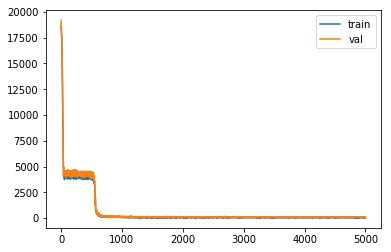

In [281]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

In [98]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

In [99]:
temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

{95: 198, 93: 150, 57: 244, 88: 39, 17: 125, 68: 130, 81: 95, 11: 46, 1: 181, 35: 166, 26: 96, 56: 31, 98: 52, 13: 166, 60: 145, 7: 109, 65: 85, 66: 131, 51: 32, 58: 226, 41: 95, 96: 55, 84: 153, 87: 16, 37: 71, 55: 7, 28: 36, 71: 85, 2: 7, 46: 148, 33: 47, 48: 82, 89: 67, 86: 30, 61: 9, 24: 7, 18: 44, 70: 4, 100: 9, 97: 33, 3: 2, 75: 27, 12: 7, 43: 4, 59: 13, 22: 22, 72: 104, 74: 11, 76: 2, 39: 28, 83: 32, 29: 9, 54: 2, 62: 58, 67: 1, 0: 3, 8: 1, 53: 53, 94: 5, 30: 2, 99: 8, 27: 1, 45: 7, 80: 3, 69: 1, 38: 1, 6: 3, 49: 2, 42: 1, 44: 1, 5: 1, 79: 1, 50: 1}
CNN:  [ 11.420702 233.58583 ] [ 5.048944 79.75802 ]
COM:  [ 11.55166298 233.10698895] [ 3.68241608 10.81483717]


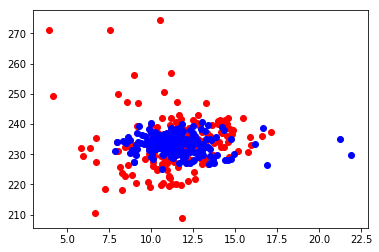

In [100]:
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

In [229]:
#torch.cuda.set_device(1)

class LocatorCNN_NC(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_NC, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.Tanh()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(32, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        #out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [104]:
epoch_range = 5000
batch_size = 100
learning_rate = 0.0001

cnn_1 = LocatorCNN_NC().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:18457.89062, avg:18457.89062
epoch [2/5000], loss:18352.01758, avg:18404.95312
epoch [3/5000], loss:18272.79492, avg:18360.90234
epoch [4/5000], loss:18205.53906, avg:18322.06055
epoch [5/5000], loss:18143.05664, avg:18286.25977
epoch [6/5000], loss:18083.28125, avg:18252.42969
epoch [7/5000], loss:18026.18164, avg:18220.10938
epoch [8/5000], loss:17966.89062, avg:18188.45703
epoch [9/5000], loss:17906.45508, avg:18157.12305
epoch [10/5000], loss:17840.97656, avg:18125.50977
epoch [11/5000], loss:17769.11133, avg:18056.63086
epoch [12/5000], loss:17681.55859, avg:17989.58398
epoch [13/5000], loss:17587.30664, avg:17921.03711
epoch [14/5000], loss:17475.74805, avg:17848.05664
epoch [15/5000], loss:17357.72070, avg:17769.52344
epoch [16/5000], loss:17218.02344, avg:17682.99805
epoch [17/5000], loss:17055.79688, avg:17585.95898
epoch [18/5000], loss:16890.56641, avg:17478.32617
epoch [19/5000], loss:16695.98438, avg:17357.27930
epoch [20/5000], loss:16491.38867, avg:1

epoch [166/5000], loss:3891.30127, avg:3944.76489
epoch [167/5000], loss:3980.45947, avg:3943.81714
epoch [168/5000], loss:3924.34229, avg:3947.34033
epoch [169/5000], loss:3980.63379, avg:3951.22705
epoch [170/5000], loss:3919.90210, avg:3946.45093
epoch [171/5000], loss:3924.33936, avg:3942.20581
epoch [172/5000], loss:3995.83569, avg:3943.85596
epoch [173/5000], loss:3910.74316, avg:3939.75366
epoch [174/5000], loss:3940.49194, avg:3939.38281
epoch [175/5000], loss:3916.62744, avg:3938.46802
epoch [176/5000], loss:3925.54932, avg:3941.89307
epoch [177/5000], loss:3960.26465, avg:3939.87305
epoch [178/5000], loss:3979.02832, avg:3945.34155
epoch [179/5000], loss:3949.39258, avg:3942.21729
epoch [180/5000], loss:3978.58447, avg:3948.08594
epoch [181/5000], loss:3917.16968, avg:3947.36841
epoch [182/5000], loss:3964.85620, avg:3944.27026
epoch [183/5000], loss:3953.58447, avg:3948.55518
epoch [184/5000], loss:3929.08032, avg:3947.41406
epoch [185/5000], loss:3939.53125, avg:3949.70386


epoch [331/5000], loss:3915.27563, avg:3936.31250
epoch [332/5000], loss:3931.56567, avg:3931.89819
epoch [333/5000], loss:3863.83911, avg:3918.77612
epoch [334/5000], loss:3952.67407, avg:3922.23560
epoch [335/5000], loss:3971.26221, avg:3928.68213
epoch [336/5000], loss:3983.87793, avg:3937.47900
epoch [337/5000], loss:3927.03564, avg:3936.10327
epoch [338/5000], loss:3920.34570, avg:3940.32812
epoch [339/5000], loss:3933.15308, avg:3936.32153
epoch [340/5000], loss:3886.95386, avg:3928.59839
epoch [341/5000], loss:3898.94873, avg:3926.96558
epoch [342/5000], loss:3945.40332, avg:3928.34937
epoch [343/5000], loss:3923.51123, avg:3934.31641
epoch [344/5000], loss:3938.57104, avg:3932.90625
epoch [345/5000], loss:3958.42676, avg:3931.62280
epoch [346/5000], loss:3983.93823, avg:3931.62866
epoch [347/5000], loss:3976.23657, avg:3936.54883
epoch [348/5000], loss:3878.39819, avg:3932.35425
epoch [349/5000], loss:3937.59961, avg:3932.79858
epoch [350/5000], loss:3962.83838, avg:3940.38721


epoch [496/5000], loss:3928.10034, avg:3950.57935
epoch [497/5000], loss:3956.65088, avg:3947.18481
epoch [498/5000], loss:3895.77417, avg:3941.77026
epoch [499/5000], loss:3934.93970, avg:3941.16333
epoch [500/5000], loss:3950.62695, avg:3938.18286
epoch [501/5000], loss:3914.82617, avg:3935.13843
epoch [502/5000], loss:3889.06958, avg:3929.16260
epoch [503/5000], loss:3945.07837, avg:3927.15210
epoch [504/5000], loss:3932.97290, avg:3929.96802
epoch [505/5000], loss:3936.88184, avg:3928.49219
epoch [506/5000], loss:3988.48926, avg:3934.53101
epoch [507/5000], loss:3907.40649, avg:3929.60620
epoch [508/5000], loss:3941.13037, avg:3934.14185
epoch [509/5000], loss:4006.69165, avg:3941.31714
epoch [510/5000], loss:3946.18384, avg:3940.87305
epoch [511/5000], loss:3905.27905, avg:3939.91846
epoch [512/5000], loss:3986.94678, avg:3949.70581
epoch [513/5000], loss:4000.05542, avg:3955.20361
epoch [514/5000], loss:3945.14600, avg:3956.42114
epoch [515/5000], loss:3934.36841, avg:3956.16968


epoch [661/5000], loss:3915.26318, avg:3923.28003
epoch [662/5000], loss:3900.68042, avg:3923.15405
epoch [663/5000], loss:3926.62036, avg:3922.40942
epoch [664/5000], loss:3900.30176, avg:3917.62573
epoch [665/5000], loss:3926.85815, avg:3919.44385
epoch [666/5000], loss:3882.45386, avg:3916.51562
epoch [667/5000], loss:3899.09521, avg:3914.77197
epoch [668/5000], loss:3935.68188, avg:3914.00244
epoch [669/5000], loss:3924.42529, avg:3914.24341
epoch [670/5000], loss:3957.22241, avg:3916.86011
epoch [671/5000], loss:3893.97217, avg:3914.73120
epoch [672/5000], loss:3955.86182, avg:3920.24976
epoch [673/5000], loss:3899.62378, avg:3917.55005
epoch [674/5000], loss:3900.57886, avg:3917.57739
epoch [675/5000], loss:3949.95947, avg:3919.88745
epoch [676/5000], loss:3983.17651, avg:3929.95972
epoch [677/5000], loss:3931.94897, avg:3933.24487
epoch [678/5000], loss:3921.24634, avg:3931.80127
epoch [679/5000], loss:3917.15039, avg:3931.07422
epoch [680/5000], loss:3922.94434, avg:3927.64624


epoch [826/5000], loss:3903.07959, avg:3926.77075
epoch [827/5000], loss:3934.69995, avg:3923.65674
epoch [828/5000], loss:3946.78247, avg:3930.00073
epoch [829/5000], loss:3930.55908, avg:3932.48364
epoch [830/5000], loss:3926.05542, avg:3932.14575
epoch [831/5000], loss:3900.44946, avg:3927.24292
epoch [832/5000], loss:3930.01367, avg:3933.94531
epoch [833/5000], loss:3925.46460, avg:3929.89331
epoch [834/5000], loss:3942.72510, avg:3930.12354
epoch [835/5000], loss:3927.98022, avg:3926.78101
epoch [836/5000], loss:3920.69556, avg:3928.54272
epoch [837/5000], loss:3929.57886, avg:3928.03052
epoch [838/5000], loss:3957.00977, avg:3929.05322
epoch [839/5000], loss:3933.90649, avg:3929.38794
epoch [840/5000], loss:3953.59033, avg:3932.14136
epoch [841/5000], loss:3930.53931, avg:3935.15039
epoch [842/5000], loss:3940.79468, avg:3936.22827
epoch [843/5000], loss:3986.82397, avg:3942.36401
epoch [844/5000], loss:3946.70850, avg:3942.76245
epoch [845/5000], loss:3938.34180, avg:3943.79932


epoch [991/5000], loss:3945.08228, avg:3939.93091
epoch [992/5000], loss:3945.37207, avg:3943.73047
epoch [993/5000], loss:3919.33521, avg:3938.66260
epoch [994/5000], loss:3931.68457, avg:3937.90503
epoch [995/5000], loss:3925.29980, avg:3936.35083
epoch [996/5000], loss:3944.53784, avg:3936.38916
epoch [997/5000], loss:3959.15747, avg:3939.57935
epoch [998/5000], loss:3904.18335, avg:3935.20679
epoch [999/5000], loss:3935.03760, avg:3934.25000
epoch [1000/5000], loss:3932.88135, avg:3934.25757
epoch [1001/5000], loss:3964.00659, avg:3936.14966
epoch [1002/5000], loss:3912.58716, avg:3932.87109
epoch [1003/5000], loss:3925.92627, avg:3933.53003
epoch [1004/5000], loss:3939.93188, avg:3934.35522
epoch [1005/5000], loss:3945.23779, avg:3936.34888
epoch [1006/5000], loss:3952.84229, avg:3937.17944
epoch [1007/5000], loss:3927.94531, avg:3934.05786
epoch [1008/5000], loss:3954.81909, avg:3939.12183
epoch [1009/5000], loss:4001.69751, avg:3945.78760
epoch [1010/5000], loss:3921.05933, avg:

epoch [1153/5000], loss:3940.49121, avg:3923.96021
epoch [1154/5000], loss:3926.64258, avg:3922.31714
epoch [1155/5000], loss:3967.65820, avg:3932.00781
epoch [1156/5000], loss:3942.76562, avg:3932.69409
epoch [1157/5000], loss:3952.02563, avg:3933.11182
epoch [1158/5000], loss:3931.11426, avg:3928.77661
epoch [1159/5000], loss:3927.60840, avg:3934.71069
epoch [1160/5000], loss:3926.17163, avg:3934.14429
epoch [1161/5000], loss:3941.38745, avg:3934.99927
epoch [1162/5000], loss:3944.57788, avg:3940.04468
epoch [1163/5000], loss:3985.94507, avg:3944.58984
epoch [1164/5000], loss:3906.77686, avg:3942.60327
epoch [1165/5000], loss:3907.99243, avg:3936.63647
epoch [1166/5000], loss:3963.51660, avg:3938.71167
epoch [1167/5000], loss:3914.80884, avg:3934.98999
epoch [1168/5000], loss:3955.30542, avg:3937.40894
epoch [1169/5000], loss:3901.78882, avg:3934.82690
epoch [1170/5000], loss:3967.20532, avg:3938.93042
epoch [1171/5000], loss:3939.76807, avg:3938.76880
epoch [1172/5000], loss:3959.67

epoch [1315/5000], loss:3948.77002, avg:3929.85278
epoch [1316/5000], loss:3925.31616, avg:3928.71729
epoch [1317/5000], loss:3893.61035, avg:3923.00366
epoch [1318/5000], loss:3938.76489, avg:3924.04956
epoch [1319/5000], loss:3910.99316, avg:3920.75977
epoch [1320/5000], loss:3947.71875, avg:3922.10010
epoch [1321/5000], loss:3939.35815, avg:3923.18018
epoch [1322/5000], loss:3922.94971, avg:3922.38745
epoch [1323/5000], loss:3936.58301, avg:3927.48901
epoch [1324/5000], loss:3878.25073, avg:3924.23120
epoch [1325/5000], loss:3969.41943, avg:3926.29614
epoch [1326/5000], loss:3954.97437, avg:3929.26172
epoch [1327/5000], loss:3909.73242, avg:3930.87427
epoch [1328/5000], loss:3925.43262, avg:3929.54102
epoch [1329/5000], loss:3923.44092, avg:3930.78638
epoch [1330/5000], loss:3946.02881, avg:3930.61694
epoch [1331/5000], loss:3924.32324, avg:3929.11377
epoch [1332/5000], loss:3879.38745, avg:3924.75757
epoch [1333/5000], loss:3898.66187, avg:3920.96484
epoch [1334/5000], loss:3967.86

epoch [1477/5000], loss:3363.98975, avg:3647.54028
epoch [1478/5000], loss:3256.71777, avg:3594.64233
epoch [1479/5000], loss:3069.05542, avg:3520.58057
epoch [1480/5000], loss:2862.13989, avg:3427.91919
epoch [1481/5000], loss:2747.15649, avg:3329.83643
epoch [1482/5000], loss:2511.36572, avg:3211.63306
epoch [1483/5000], loss:2344.65381, avg:3077.06836
epoch [1484/5000], loss:2152.76758, avg:2932.56714
epoch [1485/5000], loss:1847.95190, avg:2754.20679
epoch [1486/5000], loss:1544.49951, avg:2570.02979
epoch [1487/5000], loss:1667.27197, avg:2400.35815
epoch [1488/5000], loss:1148.68152, avg:2189.55444
epoch [1489/5000], loss:1237.94031, avg:2006.44275
epoch [1490/5000], loss:954.61664, avg:1815.69043
epoch [1491/5000], loss:784.16571, avg:1619.39148
epoch [1492/5000], loss:675.73444, avg:1435.82837
epoch [1493/5000], loss:700.94775, avg:1271.45764
epoch [1494/5000], loss:619.57391, avg:1118.13855
epoch [1495/5000], loss:565.22540, avg:989.86572
epoch [1496/5000], loss:533.45782, avg

epoch [1648/5000], loss:44.69436, avg:47.76392
epoch [1649/5000], loss:45.72587, avg:47.63146
epoch [1650/5000], loss:43.26114, avg:46.54526
epoch [1651/5000], loss:41.72691, avg:46.16174
epoch [1652/5000], loss:41.07339, avg:45.16575
epoch [1653/5000], loss:48.53125, avg:45.43321
epoch [1654/5000], loss:42.85696, avg:45.25234
epoch [1655/5000], loss:44.16428, avg:44.84606
epoch [1656/5000], loss:45.74801, avg:44.45921
epoch [1657/5000], loss:34.06991, avg:43.18521
epoch [1658/5000], loss:40.00274, avg:42.71605
epoch [1659/5000], loss:37.51904, avg:41.89537
epoch [1660/5000], loss:38.39087, avg:41.40834
epoch [1661/5000], loss:49.87684, avg:42.22333
epoch [1662/5000], loss:44.12664, avg:42.52866
epoch [1663/5000], loss:46.10426, avg:42.28595
epoch [1664/5000], loss:37.00211, avg:41.70047
epoch [1665/5000], loss:44.24424, avg:41.70847
epoch [1666/5000], loss:45.01746, avg:41.63541
epoch [1667/5000], loss:36.58818, avg:41.88724
epoch [1668/5000], loss:43.48434, avg:42.23540
epoch [1669/5

epoch [1825/5000], loss:31.92591, avg:29.49943
epoch [1826/5000], loss:34.91511, avg:30.32217
epoch [1827/5000], loss:32.85763, avg:29.93644
epoch [1828/5000], loss:27.23025, avg:29.83773
epoch [1829/5000], loss:30.15001, avg:29.92491
epoch [1830/5000], loss:28.99670, avg:30.05852
epoch [1831/5000], loss:28.44774, avg:29.98098
epoch [1832/5000], loss:29.14534, avg:30.11709
epoch [1833/5000], loss:35.46772, avg:30.96292
epoch [1834/5000], loss:25.73988, avg:30.48763
epoch [1835/5000], loss:24.84878, avg:29.77992
epoch [1836/5000], loss:26.80906, avg:28.96931
epoch [1837/5000], loss:29.29568, avg:28.61312
epoch [1838/5000], loss:31.29885, avg:29.01998
epoch [1839/5000], loss:34.54393, avg:29.45937
epoch [1840/5000], loss:28.58572, avg:29.41827
epoch [1841/5000], loss:29.58335, avg:29.53183
epoch [1842/5000], loss:31.71850, avg:29.78915
epoch [1843/5000], loss:25.67062, avg:28.80944
epoch [1844/5000], loss:26.79982, avg:28.91543
epoch [1845/5000], loss:30.03837, avg:29.43439
epoch [1846/5

epoch [2002/5000], loss:23.34777, avg:23.09498
epoch [2003/5000], loss:26.42470, avg:23.74984
epoch [2004/5000], loss:23.26945, avg:23.56708
epoch [2005/5000], loss:26.32954, avg:23.40644
epoch [2006/5000], loss:24.11129, avg:23.66639
epoch [2007/5000], loss:23.15483, avg:23.63416
epoch [2008/5000], loss:23.02683, avg:23.44449
epoch [2009/5000], loss:26.93723, avg:24.03838
epoch [2010/5000], loss:24.97357, avg:24.19623
epoch [2011/5000], loss:21.99806, avg:24.35733
epoch [2012/5000], loss:23.59304, avg:24.38186
epoch [2013/5000], loss:22.15384, avg:23.95477
epoch [2014/5000], loss:22.46961, avg:23.87479
epoch [2015/5000], loss:20.55434, avg:23.29726
epoch [2016/5000], loss:21.73218, avg:23.05935
epoch [2017/5000], loss:22.56045, avg:22.99992
epoch [2018/5000], loss:23.65645, avg:23.06288
epoch [2019/5000], loss:25.27741, avg:22.89689
epoch [2020/5000], loss:24.53200, avg:22.85274
epoch [2021/5000], loss:21.92790, avg:22.84572
epoch [2022/5000], loss:18.62799, avg:22.34922
epoch [2023/5

epoch [2179/5000], loss:17.64234, avg:17.79435
epoch [2180/5000], loss:18.14087, avg:17.69726
epoch [2181/5000], loss:16.90859, avg:17.32528
epoch [2182/5000], loss:17.03266, avg:17.61722
epoch [2183/5000], loss:18.33693, avg:17.78413
epoch [2184/5000], loss:17.50492, avg:17.84525
epoch [2185/5000], loss:13.78289, avg:17.33223
epoch [2186/5000], loss:16.58662, avg:17.35597
epoch [2187/5000], loss:22.31959, avg:17.73352
epoch [2188/5000], loss:18.69527, avg:17.69507
epoch [2189/5000], loss:13.47972, avg:17.27881
epoch [2190/5000], loss:16.97584, avg:17.16230
epoch [2191/5000], loss:17.57775, avg:17.22922
epoch [2192/5000], loss:16.64898, avg:17.19085
epoch [2193/5000], loss:17.38357, avg:17.09552
epoch [2194/5000], loss:17.57537, avg:17.10256
epoch [2195/5000], loss:12.97139, avg:17.02141
epoch [2196/5000], loss:19.91849, avg:17.35460
epoch [2197/5000], loss:16.11344, avg:16.73398
epoch [2198/5000], loss:14.64909, avg:16.32936
epoch [2199/5000], loss:14.61557, avg:16.44295
epoch [2200/5

epoch [2356/5000], loss:12.70057, avg:13.88916
epoch [2357/5000], loss:13.78828, avg:13.52363
epoch [2358/5000], loss:14.25779, avg:13.28650
epoch [2359/5000], loss:10.32613, avg:12.98607
epoch [2360/5000], loss:11.73052, avg:13.08791
epoch [2361/5000], loss:14.64465, avg:13.16955
epoch [2362/5000], loss:11.28059, avg:13.01310
epoch [2363/5000], loss:13.79714, avg:12.92069
epoch [2364/5000], loss:11.47638, avg:12.88929
epoch [2365/5000], loss:12.73256, avg:12.67346
epoch [2366/5000], loss:12.23128, avg:12.62653
epoch [2367/5000], loss:16.11798, avg:12.85950
epoch [2368/5000], loss:14.59127, avg:12.89285
epoch [2369/5000], loss:13.01328, avg:13.16157
epoch [2370/5000], loss:12.39515, avg:13.22803
epoch [2371/5000], loss:11.85892, avg:12.94946
epoch [2372/5000], loss:11.18372, avg:12.93977
epoch [2373/5000], loss:15.60472, avg:13.12053
epoch [2374/5000], loss:12.53199, avg:13.22609
epoch [2375/5000], loss:10.72444, avg:13.02528
epoch [2376/5000], loss:12.60610, avg:13.06276
epoch [2377/5

epoch [2533/5000], loss:11.20755, avg:11.02759
epoch [2534/5000], loss:11.05400, avg:11.03173
epoch [2535/5000], loss:10.26831, avg:10.81336
epoch [2536/5000], loss:11.02137, avg:11.00792
epoch [2537/5000], loss:9.88443, avg:10.53169
epoch [2538/5000], loss:13.25408, avg:10.90353
epoch [2539/5000], loss:10.84529, avg:11.07638
epoch [2540/5000], loss:10.91689, avg:11.20461
epoch [2541/5000], loss:8.27961, avg:10.76430
epoch [2542/5000], loss:9.33071, avg:10.60623
epoch [2543/5000], loss:11.69352, avg:10.65482
epoch [2544/5000], loss:11.34449, avg:10.68387
epoch [2545/5000], loss:8.91908, avg:10.54895
epoch [2546/5000], loss:11.92639, avg:10.63945
epoch [2547/5000], loss:13.02063, avg:10.95307
epoch [2548/5000], loss:10.46954, avg:10.67462
epoch [2549/5000], loss:9.51714, avg:10.54180
epoch [2550/5000], loss:10.44702, avg:10.49481
epoch [2551/5000], loss:9.94274, avg:10.66113
epoch [2552/5000], loss:8.02838, avg:10.53089
epoch [2553/5000], loss:11.17227, avg:10.47877
epoch [2554/5000], l

epoch [2710/5000], loss:7.52799, avg:9.22770
epoch [2711/5000], loss:10.33521, avg:9.24469
epoch [2712/5000], loss:11.43401, avg:9.53153
epoch [2713/5000], loss:8.83885, avg:9.45229
epoch [2714/5000], loss:8.77908, avg:9.20655
epoch [2715/5000], loss:8.62124, avg:9.24693
epoch [2716/5000], loss:9.20867, avg:9.34647
epoch [2717/5000], loss:12.17782, avg:9.43236
epoch [2718/5000], loss:10.18447, avg:9.54328
epoch [2719/5000], loss:10.24365, avg:9.73510
epoch [2720/5000], loss:11.15090, avg:10.09739
epoch [2721/5000], loss:10.21351, avg:10.08522
epoch [2722/5000], loss:12.19382, avg:10.16120
epoch [2723/5000], loss:10.15012, avg:10.29233
epoch [2724/5000], loss:11.37204, avg:10.55162
epoch [2725/5000], loss:10.13453, avg:10.70295
epoch [2726/5000], loss:10.76485, avg:10.85857
epoch [2727/5000], loss:9.15314, avg:10.55610
epoch [2728/5000], loss:9.43736, avg:10.48139
epoch [2729/5000], loss:8.71569, avg:10.32860
epoch [2730/5000], loss:9.17352, avg:10.13086
epoch [2731/5000], loss:10.32121

epoch [2893/5000], loss:7.72394, avg:8.92009
epoch [2894/5000], loss:9.18390, avg:8.87739
epoch [2895/5000], loss:7.80716, avg:8.81336
epoch [2896/5000], loss:7.81516, avg:8.60417
epoch [2897/5000], loss:8.14186, avg:8.37378
epoch [2898/5000], loss:9.35604, avg:8.53000
epoch [2899/5000], loss:9.80257, avg:8.38477
epoch [2900/5000], loss:9.70447, avg:8.54232
epoch [2901/5000], loss:8.20504, avg:8.51866
epoch [2902/5000], loss:9.63535, avg:8.73755
epoch [2903/5000], loss:6.94687, avg:8.65984
epoch [2904/5000], loss:7.88142, avg:8.52960
epoch [2905/5000], loss:8.27227, avg:8.57611
epoch [2906/5000], loss:8.70389, avg:8.66498
epoch [2907/5000], loss:8.96202, avg:8.74699
epoch [2908/5000], loss:7.85893, avg:8.59728
epoch [2909/5000], loss:9.68513, avg:8.58554
epoch [2910/5000], loss:12.07245, avg:8.82234
epoch [2911/5000], loss:7.48524, avg:8.75036
epoch [2912/5000], loss:7.27666, avg:8.51449
epoch [2913/5000], loss:8.00837, avg:8.62064
epoch [2914/5000], loss:8.76120, avg:8.70862
epoch [29

epoch [3076/5000], loss:10.98777, avg:8.66247
epoch [3077/5000], loss:8.09833, avg:8.84229
epoch [3078/5000], loss:8.42812, avg:8.74640
epoch [3079/5000], loss:7.53717, avg:8.72114
epoch [3080/5000], loss:7.96369, avg:8.43021
epoch [3081/5000], loss:5.75868, avg:8.20910
epoch [3082/5000], loss:7.08525, avg:7.85080
epoch [3083/5000], loss:7.53639, avg:7.90382
epoch [3084/5000], loss:8.32740, avg:7.82293
epoch [3085/5000], loss:6.39302, avg:7.81158
epoch [3086/5000], loss:8.22906, avg:7.53571
epoch [3087/5000], loss:8.19476, avg:7.54535
epoch [3088/5000], loss:7.75601, avg:7.47814
epoch [3089/5000], loss:7.65020, avg:7.48945
epoch [3090/5000], loss:7.07601, avg:7.40068
epoch [3091/5000], loss:7.49200, avg:7.57401
epoch [3092/5000], loss:9.01735, avg:7.76722
epoch [3093/5000], loss:9.51892, avg:7.96547
epoch [3094/5000], loss:8.50400, avg:7.98313
epoch [3095/5000], loss:8.44170, avg:8.18800
epoch [3096/5000], loss:6.27138, avg:7.99223
epoch [3097/5000], loss:8.08064, avg:7.98082
epoch [30

epoch [3259/5000], loss:7.70131, avg:7.94032
epoch [3260/5000], loss:7.56461, avg:7.72574
epoch [3261/5000], loss:7.43643, avg:7.84924
epoch [3262/5000], loss:9.42387, avg:7.93236
epoch [3263/5000], loss:7.80004, avg:7.94892
epoch [3264/5000], loss:7.67800, avg:7.98666
epoch [3265/5000], loss:7.04782, avg:7.94431
epoch [3266/5000], loss:7.25342, avg:7.73062
epoch [3267/5000], loss:5.88049, avg:7.47953
epoch [3268/5000], loss:6.86815, avg:7.46541
epoch [3269/5000], loss:7.52272, avg:7.44755
epoch [3270/5000], loss:6.67148, avg:7.35824
epoch [3271/5000], loss:7.18575, avg:7.33317
epoch [3272/5000], loss:6.82567, avg:7.07335
epoch [3273/5000], loss:10.17988, avg:7.31134
epoch [3274/5000], loss:5.94719, avg:7.13826
epoch [3275/5000], loss:8.76102, avg:7.30958
epoch [3276/5000], loss:7.44487, avg:7.32872
epoch [3277/5000], loss:8.63346, avg:7.60402
epoch [3278/5000], loss:8.81565, avg:7.79877
epoch [3279/5000], loss:9.65304, avg:8.01180
epoch [3280/5000], loss:7.49918, avg:8.09457
epoch [32

epoch [3442/5000], loss:7.10867, avg:7.34515
epoch [3443/5000], loss:6.60403, avg:7.32388
epoch [3444/5000], loss:8.68390, avg:7.45676
epoch [3445/5000], loss:7.08372, avg:7.54335
epoch [3446/5000], loss:5.60998, avg:7.46878
epoch [3447/5000], loss:7.63314, avg:7.50198
epoch [3448/5000], loss:6.95364, avg:7.35810
epoch [3449/5000], loss:6.42073, avg:7.21314
epoch [3450/5000], loss:7.98078, avg:7.15345
epoch [3451/5000], loss:6.32609, avg:7.04047
epoch [3452/5000], loss:7.04818, avg:7.03442
epoch [3453/5000], loss:5.65679, avg:6.93969
epoch [3454/5000], loss:7.44999, avg:6.81630
epoch [3455/5000], loss:6.59889, avg:6.76782
epoch [3456/5000], loss:7.93108, avg:6.99993
epoch [3457/5000], loss:6.78689, avg:6.91531
epoch [3458/5000], loss:6.40500, avg:6.86044
epoch [3459/5000], loss:5.49662, avg:6.76803
epoch [3460/5000], loss:9.24571, avg:6.89452
epoch [3461/5000], loss:7.87502, avg:7.04942
epoch [3462/5000], loss:7.63507, avg:7.10811
epoch [3463/5000], loss:6.04016, avg:7.14644
epoch [346

epoch [3625/5000], loss:5.61753, avg:6.61644
epoch [3626/5000], loss:7.24336, avg:6.69546
epoch [3627/5000], loss:5.89099, avg:6.63220
epoch [3628/5000], loss:6.51220, avg:6.52335
epoch [3629/5000], loss:5.27068, avg:6.46976
epoch [3630/5000], loss:6.01030, avg:6.33099
epoch [3631/5000], loss:7.04826, avg:6.43778
epoch [3632/5000], loss:5.53155, avg:6.26704
epoch [3633/5000], loss:7.24902, avg:6.28101
epoch [3634/5000], loss:7.76675, avg:6.41406
epoch [3635/5000], loss:6.62355, avg:6.51467
epoch [3636/5000], loss:6.80365, avg:6.47070
epoch [3637/5000], loss:5.98070, avg:6.47967
epoch [3638/5000], loss:5.17560, avg:6.34601
epoch [3639/5000], loss:7.68415, avg:6.58736
epoch [3640/5000], loss:7.49062, avg:6.73539
epoch [3641/5000], loss:6.52654, avg:6.68321
epoch [3642/5000], loss:7.24592, avg:6.85465
epoch [3643/5000], loss:7.38809, avg:6.86856
epoch [3644/5000], loss:6.76866, avg:6.76875
epoch [3645/5000], loss:7.21472, avg:6.82786
epoch [3646/5000], loss:7.70753, avg:6.91825
epoch [364

epoch [3808/5000], loss:6.37787, avg:6.10828
epoch [3809/5000], loss:6.26705, avg:6.11301
epoch [3810/5000], loss:7.73462, avg:6.14277
epoch [3811/5000], loss:6.12333, avg:6.21254
epoch [3812/5000], loss:6.14625, avg:6.20184
epoch [3813/5000], loss:6.26098, avg:6.21145
epoch [3814/5000], loss:6.86925, avg:6.31387
epoch [3815/5000], loss:5.99868, avg:6.38060
epoch [3816/5000], loss:6.42929, avg:6.41936
epoch [3817/5000], loss:6.34048, avg:6.45478
epoch [3818/5000], loss:4.85769, avg:6.30276
epoch [3819/5000], loss:6.41915, avg:6.31797
epoch [3820/5000], loss:6.82562, avg:6.22707
epoch [3821/5000], loss:8.57859, avg:6.47260
epoch [3822/5000], loss:6.60725, avg:6.51870
epoch [3823/5000], loss:6.07361, avg:6.49996
epoch [3824/5000], loss:5.52724, avg:6.36576
epoch [3825/5000], loss:6.59998, avg:6.42589
epoch [3826/5000], loss:5.91483, avg:6.37444
epoch [3827/5000], loss:5.56210, avg:6.29661
epoch [3828/5000], loss:5.69074, avg:6.37991
epoch [3829/5000], loss:5.81152, avg:6.31915
epoch [383

epoch [3991/5000], loss:8.63484, avg:7.12854
epoch [3992/5000], loss:5.91403, avg:7.15248
epoch [3993/5000], loss:7.91657, avg:7.18957
epoch [3994/5000], loss:6.62007, avg:7.36254
epoch [3995/5000], loss:8.34029, avg:7.46753
epoch [3996/5000], loss:6.85504, avg:7.49892
epoch [3997/5000], loss:5.35677, avg:7.13087
epoch [3998/5000], loss:8.05730, avg:7.15736
epoch [3999/5000], loss:6.44367, avg:7.13609
epoch [4000/5000], loss:6.97470, avg:7.11133
epoch [4001/5000], loss:6.52682, avg:6.90053
epoch [4002/5000], loss:5.91660, avg:6.90078
epoch [4003/5000], loss:6.95568, avg:6.80469
epoch [4004/5000], loss:5.76403, avg:6.71909
epoch [4005/5000], loss:5.95777, avg:6.48084
epoch [4006/5000], loss:6.17856, avg:6.41319
epoch [4007/5000], loss:5.84756, avg:6.46227
epoch [4008/5000], loss:6.94818, avg:6.35136
epoch [4009/5000], loss:4.49643, avg:6.15663
epoch [4010/5000], loss:6.09623, avg:6.06879
epoch [4011/5000], loss:5.28358, avg:5.94446
epoch [4012/5000], loss:5.65905, avg:5.91871
epoch [401

epoch [4174/5000], loss:5.74120, avg:6.33523
epoch [4175/5000], loss:4.32987, avg:6.13439
epoch [4176/5000], loss:5.84119, avg:6.05274
epoch [4177/5000], loss:8.34977, avg:6.31967
epoch [4178/5000], loss:7.29882, avg:6.33644
epoch [4179/5000], loss:6.14400, avg:6.38998
epoch [4180/5000], loss:6.15618, avg:6.30543
epoch [4181/5000], loss:7.53769, avg:6.50607
epoch [4182/5000], loss:8.29642, avg:6.66737
epoch [4183/5000], loss:7.19400, avg:6.68891
epoch [4184/5000], loss:8.12430, avg:6.92722
epoch [4185/5000], loss:8.51844, avg:7.34608
epoch [4186/5000], loss:6.24962, avg:7.38692
epoch [4187/5000], loss:5.97627, avg:7.14957
epoch [4188/5000], loss:6.93541, avg:7.11323
epoch [4189/5000], loss:5.16138, avg:7.01497
epoch [4190/5000], loss:5.89997, avg:6.98935
epoch [4191/5000], loss:5.79441, avg:6.81502
epoch [4192/5000], loss:6.19172, avg:6.60455
epoch [4193/5000], loss:7.46886, avg:6.63204
epoch [4194/5000], loss:6.97520, avg:6.51713
epoch [4195/5000], loss:6.88825, avg:6.35411
epoch [419

epoch [4357/5000], loss:6.03749, avg:6.08089
epoch [4358/5000], loss:6.09096, avg:6.11222
epoch [4359/5000], loss:5.68531, avg:5.97877
epoch [4360/5000], loss:4.43340, avg:5.94309
epoch [4361/5000], loss:7.73394, avg:5.98975
epoch [4362/5000], loss:5.09776, avg:5.99360
epoch [4363/5000], loss:5.93886, avg:5.88785
epoch [4364/5000], loss:4.54796, avg:5.69711
epoch [4365/5000], loss:4.12717, avg:5.40186
epoch [4366/5000], loss:5.93926, avg:5.56321
epoch [4367/5000], loss:4.73580, avg:5.43304
epoch [4368/5000], loss:6.09084, avg:5.43303
epoch [4369/5000], loss:3.92411, avg:5.25691
epoch [4370/5000], loss:5.08718, avg:5.32229
epoch [4371/5000], loss:4.37957, avg:4.98685
epoch [4372/5000], loss:7.14594, avg:5.19167
epoch [4373/5000], loss:4.41617, avg:5.03940
epoch [4374/5000], loss:6.57646, avg:5.24225
epoch [4375/5000], loss:5.51859, avg:5.38139
epoch [4376/5000], loss:5.72561, avg:5.36003
epoch [4377/5000], loss:8.16380, avg:5.70283
epoch [4378/5000], loss:6.66980, avg:5.76072
epoch [437

epoch [4540/5000], loss:5.46240, avg:5.74693
epoch [4541/5000], loss:6.20721, avg:5.79443
epoch [4542/5000], loss:4.66536, avg:5.70613
epoch [4543/5000], loss:5.16580, avg:5.68232
epoch [4544/5000], loss:5.89138, avg:5.86373
epoch [4545/5000], loss:5.48871, avg:5.77821
epoch [4546/5000], loss:7.36009, avg:5.91277
epoch [4547/5000], loss:5.42114, avg:5.88235
epoch [4548/5000], loss:7.01609, avg:5.81786
epoch [4549/5000], loss:5.96914, avg:5.86473
epoch [4550/5000], loss:4.88632, avg:5.80712
epoch [4551/5000], loss:6.63683, avg:5.85009
epoch [4552/5000], loss:4.17091, avg:5.80064
epoch [4553/5000], loss:5.57382, avg:5.84144
epoch [4554/5000], loss:5.80199, avg:5.83250
epoch [4555/5000], loss:4.23601, avg:5.70723
epoch [4556/5000], loss:5.76050, avg:5.54727
epoch [4557/5000], loss:4.79793, avg:5.48495
epoch [4558/5000], loss:5.72550, avg:5.35589
epoch [4559/5000], loss:4.73450, avg:5.23243
epoch [4560/5000], loss:6.88837, avg:5.43263
epoch [4561/5000], loss:6.72198, avg:5.44115
epoch [456

epoch [4723/5000], loss:4.80835, avg:5.50514
epoch [4724/5000], loss:4.20215, avg:5.46820
epoch [4725/5000], loss:5.44275, avg:5.41628
epoch [4726/5000], loss:4.90506, avg:5.38890
epoch [4727/5000], loss:6.31684, avg:5.50351
epoch [4728/5000], loss:4.16723, avg:5.34234
epoch [4729/5000], loss:5.05724, avg:5.36254
epoch [4730/5000], loss:6.00701, avg:5.40274
epoch [4731/5000], loss:5.85800, avg:5.16075
epoch [4732/5000], loss:5.58537, avg:5.23500
epoch [4733/5000], loss:5.92541, avg:5.34670
epoch [4734/5000], loss:3.59123, avg:5.28561
epoch [4735/5000], loss:6.55994, avg:5.39733
epoch [4736/5000], loss:5.71291, avg:5.47812
epoch [4737/5000], loss:5.11183, avg:5.35762
epoch [4738/5000], loss:3.83661, avg:5.32455
epoch [4739/5000], loss:6.48156, avg:5.46699
epoch [4740/5000], loss:5.26381, avg:5.39267
epoch [4741/5000], loss:5.68965, avg:5.37583
epoch [4742/5000], loss:5.56609, avg:5.37390
epoch [4743/5000], loss:4.32594, avg:5.21396
epoch [4744/5000], loss:5.36232, avg:5.39107
epoch [474

epoch [4906/5000], loss:5.73526, avg:5.08893
epoch [4907/5000], loss:4.17086, avg:4.94440
epoch [4908/5000], loss:6.97799, avg:5.24040
epoch [4909/5000], loss:4.16033, avg:5.06268
epoch [4910/5000], loss:5.92110, avg:5.23619
epoch [4911/5000], loss:4.65237, avg:5.20363
epoch [4912/5000], loss:4.12402, avg:4.98355
epoch [4913/5000], loss:6.09956, avg:5.11086
epoch [4914/5000], loss:3.81213, avg:5.03640
epoch [4915/5000], loss:4.64132, avg:5.02950
epoch [4916/5000], loss:5.17916, avg:4.97388
epoch [4917/5000], loss:4.03721, avg:4.96052
epoch [4918/5000], loss:6.33216, avg:4.89594
epoch [4919/5000], loss:6.27016, avg:5.10692
epoch [4920/5000], loss:4.43696, avg:4.95851
epoch [4921/5000], loss:4.70178, avg:4.96345
epoch [4922/5000], loss:5.36278, avg:5.08732
epoch [4923/5000], loss:3.40687, avg:4.81805
epoch [4924/5000], loss:4.57814, avg:4.89465
epoch [4925/5000], loss:5.80596, avg:5.01112
epoch [4926/5000], loss:5.27610, avg:5.02081
epoch [4927/5000], loss:6.06706, avg:5.22380
epoch [492

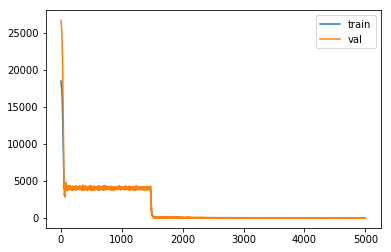

{95: 198, 93: 150, 57: 244, 88: 39, 17: 125, 68: 130, 81: 95, 11: 46, 1: 181, 35: 166, 26: 96, 56: 31, 98: 52, 13: 166, 60: 145, 7: 109, 65: 85, 66: 131, 51: 32, 58: 226, 41: 95, 96: 55, 84: 153, 87: 16, 37: 71, 55: 7, 28: 36, 71: 85, 2: 7, 46: 148, 33: 47, 48: 82, 89: 67, 86: 30, 61: 9, 24: 7, 18: 44, 70: 4, 100: 9, 97: 33, 3: 2, 75: 27, 12: 7, 43: 4, 59: 13, 22: 22, 72: 104, 74: 11, 76: 2, 39: 28, 83: 32, 29: 9, 54: 2, 62: 58, 67: 1, 0: 3, 8: 1, 53: 53, 94: 5, 30: 2, 99: 8, 27: 1, 45: 7, 80: 3, 69: 1, 38: 1, 6: 3, 49: 2, 42: 1, 44: 1, 5: 1, 79: 1, 50: 1}
CNN:  [ 11.488699 230.11443 ] [  3.0693686 113.04349  ]
COM:  [ 11.55166298 233.10698895] [ 3.68241608 10.81483717]


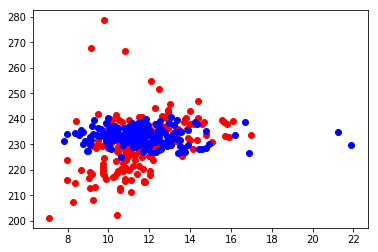

In [105]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

# New Model - Branched Convolutional Network

In [344]:
#torch.cuda.set_device(0)

class LocatorCNN_XY(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_XY, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.Tanh()
        self.activation_layer = nn.ELU()
                
        self.linear_1 = nn.Linear(2304, 1024) #Without dilation
        
        self.linear_2_x = nn.Linear(1024, 512)
        self.linear_3_x = nn.Linear(512, 128)
        self.linear_4_x = nn.Linear(128, 32)
        self.linear_5_x = nn.Linear(33, 8)
        self.linear_6_x = nn.Linear(8, 1)
        
        self.linear_2_y = nn.Linear(1024, 512)
        self.linear_3_y = nn.Linear(512, 128)
        self.linear_4_y = nn.Linear(128, 32)
        self.linear_5_y = nn.Linear(33, 8)
        self.linear_6_y = nn.Linear(8, 1)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        
        out = self.linear_1(out)
        out = self.activation_layer(out)
        
        out_x = self.linear_2_x(out)
        out_x = self.activation_layer(out_x)
        out_x = self.drop1(out_x)
        out_x = self.linear_3_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_4_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = torch.cat((out_x, channel), dim=1)
        out_x = self.linear_5_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_6_x(out_x)
        
        out_y = self.linear_2_y(out)
        out_y = self.activation_layer(out_y)
        out_y = self.drop1(out_y)
        out_y = self.linear_3_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_4_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = torch.cat((out_y, channel), dim=1)
        out_y = self.linear_5_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_6_y(out_y)
        
        final = torch.cat((out_x, out_y)).view(dim, -1)
        
        return final

In [259]:
import random
random.seed(0)

def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            dim = x.shape[0]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss = criterion(out, loc)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 5)
        v_im = np.zeros((5, 54, 54))
        v_ch = np.zeros((5, 1))
        v_loc = np.zeros((5, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(5, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 5, v_ch)
        v_loss = criterion(val_out, v_loc)
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        print('epoch [{}/{}], train:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return out, losses, val_losses

In [81]:
import random
random.seed(0)

def train_cnn_branch(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            dim = x.shape[0]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss1 = criterion(out[0], loc[0])
        loss2 = criterion(out[1], loc[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        (loss1 + loss2).backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 5)
        v_im = np.zeros((5, 54, 54))
        v_ch = np.zeros((5, 1))
        v_loc = np.zeros((5, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(5, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 5, v_ch)
        v_loss1 = criterion(val_out[0], v_loc[0])
        v_loss2 = criterion(val_out[1], v_loc[1])

        
        val_losses.append(v_loss1.data[0]+v_loss2.data[0])            
        losses.append(loss1.data[0]+loss2.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss1.data[0]+loss2.data[0], sum(losses[-10:])/len(losses[-10:])))
    return out, losses, val_losses

In [82]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [83]:
#print(image_data.keys())
#print(list_times_ch_train)
#print(location.values())

In [350]:
epoch_range = 3000
batch_size = 100
learning_rate = 0.0001

cnn_1 = LocatorCNN_XY().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn_branch(cnn_1, list_times_ch_train, list_times_ch_val ,new_image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:72131.94531, avg:72131.94531
epoch [2/3000], loss:71273.89062, avg:71702.92188
epoch [3/3000], loss:70498.21875, avg:71301.35938
epoch [4/3000], loss:69738.53125, avg:70910.64844
epoch [5/3000], loss:69311.93750, avg:70590.90625
epoch [6/3000], loss:68252.43750, avg:70201.16406
epoch [7/3000], loss:67531.71875, avg:69819.81250
epoch [8/3000], loss:66578.89062, avg:69414.69531
epoch [9/3000], loss:65903.60938, avg:69024.57812
epoch [10/3000], loss:64695.35156, avg:68591.65625
epoch [11/3000], loss:63718.85938, avg:67750.35156
epoch [12/3000], loss:62815.13281, avg:66904.47656
epoch [13/3000], loss:61792.98047, avg:66033.94531
epoch [14/3000], loss:60905.28906, avg:65150.62500
epoch [15/3000], loss:59800.21094, avg:64199.44531
epoch [16/3000], loss:58055.55859, avg:63179.75781
epoch [17/3000], loss:56520.53906, avg:62078.64453
epoch [18/3000], loss:54552.18359, avg:60875.96875
epoch [19/3000], loss:52864.32812, avg:59572.04297
epoch [20/3000], loss:51227.92188, avg:5

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

In [91]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

In [92]:
temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

{95: 198, 93: 150, 57: 244, 88: 39, 17: 125, 68: 130, 81: 95, 11: 46, 1: 181, 35: 166, 26: 96, 56: 31, 98: 52, 13: 166, 60: 145, 7: 109, 65: 85, 66: 131, 51: 32, 58: 226, 41: 95, 96: 55, 84: 153, 87: 16, 37: 71, 55: 7, 28: 36, 71: 85, 2: 7, 46: 148, 33: 47, 48: 82, 89: 67, 86: 30, 61: 9, 24: 7, 18: 44, 70: 4, 100: 9, 97: 33, 3: 2, 75: 27, 12: 7, 43: 4, 59: 13, 22: 22, 72: 104, 74: 11, 76: 2, 39: 28, 83: 32, 29: 9, 54: 2, 62: 58, 67: 1, 0: 3, 8: 1, 53: 53, 94: 5, 30: 2, 99: 8, 27: 1, 45: 7, 80: 3, 69: 1, 38: 1, 6: 3, 49: 2, 42: 1, 44: 1, 5: 1, 79: 1, 50: 1}
CNN:  [27.148443 22.558935] [2120.3801 1695.3096]
COM:  [ 11.55166298 233.10698895] [ 3.68241608 10.81483717]


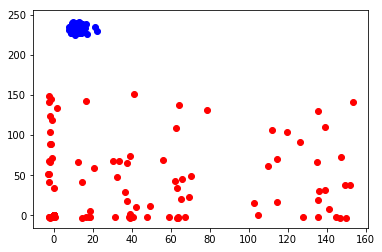

In [93]:
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

In [106]:
print(ground_truth)

[[     47   10029]
 [     35   10078]
 [     27   10094]
 ...
 [     45 1199869]
 [     20 1199885]
 [     27 1199900]]


In [117]:
print("ch", "t", "neuron", "x", "y")
for i, val in enumerate(list_times_ch_test):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-6, j+6):
            neuron = ground_truth[ind, 0] - 1
            print(val[1], val[0], neuron, somapos[0, neuron], somapos[1, neuron])
            continue

ch t neuron x y
95 878178 43 71.21975778349739 227.26135913539144
95 878178 37 27.688473886980738 215.5852797694069
93 878251 10 48.058360355686084 34.22882047206244
57 878332 48 -4.321020536548048 285.07452106690357
88 878402 17 21.929984086193784 86.07177710710573
17 878521 49 12.41516045629561 279.9171104449782
68 878529 12 6.204636629183717 66.89060094079736
81 878614 41 20.96538808643902 231.05365579519244
11 878714 8 -14.63904256434109 29.023447925545256
1 878818 40 1.2462724288123752 237.03833774992944
1 878818 13 32.8616714073321 65.09189524365455
35 878820 40 1.2462724288123752 237.03833774992944
35 878820 13 32.8616714073321 65.09189524365455
35 878820 27 78.06279007913575 142.09807088762165
26 878828 27 78.06279007913575 142.09807088762165
26 878828 31 84.4412944888875 160.61075267773893
93 878854 10 48.058360355686084 34.22882047206244
57 878883 48 -4.321020536548048 285.07452106690357
57 878883 2 53.20338083002666 -14.781218541861762
56 879015 5 30.572633591464864 15.53940

93 884102 10 48.058360355686084 34.22882047206244
7 884186 53 29.196404783660128 304.7212725070782
58 884200 47 89.17156341288208 258.0971028111536
58 884200 50 39.98196363986355 285.1030572853384
60 884213 28 2.0629572306957584 159.0798804374282
96 884259 8 -14.63904256434109 29.023447925545256
96 884259 11 62.46587907380028 29.46580953847061
68 884376 21 21.56309160168722 110.4201290286616
68 884376 12 6.204636629183717 66.89060094079736
89 884376 21 21.56309160168722 110.4201290286616
89 884376 12 6.204636629183717 66.89060094079736
17 884494 49 12.41516045629561 279.9171104449782
13 884618 18 43.73117057110287 81.61044728225859
35 884660 13 32.8616714073321 65.09189524365455
35 884660 50 39.98196363986355 285.1030572853384
57 884677 25 8.787039187848436 135.2796846214902
57 884677 48 -4.321020536548048 285.07452106690357
57 884677 2 53.20338083002666 -14.781218541861762
93 884691 10 48.058360355686084 34.22882047206244
65 884715 41 20.96538808643902 231.05365579519244
1 884765 40 1

81 889177 9 20.651608426259216 36.177201343026596
81 889177 27 78.06279007913575 142.09807088762165
26 889183 9 20.651608426259216 36.177201343026596
26 889183 27 78.06279007913575 142.09807088762165
26 889183 53 29.196404783660128 304.7212725070782
7 889190 53 29.196404783660128 304.7212725070782
46 889224 21 21.56309160168722 110.4201290286616
13 889241 18 43.73117057110287 81.61044728225859
13 889241 3 76.46626374529562 -11.87462893958022
1 889251 40 1.2462724288123752 237.03833774992944
48 889383 46 68.29533070622665 264.28863666998893
28 889396 11 62.46587907380028 29.46580953847061
28 889396 19 65.97012980454399 86.96092763176041
57 889472 48 -4.321020536548048 285.07452106690357
93 889539 10 48.058360355686084 34.22882047206244
93 889539 44 -2.0787885103061896 258.22839124713335
41 889609 37 27.688473886980738 215.5852797694069
17 889650 1 13.563411804694152 -9.808245958568477
17 889650 49 12.41516045629561 279.9171104449782
17 889650 33 12.032360327800141 179.29376161360074
81 

98 893322 22 58.86033512736802 118.92213464040759
98 893322 35 66.41585518194213 195.1814405242318
60 893365 28 2.0629572306957584 159.0798804374282
60 893365 44 -2.0787885103061896 258.22839124713335
60 893365 41 20.96538808643902 231.05365579519244
81 893371 41 20.96538808643902 231.05365579519244
81 893371 36 7.6721561585161595 208.86073497920086
18 893421 53 29.196404783660128 304.7212725070782
58 893437 47 89.17156341288208 258.0971028111536
37 893543 34 42.42885691382137 179.9372547328072
35 893555 13 32.8616714073321 65.09189524365455
13 893596 18 43.73117057110287 81.61044728225859
68 893735 12 6.204636629183717 66.89060094079736
68 893735 40 1.2462724288123752 237.03833774992944
1 893740 40 1.2462724288123752 237.03833774992944
93 893933 10 48.058360355686084 34.22882047206244
93 893933 17 21.929984086193784 86.07177710710573
93 893933 41 20.96538808643902 231.05365579519244
81 893938 41 20.96538808643902 231.05365579519244
46 893971 21 21.56309160168722 110.4201290286616
59 8

68 898796 40 1.2462724288123752 237.03833774992944
68 898796 12 6.204636629183717 66.89060094079736
41 898897 37 27.688473886980738 215.5852797694069
86 898970 17 21.929984086193784 86.07177710710573
58 899085 46 68.29533070622665 264.28863666998893
58 899085 20 7.4942574022962845 110.095967166767
58 899105 51 67.64586422530788 285.9671174973289
58 899105 47 89.17156341288208 258.0971028111536
60 899130 44 -2.0787885103061896 258.22839124713335
60 899130 28 2.0629572306957584 159.0798804374282
12 899138 14 56.635852252252064 54.52997833339967
12 899138 5 30.572633591464864 15.539403198947753
56 899143 5 30.572633591464864 15.539403198947753
93 899166 10 48.058360355686084 34.22882047206244
46 899218 21 21.56309160168722 110.4201290286616
46 899218 1 13.563411804694152 -9.808245958568477
17 899226 49 12.41516045629561 279.9171104449782
35 899256 13 32.8616714073321 65.09189524365455
84 899284 29 37.182174617108984 161.34565319128473
84 899284 41 20.96538808643902 231.05365579519244
13 8

37 906152 34 42.42885691382137 179.9372547328072
37 906152 30 56.40944800817404 158.56847750705774
37 906152 20 7.4942574022962845 110.095967166767
89 906229 21 21.56309160168722 110.4201290286616
57 906267 48 -4.321020536548048 285.07452106690357
13 906507 36 7.6721561585161595 208.86073497920086
13 906507 18 43.73117057110287 81.61044728225859
35 906571 13 32.8616714073321 65.09189524365455
60 906647 28 2.0629572306957584 159.0798804374282
7 906728 53 29.196404783660128 304.7212725070782
7 906728 24 -19.23563550600796 138.77277261771135
7 906728 27 78.06279007913575 142.09807088762165
26 906736 24 -19.23563550600796 138.77277261771135
26 906736 27 78.06279007913575 142.09807088762165
98 906767 22 58.86033512736802 118.92213464040759
98 906767 50 39.98196363986355 285.1030572853384
17 906782 49 12.41516045629561 279.9171104449782
83 906855 29 37.182174617108984 161.34565319128473
81 906919 41 20.96538808643902 231.05365579519244
57 906976 48 -4.321020536548048 285.07452106690357
89 90

35 913442 23 91.96037958183258 114.69148692316693
35 913442 13 32.8616714073321 65.09189524365455
29 913486 12 6.204636629183717 66.89060094079736
37 913508 34 42.42885691382137 179.9372547328072
17 913560 49 12.41516045629561 279.9171104449782
88 913633 17 21.929984086193784 86.07177710710573
1 913678 40 1.2462724288123752 237.03833774992944
1 913678 36 7.6721561585161595 208.86073497920086
60 913739 28 2.0629572306957584 159.0798804374282
71 913817 32 -11.078967322015629 182.23483294831658
26 913826 27 78.06279007913575 142.09807088762165
13 913888 18 43.73117057110287 81.61044728225859
13 913888 26 43.03259679874801 142.414760948499
58 913900 46 68.29533070622665 264.28863666998893
58 913900 31 84.4412944888875 160.61075267773893
7 913910 53 29.196404783660128 304.7212725070782
7 913910 0 -15.481029003693855 -14.975225920985395
57 913996 48 -4.321020536548048 285.07452106690357
81 914040 19 65.97012980454399 86.96092763176041
81 914040 41 20.96538808643902 231.05365579519244
74 9141

1 919996 40 1.2462724288123752 237.03833774992944
1 919996 53 29.196404783660128 304.7212725070782
1 919996 18 43.73117057110287 81.61044728225859
1 919996 17 21.929984086193784 86.07177710710573
88 920002 18 43.73117057110287 81.61044728225859
88 920002 17 21.929984086193784 86.07177710710573
51 920121 8 -14.63904256434109 29.023447925545256
71 920170 32 -11.078967322015629 182.23483294831658
17 920192 49 12.41516045629561 279.9171104449782
35 920217 13 32.8616714073321 65.09189524365455
57 920283 48 -4.321020536548048 285.07452106690357
22 920342 51 67.64586422530788 285.9671174973289
41 920390 38 60.57670279018768 213.41725808122825
41 920390 37 27.688473886980738 215.5852797694069
56 920443 5 30.572633591464864 15.539403198947753
66 920537 50 39.98196363986355 285.1030572853384
66 920537 34 42.42885691382137 179.9372547328072
60 920608 28 2.0629572306957584 159.0798804374282
1 920621 40 1.2462724288123752 237.03833774992944
13 920728 18 43.73117057110287 81.61044728225859
84 920808

17 926204 49 12.41516045629561 279.9171104449782
17 926204 1 13.563411804694152 -9.808245958568477
57 926271 48 -4.321020536548048 285.07452106690357
57 926271 2 53.20338083002666 -14.781218541861762
93 926648 10 48.058360355686084 34.22882047206244
56 926693 5 30.572633591464864 15.539403198947753
56 926693 52 2.689424678455879 319.1776364338083
13 926738 18 43.73117057110287 81.61044728225859
84 926746 41 20.96538808643902 231.05365579519244
84 926746 4 1.5823362971976067 10.150136258336886
60 926805 28 2.0629572306957584 159.0798804374282
7 926925 53 29.196404783660128 304.7212725070782
7 926925 15 90.36306974002551 58.164272038492086
57 926954 48 -4.321020536548048 285.07452106690357
57 926954 6 54.902873278407895 19.959384105320567
71 926984 32 -11.078967322015629 182.23483294831658
1 927007 40 1.2462724288123752 237.03833774992944
1 927007 12 6.204636629183717 66.89060094079736
68 927008 40 1.2462724288123752 237.03833774992944
68 927008 12 6.204636629183717 66.89060094079736
17 

11 934882 8 -14.63904256434109 29.023447925545256
17 935082 49 12.41516045629561 279.9171104449782
18 935188 53 29.196404783660128 304.7212725070782
12 935317 14 56.635852252252064 54.52997833339967
48 935333 46 68.29533070622665 264.28863666998893
100 935360 44 -2.0787885103061896 258.22839124713335
100 935360 48 -4.321020536548048 285.07452106690357
100 935360 0 -15.481029003693855 -14.975225920985395
95 935403 43 71.21975778349739 227.26135913539144
95 935403 10 48.058360355686084 34.22882047206244
95 935403 35 66.41585518194213 195.1814405242318
93 935409 10 48.058360355686084 34.22882047206244
93 935409 35 66.41585518194213 195.1814405242318
71 935560 32 -11.078967322015629 182.23483294831658
71 935560 50 39.98196363986355 285.1030572853384
71 935560 3 76.46626374529562 -11.87462893958022
56 935631 5 30.572633591464864 15.539403198947753
33 935759 38 60.57670279018768 213.41725808122825
1 935874 40 1.2462724288123752 237.03833774992944
7 935894 53 29.196404783660128 304.7212725070

71 942787 32 -11.078967322015629 182.23483294831658
17 942865 49 12.41516045629561 279.9171104449782
13 942882 18 43.73117057110287 81.61044728225859
13 942882 46 68.29533070622665 264.28863666998893
58 942887 46 68.29533070622665 264.28863666998893
58 942887 50 39.98196363986355 285.1030572853384
7 943016 53 29.196404783660128 304.7212725070782
7 943016 44 -2.0787885103061896 258.22839124713335
57 943082 48 -4.321020536548048 285.07452106690357
96 943093 10 48.058360355686084 34.22882047206244
96 943093 35 66.41585518194213 195.1814405242318
28 943180 11 62.46587907380028 29.46580953847061
1 943239 40 1.2462724288123752 237.03833774992944
1 943239 21 21.56309160168722 110.4201290286616
1 943239 1 13.563411804694152 -9.808245958568477
46 943244 21 21.56309160168722 110.4201290286616
46 943244 1 13.563411804694152 -9.808245958568477
30 943253 52 2.689424678455879 319.1776364338083
30 943253 26 43.03259679874801 142.414760948499
30 943253 51 67.64586422530788 285.9671174973289
60 943306 

84 949457 17 21.929984086193784 86.07177710710573
84 949457 42 35.03627355888451 226.68770520106688
17 949486 49 12.41516045629561 279.9171104449782
17 949486 20 7.4942574022962845 110.095967166767
93 949499 10 48.058360355686084 34.22882047206244
13 949658 18 43.73117057110287 81.61044728225859
57 949722 31 84.4412944888875 160.61075267773893
57 949722 48 -4.321020536548048 285.07452106690357
81 949771 41 20.96538808643902 231.05365579519244
58 950146 46 68.29533070622665 264.28863666998893
93 950156 10 48.058360355686084 34.22882047206244
28 950260 11 62.46587907380028 29.46580953847061
18 950270 53 29.196404783660128 304.7212725070782
18 950270 54 62.603384840652026 314.53088145476136
17 950414 49 12.41516045629561 279.9171104449782
72 950434 27 78.06279007913575 142.09807088762165
58 950484 47 89.17156341288208 258.0971028111536
56 950509 5 30.572633591464864 15.539403198947753
56 950509 34 42.42885691382137 179.9372547328072
37 950514 34 42.42885691382137 179.9372547328072
37 9505

58 957937 46 68.29533070622665 264.28863666998893
95 957952 49 12.41516045629561 279.9171104449782
95 957952 43 71.21975778349739 227.26135913539144
41 957969 37 27.688473886980738 215.5852797694069
26 958066 27 78.06279007913575 142.09807088762165
24 958094 10 48.058360355686084 34.22882047206244
60 958230 28 2.0629572306957584 159.0798804374282
1 958575 40 1.2462724288123752 237.03833774992944
33 958584 38 60.57670279018768 213.41725808122825
51 958620 8 -14.63904256434109 29.023447925545256
51 958620 11 62.46587907380028 29.46580953847061
96 958624 11 62.46587907380028 29.46580953847061
96 958624 35 66.41585518194213 195.1814405242318
84 958680 41 20.96538808643902 231.05365579519244
71 958697 32 -11.078967322015629 182.23483294831658
57 958783 48 -4.321020536548048 285.07452106690357
7 958811 53 29.196404783660128 304.7212725070782
93 958850 10 48.058360355686084 34.22882047206244
56 958918 5 30.572633591464864 15.539403198947753
56 958918 25 8.787039187848436 135.2796846214902
60 

58 966932 46 68.29533070622665 264.28863666998893
58 966932 24 -19.23563550600796 138.77277261771135
58 966932 28 2.0629572306957584 159.0798804374282
60 966937 24 -19.23563550600796 138.77277261771135
60 966937 28 2.0629572306957584 159.0798804374282
60 966937 7 84.46847549808167 14.246335268579315
11 966983 8 -14.63904256434109 29.023447925545256
7 967026 53 29.196404783660128 304.7212725070782
41 967049 2 53.20338083002666 -14.781218541861762
41 967049 37 27.688473886980738 215.5852797694069
41 967049 51 67.64586422530788 285.9671174973289
41 967049 6 54.902873278407895 19.959384105320567
93 967355 5 30.572633591464864 15.539403198947753
93 967355 10 48.058360355686084 34.22882047206244
93 967355 49 12.41516045629561 279.9171104449782
17 967361 49 12.41516045629561 279.9171104449782
57 967416 48 -4.321020536548048 285.07452106690357
68 967644 12 6.204636629183717 66.89060094079736
68 967644 40 1.2462724288123752 237.03833774992944
68 967644 50 39.98196363986355 285.1030572853384
84 

96 976252 11 62.46587907380028 29.46580953847061
93 976329 10 48.058360355686084 34.22882047206244
57 976538 48 -4.321020536548048 285.07452106690357
59 976604 35 66.41585518194213 195.1814405242318
39 976650 12 6.204636629183717 66.89060094079736
39 976650 40 1.2462724288123752 237.03833774992944
95 976670 43 71.21975778349739 227.26135913539144
26 976721 51 67.64586422530788 285.9671174973289
26 976721 27 78.06279007913575 142.09807088762165
26 976721 32 -11.078967322015629 182.23483294831658
71 976724 27 78.06279007913575 142.09807088762165
71 976724 32 -11.078967322015629 182.23483294831658
58 976777 46 68.29533070622665 264.28863666998893
86 976792 36 7.6721561585161595 208.86073497920086
86 976792 17 21.929984086193784 86.07177710710573
74 976888 13 32.8616714073321 65.09189524365455
74 976888 34 42.42885691382137 179.9372547328072
37 976889 13 32.8616714073321 65.09189524365455
37 976889 34 42.42885691382137 179.9372547328072
84 976995 41 20.96538808643902 231.05365579519244
84 

17 985183 49 12.41516045629561 279.9171104449782
96 985310 11 62.46587907380028 29.46580953847061
96 985310 55 86.68857442036482 312.60178399381834
65 985379 41 20.96538808643902 231.05365579519244
88 985465 47 89.17156341288208 258.0971028111536
88 985465 17 21.929984086193784 86.07177710710573
88 985465 15 90.36306974002551 58.164272038492086
13 985493 18 43.73117057110287 81.61044728225859
95 985514 43 71.21975778349739 227.26135913539144
57 985632 39 82.26593670956638 215.64550236108266
57 985632 48 -4.321020536548048 285.07452106690357
35 985832 13 32.8616714073321 65.09189524365455
35 985832 25 8.787039187848436 135.2796846214902
35 985832 12 6.204636629183717 66.89060094079736
35 985832 6 54.902873278407895 19.959384105320567
35 985832 34 42.42885691382137 179.9372547328072
66 985837 12 6.204636629183717 66.89060094079736
66 985837 6 54.902873278407895 19.959384105320567
66 985837 34 42.42885691382137 179.9372547328072
84 985988 42 35.03627355888451 226.68770520106688
95 986114 

95 992177 43 71.21975778349739 227.26135913539144
57 992188 48 -4.321020536548048 285.07452106690357
68 992244 12 6.204636629183717 66.89060094079736
68 992244 33 12.032360327800141 179.29376161360074
60 992438 28 2.0629572306957584 159.0798804374282
35 992542 13 32.8616714073321 65.09189524365455
35 992542 10 48.058360355686084 34.22882047206244
96 992549 10 48.058360355686084 34.22882047206244
96 992549 15 90.36306974002551 58.164272038492086
26 992560 29 37.182174617108984 161.34565319128473
26 992560 40 1.2462724288123752 237.03833774992944
26 992560 27 78.06279007913575 142.09807088762165
26 992560 50 39.98196363986355 285.1030572853384
48 992755 46 68.29533070622665 264.28863666998893
48 992755 7 84.46847549808167 14.246335268579315
28 992771 11 62.46587907380028 29.46580953847061
33 992809 33 12.032360327800141 179.29376161360074
33 992809 38 60.57670279018768 213.41725808122825
57 992889 48 -4.321020536548048 285.07452106690357
7 992931 53 29.196404783660128 304.7212725070782
5

65 999788 41 20.96538808643902 231.05365579519244
60 999831 28 2.0629572306957584 159.0798804374282
68 999908 1 13.563411804694152 -9.808245958568477
68 999908 12 6.204636629183717 66.89060094079736
35 1000252 13 32.8616714073321 65.09189524365455
71 1000276 32 -11.078967322015629 182.23483294831658
71 1000276 0 -15.481029003693855 -14.975225920985395
1 1000335 39 82.26593670956638 215.64550236108266
1 1000335 40 1.2462724288123752 237.03833774992944
81 1000527 41 20.96538808643902 231.05365579519244
68 1000537 12 6.204636629183717 66.89060094079736
95 1000581 43 71.21975778349739 227.26135913539144
57 1000684 48 -4.321020536548048 285.07452106690357
37 1000746 34 42.42885691382137 179.9372547328072
13 1000760 18 43.73117057110287 81.61044728225859
13 1000760 35 66.41585518194213 195.1814405242318
84 1000849 42 35.03627355888451 226.68770520106688
26 1000895 27 78.06279007913575 142.09807088762165
26 1000895 33 12.032360327800141 179.29376161360074
35 1001123 50 39.98196363986355 285.1

95 1008012 43 71.21975778349739 227.26135913539144
7 1008049 53 29.196404783660128 304.7212725070782
7 1008049 41 20.96538808643902 231.05365579519244
65 1008055 41 20.96538808643902 231.05365579519244
84 1008151 42 35.03627355888451 226.68770520106688
84 1008151 37 27.688473886980738 215.5852797694069
41 1008154 42 35.03627355888451 226.68770520106688
41 1008154 37 27.688473886980738 215.5852797694069
35 1008233 13 32.8616714073321 65.09189524365455
1 1008291 40 1.2462724288123752 237.03833774992944
1 1008291 33 12.032360327800141 179.29376161360074
68 1008309 12 6.204636629183717 66.89060094079736
68 1008309 10 48.058360355686084 34.22882047206244
96 1008310 12 6.204636629183717 66.89060094079736
96 1008310 10 48.058360355686084 34.22882047206244
13 1008398 18 43.73117057110287 81.61044728225859
66 1008439 34 42.42885691382137 179.9372547328072
66 1008439 44 -2.0787885103061896 258.22839124713335
28 1008595 11 62.46587907380028 29.46580953847061
71 1008616 32 -11.078967322015629 182.

71 1014787 32 -11.078967322015629 182.23483294831658
39 1015042 12 6.204636629183717 66.89060094079736
39 1015042 40 1.2462724288123752 237.03833774992944
39 1015042 18 43.73117057110287 81.61044728225859
37 1015225 33 12.032360327800141 179.29376161360074
37 1015225 34 42.42885691382137 179.9372547328072
37 1015225 1 13.563411804694152 -9.808245958568477
35 1015296 13 32.8616714073321 65.09189524365455
41 1015349 37 27.688473886980738 215.5852797694069
6 1015368 42 35.03627355888451 226.68770520106688
6 1015368 41 20.96538808643902 231.05365579519244
65 1015375 41 20.96538808643902 231.05365579519244
65 1015375 52 2.689424678455879 319.1776364338083
98 1015751 22 58.86033512736802 118.92213464040759
98 1015751 32 -11.078967322015629 182.23483294831658
71 1015757 32 -11.078967322015629 182.23483294831658
68 1015765 12 6.204636629183717 66.89060094079736
46 1015829 21 21.56309160168722 110.4201290286616
37 1015928 36 7.6721561585161595 208.86073497920086
37 1015928 34 42.42885691382137 

13 1023604 18 43.73117057110287 81.61044728225859
58 1023664 47 89.17156341288208 258.0971028111536
1 1023695 40 1.2462724288123752 237.03833774992944
48 1023776 46 68.29533070622665 264.28863666998893
53 1023835 50 39.98196363986355 285.1030572853384
53 1023835 42 35.03627355888451 226.68770520106688
95 1023892 43 71.21975778349739 227.26135913539144
66 1024165 34 42.42885691382137 179.9372547328072
48 1024248 0 -15.481029003693855 -14.975225920985395
48 1024248 46 68.29533070622665 264.28863666998893
48 1024248 21 21.56309160168722 110.4201290286616
48 1024248 48 -4.321020536548048 285.07452106690357
46 1024249 0 -15.481029003693855 -14.975225920985395
46 1024249 46 68.29533070622665 264.28863666998893
46 1024249 21 21.56309160168722 110.4201290286616
46 1024249 48 -4.321020536548048 285.07452106690357
57 1024255 48 -4.321020536548048 285.07452106690357
72 1024293 27 78.06279007913575 142.09807088762165
81 1024359 40 1.2462724288123752 237.03833774992944
60 1024409 28 2.0629572306957

84 1032049 41 20.96538808643902 231.05365579519244
41 1032123 37 27.688473886980738 215.5852797694069
41 1032123 33 12.032360327800141 179.29376161360074
18 1032171 53 29.196404783660128 304.7212725070782
58 1032199 47 89.17156341288208 258.0971028111536
100 1032307 48 -4.321020536548048 285.07452106690357
1 1032457 25 8.787039187848436 135.2796846214902
1 1032457 40 1.2462724288123752 237.03833774992944
66 1032475 34 42.42885691382137 179.9372547328072
58 1032486 46 68.29533070622665 264.28863666998893
58 1032486 28 2.0629572306957584 159.0798804374282
60 1032488 46 68.29533070622665 264.28863666998893
60 1032488 28 2.0629572306957584 159.0798804374282
46 1032796 21 21.56309160168722 110.4201290286616
84 1032916 42 35.03627355888451 226.68770520106688
84 1032916 17 21.929984086193784 86.07177710710573
84 1032988 41 20.96538808643902 231.05365579519244
95 1033157 43 71.21975778349739 227.26135913539144
95 1033157 1 13.563411804694152 -9.808245958568477
58 1033242 46 68.29533070622665 2

7 1039999 53 29.196404783660128 304.7212725070782
13 1040088 18 43.73117057110287 81.61044728225859
89 1040194 21 21.56309160168722 110.4201290286616
37 1040245 34 42.42885691382137 179.9372547328072
99 1040276 44 -2.0787885103061896 258.22839124713335
99 1040276 26 43.03259679874801 142.414760948499
42 1040392 29 37.182174617108984 161.34565319128473
51 1040458 8 -14.63904256434109 29.023447925545256
68 1040466 12 6.204636629183717 66.89060094079736
60 1040493 28 2.0629572306957584 159.0798804374282
84 1040506 41 20.96538808643902 231.05365579519244
35 1040574 13 32.8616714073321 65.09189524365455
71 1040703 32 -11.078967322015629 182.23483294831658
71 1040703 21 21.56309160168722 110.4201290286616
46 1040709 21 21.56309160168722 110.4201290286616
81 1040799 37 27.688473886980738 215.5852797694069
57 1040894 48 -4.321020536548048 285.07452106690357
57 1040894 30 56.40944800817404 158.56847750705774
98 1040920 22 58.86033512736802 118.92213464040759
1 1040965 40 1.2462724288123752 237.

46 1048535 21 21.56309160168722 110.4201290286616
68 1048747 12 6.204636629183717 66.89060094079736
57 1048770 39 82.26593670956638 215.64550236108266
57 1048770 48 -4.321020536548048 285.07452106690357
62 1048780 15 90.36306974002551 58.164272038492086
26 1048856 27 78.06279007913575 142.09807088762165
1 1048897 40 1.2462724288123752 237.03833774992944
71 1048906 32 -11.078967322015629 182.23483294831658
84 1048945 41 20.96538808643902 231.05365579519244
84 1048945 17 21.929984086193784 86.07177710710573
89 1049000 21 21.56309160168722 110.4201290286616
7 1049058 53 29.196404783660128 304.7212725070782
7 1049058 46 68.29533070622665 264.28863666998893
48 1049065 46 68.29533070622665 264.28863666998893
48 1049065 14 56.635852252252064 54.52997833339967
13 1049156 18 43.73117057110287 81.61044728225859
46 1049461 36 7.6721561585161595 208.86073497920086
46 1049461 21 21.56309160168722 110.4201290286616
57 1049575 3 76.46626374529562 -11.87462893958022
57 1049575 48 -4.321020536548048 28

95 1057967 43 71.21975778349739 227.26135913539144
46 1058006 21 21.56309160168722 110.4201290286616
58 1058077 47 89.17156341288208 258.0971028111536
86 1058178 17 21.929984086193784 86.07177710710573
48 1058217 46 68.29533070622665 264.28863666998893
57 1058325 36 7.6721561585161595 208.86073497920086
57 1058325 52 2.689424678455879 319.1776364338083
57 1058325 48 -4.321020536548048 285.07452106690357
60 1058446 28 2.0629572306957584 159.0798804374282
60 1058446 40 1.2462724288123752 237.03833774992944
89 1058495 21 21.56309160168722 110.4201290286616
81 1058717 41 20.96538808643902 231.05365579519244
53 1058752 39 82.26593670956638 215.64550236108266
53 1058752 42 35.03627355888451 226.68770520106688
26 1058775 27 78.06279007913575 142.09807088762165
75 1058805 45 27.73676678808696 261.30266622860006
48 1058848 46 68.29533070622665 264.28863666998893
95 1058926 43 71.21975778349739 227.26135913539144
39 1058946 12 6.204636629183717 66.89060094079736
46 1059000 44 -2.0787885103061896

1 1065506 40 1.2462724288123752 237.03833774992944
81 1065781 41 20.96538808643902 231.05365579519244
46 1065847 21 21.56309160168722 110.4201290286616
46 1065847 43 71.21975778349739 227.26135913539144
95 1065853 43 71.21975778349739 227.26135913539144
48 1065943 46 68.29533070622665 264.28863666998893
48 1065943 30 56.40944800817404 158.56847750705774
87 1066008 44 -2.0787885103061896 258.22839124713335
87 1066008 17 21.929984086193784 86.07177710710573
68 1066170 12 6.204636629183717 66.89060094079736
68 1066170 52 2.689424678455879 319.1776364338083
84 1066190 42 35.03627355888451 226.68770520106688
7 1066298 53 29.196404783660128 304.7212725070782
7 1066298 26 43.03259679874801 142.414760948499
1 1066345 35 66.41585518194213 195.1814405242318
1 1066345 40 1.2462724288123752 237.03833774992944
46 1066383 21 21.56309160168722 110.4201290286616
46 1066383 50 39.98196363986355 285.1030572853384
81 1066422 41 20.96538808643902 231.05365579519244
81 1066422 31 84.4412944888875 160.61075

46 1073217 21 21.56309160168722 110.4201290286616
60 1073362 28 2.0629572306957584 159.0798804374282
57 1073399 48 -4.321020536548048 285.07452106690357
57 1073399 44 -2.0787885103061896 258.22839124713335
68 1073453 25 8.787039187848436 135.2796846214902
68 1073453 12 6.204636629183717 66.89060094079736
68 1073453 20 7.4942574022962845 110.095967166767
83 1073617 29 37.182174617108984 161.34565319128473
13 1073674 18 43.73117057110287 81.61044728225859
95 1073695 43 71.21975778349739 227.26135913539144
72 1073766 27 78.06279007913575 142.09807088762165
46 1073788 21 21.56309160168722 110.4201290286616
48 1073817 19 65.97012980454399 86.96092763176041
48 1073817 46 68.29533070622665 264.28863666998893
65 1073950 41 20.96538808643902 231.05365579519244
1 1074063 40 1.2462724288123752 237.03833774992944
53 1074345 42 35.03627355888451 226.68770520106688
46 1074373 21 21.56309160168722 110.4201290286616
46 1074373 15 90.36306974002551 58.164272038492086
46 1074373 48 -4.321020536548048 28

89 1081063 8 -14.63904256434109 29.023447925545256
89 1081063 21 21.56309160168722 110.4201290286616
48 1081292 46 68.29533070622665 264.28863666998893
53 1081393 19 65.97012980454399 86.96092763176041
53 1081393 42 35.03627355888451 226.68770520106688
53 1081393 13 32.8616714073321 65.09189524365455
35 1081400 13 32.8616714073321 65.09189524365455
35 1081400 44 -2.0787885103061896 258.22839124713335
81 1081435 10 48.058360355686084 34.22882047206244
81 1081435 41 20.96538808643902 231.05365579519244
71 1081454 32 -11.078967322015629 182.23483294831658
71 1081454 37 27.688473886980738 215.5852797694069
41 1081459 37 27.688473886980738 215.5852797694069
13 1081522 18 43.73117057110287 81.61044728225859
57 1081532 48 -4.321020536548048 285.07452106690357
62 1081667 17 21.929984086193784 86.07177710710573
62 1081667 15 90.36306974002551 58.164272038492086
62 1081667 27 78.06279007913575 142.09807088762165
26 1081674 27 78.06279007913575 142.09807088762165
95 1081742 43 71.21975778349739 2

72 1088526 27 78.06279007913575 142.09807088762165
72 1088526 12 6.204636629183717 66.89060094079736
68 1088532 12 6.204636629183717 66.89060094079736
62 1088621 15 90.36306974002551 58.164272038492086
84 1088765 42 35.03627355888451 226.68770520106688
13 1088905 18 43.73117057110287 81.61044728225859
13 1088905 46 68.29533070622665 264.28863666998893
58 1088909 46 68.29533070622665 264.28863666998893
93 1088924 10 48.058360355686084 34.22882047206244
65 1089022 41 20.96538808643902 231.05365579519244
65 1089022 55 86.68857442036482 312.60178399381834
66 1089040 34 42.42885691382137 179.9372547328072
35 1089058 13 32.8616714073321 65.09189524365455
95 1089175 39 82.26593670956638 215.64550236108266
95 1089175 43 71.21975778349739 227.26135913539144
46 1089213 21 21.56309160168722 110.4201290286616
46 1089213 17 21.929984086193784 86.07177710710573
26 1089234 27 78.06279007913575 142.09807088762165
41 1089250 37 27.688473886980738 215.5852797694069
57 1089278 48 -4.321020536548048 285.0

84 1094787 31 84.4412944888875 160.61075267773893
17 1094849 49 12.41516045629561 279.9171104449782
75 1094882 45 27.73676678808696 261.30266622860006
13 1094905 18 43.73117057110287 81.61044728225859
89 1094986 21 21.56309160168722 110.4201290286616
95 1095045 43 71.21975778349739 227.26135913539144
95 1095045 50 39.98196363986355 285.1030572853384
66 1095071 34 42.42885691382137 179.9372547328072
98 1095147 22 58.86033512736802 118.92213464040759
26 1095197 27 78.06279007913575 142.09807088762165
93 1095291 10 48.058360355686084 34.22882047206244
93 1095291 53 29.196404783660128 304.7212725070782
7 1095296 53 29.196404783660128 304.7212725070782
83 1095470 29 37.182174617108984 161.34565319128473
35 1095551 13 32.8616714073321 65.09189524365455
53 1095629 42 35.03627355888451 226.68770520106688
53 1095629 20 7.4942574022962845 110.095967166767
53 1095629 41 20.96538808643902 231.05365579519244
57 1095691 48 -4.321020536548048 285.07452106690357
37 1095825 34 42.42885691382137 179.937

72 1101925 27 78.06279007913575 142.09807088762165
72 1101925 35 66.41585518194213 195.1814405242318
75 1101976 45 27.73676678808696 261.30266622860006
75 1101976 41 20.96538808643902 231.05365579519244
65 1101980 41 20.96538808643902 231.05365579519244
93 1102011 10 48.058360355686084 34.22882047206244
98 1102239 31 84.4412944888875 160.61075267773893
98 1102239 22 58.86033512736802 118.92213464040759
66 1102257 34 42.42885691382137 179.9372547328072
66 1102257 29 37.182174617108984 161.34565319128473
95 1102301 43 71.21975778349739 227.26135913539144
35 1102524 13 32.8616714073321 65.09189524365455
35 1102524 21 21.56309160168722 110.4201290286616
89 1102525 13 32.8616714073321 65.09189524365455
89 1102525 21 21.56309160168722 110.4201290286616
89 1102525 2 53.20338083002666 -14.781218541861762
89 1102525 27 78.06279007913575 142.09807088762165
26 1102532 2 53.20338083002666 -14.781218541861762
26 1102532 27 78.06279007913575 142.09807088762165
26 1102532 0 -15.481029003693855 -14.97

60 1109162 28 2.0629572306957584 159.0798804374282
46 1109203 21 21.56309160168722 110.4201290286616
35 1109243 13 32.8616714073321 65.09189524365455
62 1109264 30 56.40944800817404 158.56847750705774
62 1109264 15 90.36306974002551 58.164272038492086
95 1109277 3 76.46626374529562 -11.87462893958022
95 1109277 43 71.21975778349739 227.26135913539144
58 1109389 47 89.17156341288208 258.0971028111536
58 1109389 46 68.29533070622665 264.28863666998893
72 1109454 27 78.06279007913575 142.09807088762165
1 1109564 40 1.2462724288123752 237.03833774992944
66 1109812 34 42.42885691382137 179.9372547328072
65 1109901 9 20.651608426259216 36.177201343026596
65 1109901 41 20.96538808643902 231.05365579519244
48 1109919 46 68.29533070622665 264.28863666998893
98 1109946 22 58.86033512736802 118.92213464040759
83 1109975 29 37.182174617108984 161.34565319128473
95 1110008 43 71.21975778349739 227.26135913539144
13 1110023 18 43.73117057110287 81.61044728225859
72 1110041 27 78.06279007913575 142.0

13 1116988 15 90.36306974002551 58.164272038492086
13 1116988 18 43.73117057110287 81.61044728225859
80 1117020 36 7.6721561585161595 208.86073497920086
80 1117020 37 27.688473886980738 215.5852797694069
80 1117020 44 -2.0787885103061896 258.22839124713335
72 1117037 27 78.06279007913575 142.09807088762165
72 1117037 20 7.4942574022962845 110.095967166767
72 1117037 1 13.563411804694152 -9.808245958568477
98 1117118 22 58.86033512736802 118.92213464040759
35 1117323 13 32.8616714073321 65.09189524365455
93 1117344 10 48.058360355686084 34.22882047206244
93 1117344 31 84.4412944888875 160.61075267773893
93 1117344 54 62.603384840652026 314.53088145476136
84 1117361 41 20.96538808643902 231.05365579519244
95 1117535 43 71.21975778349739 227.26135913539144
3 1117591 11 62.46587907380028 29.46580953847061
53 1117678 42 35.03627355888451 226.68770520106688
53 1117678 29 37.182174617108984 161.34565319128473
26 1117861 27 78.06279007913575 142.09807088762165
26 1117861 45 27.73676678808696 2

66 1126582 34 42.42885691382137 179.9372547328072
66 1126582 25 8.787039187848436 135.2796846214902
65 1126601 41 20.96538808643902 231.05365579519244
72 1126784 27 78.06279007913575 142.09807088762165
84 1126810 42 35.03627355888451 226.68770520106688
84 1126810 31 84.4412944888875 160.61075267773893
71 1126993 32 -11.078967322015629 182.23483294831658
89 1127034 21 21.56309160168722 110.4201290286616
89 1127034 38 60.57670279018768 213.41725808122825
89 1127034 43 71.21975778349739 227.26135913539144
95 1127039 38 60.57670279018768 213.41725808122825
95 1127039 43 71.21975778349739 227.26135913539144
98 1127140 22 58.86033512736802 118.92213464040759
60 1127174 28 2.0629572306957584 159.0798804374282
58 1127195 24 -19.23563550600796 138.77277261771135
58 1127195 46 68.29533070622665 264.28863666998893
11 1127474 0 -15.481029003693855 -14.975225920985395
11 1127474 8 -14.63904256434109 29.023447925545256
95 1127860 43 71.21975778349739 227.26135913539144
95 1127860 31 84.4412944888875

95 1137602 43 71.21975778349739 227.26135913539144
58 1137622 46 68.29533070622665 264.28863666998893
46 1137644 21 21.56309160168722 110.4201290286616
58 1137833 47 89.17156341288208 258.0971028111536
1 1137853 40 1.2462724288123752 237.03833774992944
33 1137871 38 60.57670279018768 213.41725808122825
98 1138068 7 84.46847549808167 14.246335268579315
98 1138068 22 58.86033512736802 118.92213464040759
45 1138088 28 2.0629572306957584 159.0798804374282
45 1138088 46 68.29533070622665 264.28863666998893
58 1138093 46 68.29533070622665 264.28863666998893
58 1138093 32 -11.078967322015629 182.23483294831658
72 1138189 27 78.06279007913575 142.09807088762165
66 1138476 34 42.42885691382137 179.9372547328072
41 1138545 37 27.688473886980738 215.5852797694069
11 1138555 8 -14.63904256434109 29.023447925545256
58 1138579 46 68.29533070622665 264.28863666998893
58 1138839 47 89.17156341288208 258.0971028111536
58 1138839 35 66.41585518194213 195.1814405242318
62 1138855 15 90.36306974002551 58.

35 1147651 13 32.8616714073321 65.09189524365455
35 1147651 16 -16.705722316203534 85.04998913470799
35 1147651 29 37.182174617108984 161.34565319128473
11 1147674 8 -14.63904256434109 29.023447925545256
58 1147855 47 89.17156341288208 258.0971028111536
60 1147916 28 2.0629572306957584 159.0798804374282
13 1147999 18 43.73117057110287 81.61044728225859
13 1147999 31 84.4412944888875 160.61075267773893
13 1147999 12 6.204636629183717 66.89060094079736
29 1148004 31 84.4412944888875 160.61075267773893
29 1148004 12 6.204636629183717 66.89060094079736
29 1148004 46 68.29533070622665 264.28863666998893
58 1148009 46 68.29533070622665 264.28863666998893
58 1148009 1 13.563411804694152 -9.808245958568477
93 1148052 10 48.058360355686084 34.22882047206244
93 1148052 35 66.41585518194213 195.1814405242318
33 1148064 38 60.57670279018768 213.41725808122825
86 1148080 17 21.929984086193784 86.07177710710573
37 1148218 34 42.42885691382137 179.9372547328072
37 1148218 26 43.03259679874801 142.414

In [124]:
temp = [(878251, 93), (878332, 57)]
x = np.zeros((len(temp), 54, 54))
ch = np.zeros((len(temp), 1))
loc = np.zeros((len(temp), 2))

for i in range(len(temp)):
        pointer = temp[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(temp), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()
print(out)

[[ 45.694588  26.375175]
 [  9.017405 286.96277 ]]


In [128]:
com_loc = []
cnn_loc = []
for i, val in enumerate(temp):
    if True:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
print(cnn_loc)
print(com_loc)
#print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
#print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

[[ 45.694588  26.375175]
 [  9.017405 286.96277 ]]
[[ 46.541  26.116]
 [ 12.075 279.635]]


# Create New Dataset

In [129]:
print("ch", "t", "neuron", "x", "y")
for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-6, j+6):
            neuron = ground_truth[ind, 0] - 1
            print(val[1], val[0], neuron, somapos[0, neuron], somapos[1, neuron])

ch t neuron x y
48 10030 46 68.29533070622665 264.28863666998893
66 10080 34 42.42885691382137 179.9372547328072
65 10110 41 20.96538808643902 231.05365579519244
65 10110 40 1.2462724288123752 237.03833774992944
65 10110 54 62.603384840652026 314.53088145476136
57 10137 48 -4.321020536548048 285.07452106690357
68 10226 24 -19.23563550600796 138.77277261771135
68 10226 12 6.204636629183717 66.89060094079736
17 10309 1 13.563411804694152 -9.808245958568477
17 10309 49 12.41516045629561 279.9171104449782
72 10366 27 78.06279007913575 142.09807088762165
95 10411 43 71.21975778349739 227.26135913539144
95 10411 45 27.73676678808696 261.30266622860006
75 10412 43 71.21975778349739 227.26135913539144
75 10412 45 27.73676678808696 261.30266622860006
60 10425 28 2.0629572306957584 159.0798804374282
60 10425 35 66.41585518194213 195.1814405242318
13 10435 35 66.41585518194213 195.1814405242318
13 10435 18 43.73117057110287 81.61044728225859
13 10435 52 2.689424678455879 319.1776364338083
13 1043

13 14636 18 43.73117057110287 81.61044728225859
13 14636 55 86.68857442036482 312.60178399381834
13 14636 1 13.563411804694152 -9.808245958568477
13 14636 38 60.57670279018768 213.41725808122825
68 14669 12 6.204636629183717 66.89060094079736
68 14669 25 8.787039187848436 135.2796846214902
97 14679 22 58.86033512736802 118.92213464040759
97 14679 35 66.41585518194213 195.1814405242318
35 14787 13 32.8616714073321 65.09189524365455
1 14826 40 1.2462724288123752 237.03833774992944
1 14826 31 84.4412944888875 160.61075267773893
17 14961 49 12.41516045629561 279.9171104449782
17 14961 47 89.17156341288208 258.0971028111536
17 14961 39 82.26593670956638 215.64550236108266
46 14972 21 21.56309160168722 110.4201290286616
46 14972 34 42.42885691382137 179.9372547328072
66 14977 34 42.42885691382137 179.9372547328072
72 15026 27 78.06279007913575 142.09807088762165
72 15026 7 84.46847549808167 14.246335268579315
58 15042 46 68.29533070622665 264.28863666998893
57 15066 9 20.651608426259216 36.1

60 19096 28 2.0629572306957584 159.0798804374282
98 19225 22 58.86033512736802 118.92213464040759
98 19225 33 12.032360327800141 179.29376161360074
46 19266 21 21.56309160168722 110.4201290286616
46 19266 55 86.68857442036482 312.60178399381834
46 19266 39 82.26593670956638 215.64550236108266
7 19366 53 29.196404783660128 304.7212725070782
7 19366 47 89.17156341288208 258.0971028111536
58 19370 53 29.196404783660128 304.7212725070782
58 19370 47 89.17156341288208 258.0971028111536
35 19392 13 32.8616714073321 65.09189524365455
93 19452 10 48.058360355686084 34.22882047206244
95 19468 38 60.57670279018768 213.41725808122825
95 19468 43 71.21975778349739 227.26135913539144
57 19585 48 -4.321020536548048 285.07452106690357
57 19585 1 13.563411804694152 -9.808245958568477
57 19585 24 -19.23563550600796 138.77277261771135
66 19608 32 -11.078967322015629 182.23483294831658
66 19608 34 42.42885691382137 179.9372547328072
68 19657 44 -2.0787885103061896 258.22839124713335
68 19657 12 6.2046366

33 24360 38 60.57670279018768 213.41725808122825
66 24484 34 42.42885691382137 179.9372547328072
66 24484 35 66.41585518194213 195.1814405242318
66 24484 44 -2.0787885103061896 258.22839124713335
68 24494 12 6.204636629183717 66.89060094079736
11 24612 8 -14.63904256434109 29.023447925545256
74 24652 13 32.8616714073321 65.09189524365455
74 24652 26 43.03259679874801 142.414760948499
22 24667 1 13.563411804694152 -9.808245958568477
22 24667 51 67.64586422530788 285.9671174973289
95 24687 31 84.4412944888875 160.61075267773893
95 24687 43 71.21975778349739 227.26135913539144
48 24764 46 68.29533070622665 264.28863666998893
48 24764 48 -4.321020536548048 285.07452106690357
57 24769 48 -4.321020536548048 285.07452106690357
93 24942 10 48.058360355686084 34.22882047206244
46 24951 21 21.56309160168722 110.4201290286616
46 24951 42 35.03627355888451 226.68770520106688
84 24952 21 21.56309160168722 110.4201290286616
84 24952 42 35.03627355888451 226.68770520106688
84 24952 0 -15.481029003693

57 28513 44 -2.0787885103061896 258.22839124713335
57 28513 48 -4.321020536548048 285.07452106690357
17 28560 49 12.41516045629561 279.9171104449782
58 28576 26 43.03259679874801 142.414760948499
58 28576 46 68.29533070622665 264.28863666998893
33 28608 36 7.6721561585161595 208.86073497920086
33 28608 38 60.57670279018768 213.41725808122825
98 28738 22 58.86033512736802 118.92213464040759
35 28765 13 32.8616714073321 65.09189524365455
93 28806 10 48.058360355686084 34.22882047206244
93 28806 28 2.0629572306957584 159.0798804374282
60 28812 28 2.0629572306957584 159.0798804374282
68 28850 12 6.204636629183717 66.89060094079736
11 28909 0 -15.481029003693855 -14.975225920985395
11 28909 8 -14.63904256434109 29.023447925545256
58 28920 47 89.17156341288208 258.0971028111536
58 28920 55 86.68857442036482 312.60178399381834
66 28929 34 42.42885691382137 179.9372547328072
66 28929 7 84.46847549808167 14.246335268579315
66 28929 27 78.06279007913575 142.09807088762165
1 29043 33 12.032360327

95 32901 43 71.21975778349739 227.26135913539144
95 32901 7 84.46847549808167 14.246335268579315
31 32995 18 43.73117057110287 81.61044728225859
31 32995 39 82.26593670956638 215.64550236108266
57 33017 48 -4.321020536548048 285.07452106690357
57 33017 21 21.56309160168722 110.4201290286616
46 33025 21 21.56309160168722 110.4201290286616
46 33025 34 42.42885691382137 179.9372547328072
37 33032 34 42.42885691382137 179.9372547328072
100 33065 44 -2.0787885103061896 258.22839124713335
100 33065 49 12.41516045629561 279.9171104449782
60 33082 28 2.0629572306957584 159.0798804374282
41 33091 37 27.688473886980738 215.5852797694069
93 33129 10 48.058360355686084 34.22882047206244
98 33166 25 8.787039187848436 135.2796846214902
98 33166 22 58.86033512736802 118.92213464040759
98 33166 40 1.2462724288123752 237.03833774992944
11 33183 8 -14.63904256434109 29.023447925545256
68 33278 12 6.204636629183717 66.89060094079736
68 33278 19 65.97012980454399 86.96092763176041
53 33324 42 35.036273558

66 37360 34 42.42885691382137 179.9372547328072
57 37415 31 84.4412944888875 160.61075267773893
57 37415 48 -4.321020536548048 285.07452106690357
11 37599 8 -14.63904256434109 29.023447925545256
11 37599 22 58.86033512736802 118.92213464040759
98 37602 8 -14.63904256434109 29.023447925545256
98 37602 22 58.86033512736802 118.92213464040759
98 37602 46 68.29533070622665 264.28863666998893
58 37609 46 68.29533070622665 264.28863666998893
58 37609 55 86.68857442036482 312.60178399381834
84 37640 42 35.03627355888451 226.68770520106688
35 37747 13 32.8616714073321 65.09189524365455
66 37763 44 -2.0787885103061896 258.22839124713335
66 37763 47 89.17156341288208 258.0971028111536
66 37763 34 42.42885691382137 179.9372547328072
60 37776 28 2.0629572306957584 159.0798804374282
60 37776 51 67.64586422530788 285.9671174973289
95 37805 43 71.21975778349739 227.26135913539144
95 37805 30 56.40944800817404 158.56847750705774
89 37850 21 21.56309160168722 110.4201290286616
89 37850 7 84.46847549808

60 41131 36 7.6721561585161595 208.86073497920086
95 41147 43 71.21975778349739 227.26135913539144
95 41147 50 39.98196363986355 285.1030572853384
26 41389 27 78.06279007913575 142.09807088762165
66 41402 26 43.03259679874801 142.414760948499
66 41402 34 42.42885691382137 179.9372547328072
17 41471 49 12.41516045629561 279.9171104449782
17 41471 2 53.20338083002666 -14.781218541861762
17 41471 46 68.29533070622665 264.28863666998893
58 41474 49 12.41516045629561 279.9171104449782
58 41474 2 53.20338083002666 -14.781218541861762
58 41474 46 68.29533070622665 264.28863666998893
93 41509 10 48.058360355686084 34.22882047206244
65 41520 41 20.96538808643902 231.05365579519244
65 41520 25 8.787039187848436 135.2796846214902
33 41553 7 84.46847549808167 14.246335268579315
33 41553 38 60.57670279018768 213.41725808122825
33 41553 17 21.929984086193784 86.07177710710573
86 41555 7 84.46847549808167 14.246335268579315
86 41555 38 60.57670279018768 213.41725808122825
86 41555 17 21.9299840861937

37 45444 34 42.42885691382137 179.9372547328072
71 45532 32 -11.078967322015629 182.23483294831658
95 45543 43 71.21975778349739 227.26135913539144
46 45585 21 21.56309160168722 110.4201290286616
60 45596 28 2.0629572306957584 159.0798804374282
26 45607 8 -14.63904256434109 29.023447925545256
26 45607 27 78.06279007913575 142.09807088762165
1 45617 40 1.2462724288123752 237.03833774992944
1 45617 7 84.46847549808167 14.246335268579315
84 45732 42 35.03627355888451 226.68770520106688
68 45760 12 6.204636629183717 66.89060094079736
68 45760 46 68.29533070622665 264.28863666998893
13 45772 18 43.73117057110287 81.61044728225859
98 45842 22 58.86033512736802 118.92213464040759
98 45842 47 89.17156341288208 258.0971028111536
35 45885 13 32.8616714073321 65.09189524365455
37 45960 34 42.42885691382137 179.9372547328072
37 45960 39 82.26593670956638 215.64550236108266
28 46026 11 62.46587907380028 29.46580953847061
46 46060 21 21.56309160168722 110.4201290286616
46 46060 49 12.41516045629561 

72 50347 27 78.06279007913575 142.09807088762165
57 50357 48 -4.321020536548048 285.07452106690357
96 50476 11 62.46587907380028 29.46580953847061
17 50511 49 12.41516045629561 279.9171104449782
97 50526 25 8.787039187848436 135.2796846214902
97 50526 22 58.86033512736802 118.92213464040759
98 50529 25 8.787039187848436 135.2796846214902
98 50529 22 58.86033512736802 118.92213464040759
95 50582 43 71.21975778349739 227.26135913539144
95 50582 29 37.182174617108984 161.34565319128473
95 50582 6 54.902873278407895 19.959384105320567
46 50720 34 42.42885691382137 179.9372547328072
46 50720 18 43.73117057110287 81.61044728225859
46 50720 21 21.56309160168722 110.4201290286616
46 50720 17 21.929984086193784 86.07177710710573
37 50720 34 42.42885691382137 179.9372547328072
37 50720 18 43.73117057110287 81.61044728225859
37 50720 21 21.56309160168722 110.4201290286616
37 50720 17 21.929984086193784 86.07177710710573
89 50722 34 42.42885691382137 179.9372547328072
89 50722 18 43.73117057110287

71 56034 12 6.204636629183717 66.89060094079736
71 56034 32 -11.078967322015629 182.23483294831658
71 56034 33 12.032360327800141 179.29376161360074
71 56034 31 84.4412944888875 160.61075267773893
71 56034 10 48.058360355686084 34.22882047206244
93 56042 31 84.4412944888875 160.61075267773893
93 56042 10 48.058360355686084 34.22882047206244
93 56042 9 20.651608426259216 36.177201343026596
26 56121 27 78.06279007913575 142.09807088762165
26 56121 55 86.68857442036482 312.60178399381834
66 56228 29 37.182174617108984 161.34565319128473
66 56228 34 42.42885691382137 179.9372547328072
17 56326 49 12.41516045629561 279.9171104449782
98 56369 22 58.86033512736802 118.92213464040759
98 56369 14 56.635852252252064 54.52997833339967
51 56411 8 -14.63904256434109 29.023447925545256
51 56411 13 32.8616714073321 65.09189524365455
35 56415 8 -14.63904256434109 29.023447925545256
35 56415 13 32.8616714073321 65.09189524365455
33 56438 38 60.57670279018768 213.41725808122825
58 56458 42 35.0362735588

13 61871 9 20.651608426259216 36.177201343026596
13 61871 54 62.603384840652026 314.53088145476136
13 61871 18 43.73117057110287 81.61044728225859
66 61902 34 42.42885691382137 179.9372547328072
66 61902 46 68.29533070622665 264.28863666998893
58 61907 46 68.29533070622665 264.28863666998893
84 61986 42 35.03627355888451 226.68770520106688
68 62102 12 6.204636629183717 66.89060094079736
11 62126 14 56.635852252252064 54.52997833339967
11 62126 7 84.46847549808167 14.246335268579315
11 62126 8 -14.63904256434109 29.023447925545256
60 62199 28 2.0629572306957584 159.0798804374282
60 62199 31 84.4412944888875 160.61075267773893
95 62343 43 71.21975778349739 227.26135913539144
35 62468 13 32.8616714073321 65.09189524365455
35 62468 44 -2.0787885103061896 258.22839124713335
46 62479 21 21.56309160168722 110.4201290286616
46 62479 36 7.6721561585161595 208.86073497920086
26 62487 36 7.6721561585161595 208.86073497920086
26 62487 27 78.06279007913575 142.09807088762165
1 62581 26 43.032596798

48 68962 46 68.29533070622665 264.28863666998893
98 68990 22 58.86033512736802 118.92213464040759
98 68990 54 62.603384840652026 314.53088145476136
35 69057 13 32.8616714073321 65.09189524365455
35 69057 28 2.0629572306957584 159.0798804374282
60 69063 28 2.0629572306957584 159.0798804374282
89 69175 21 21.56309160168722 110.4201290286616
39 69237 12 6.204636629183717 66.89060094079736
66 69309 34 42.42885691382137 179.9372547328072
75 69391 45 27.73676678808696 261.30266622860006
95 69423 43 71.21975778349739 227.26135913539144
95 69423 31 84.4412944888875 160.61075267773893
18 69606 53 29.196404783660128 304.7212725070782
12 69635 14 56.635852252252064 54.52997833339967
26 69676 27 78.06279007913575 142.09807088762165
58 69770 46 68.29533070622665 264.28863666998893
58 69770 23 91.96037958183258 114.69148692316693
58 69770 17 21.929984086193784 86.07177710710573
86 69774 46 68.29533070622665 264.28863666998893
86 69774 23 91.96037958183258 114.69148692316693
86 69774 17 21.9299840861

98 75476 22 58.86033512736802 118.92213464040759
98 75476 9 20.651608426259216 36.177201343026596
98 75476 35 66.41585518194213 195.1814405242318
57 75487 48 -4.321020536548048 285.07452106690357
57 75487 21 21.56309160168722 110.4201290286616
57 75487 14 56.635852252252064 54.52997833339967
46 75492 21 21.56309160168722 110.4201290286616
46 75492 14 56.635852252252064 54.52997833339967
28 75547 11 62.46587907380028 29.46580953847061
71 75594 20 7.4942574022962845 110.095967166767
71 75594 32 -11.078967322015629 182.23483294831658
71 75594 7 84.46847549808167 14.246335268579315
35 75698 13 32.8616714073321 65.09189524365455
81 75714 55 86.68857442036482 312.60178399381834
81 75714 41 20.96538808643902 231.05365579519244
68 75892 19 65.97012980454399 86.96092763176041
68 75892 12 6.204636629183717 66.89060094079736
46 76165 21 21.56309160168722 110.4201290286616
46 76165 53 29.196404783660128 304.7212725070782
46 76165 14 56.635852252252064 54.52997833339967
7 76169 21 21.56309160168722

72 83210 48 -4.321020536548048 285.07452106690357
72 83210 27 78.06279007913575 142.09807088762165
72 83210 0 -15.481029003693855 -14.975225920985395
68 83247 12 6.204636629183717 66.89060094079736
68 83247 47 89.17156341288208 258.0971028111536
35 83297 13 32.8616714073321 65.09189524365455
84 83355 41 20.96538808643902 231.05365579519244
84 83355 38 60.57670279018768 213.41725808122825
1 83430 40 1.2462724288123752 237.03833774992944
88 83491 17 21.929984086193784 86.07177710710573
51 83531 8 -14.63904256434109 29.023447925545256
95 83603 54 62.603384840652026 314.53088145476136
95 83603 43 71.21975778349739 227.26135913539144
95 83603 51 67.64586422530788 285.9671174973289
95 83603 53 29.196404783660128 304.7212725070782
18 83610 51 67.64586422530788 285.9671174973289
18 83610 53 29.196404783660128 304.7212725070782
18 83610 3 76.46626374529562 -11.87462893958022
17 83671 49 12.41516045629561 279.9171104449782
96 83798 11 62.46587907380028 29.46580953847061
46 83814 21 21.5630916016

29 90299 12 6.204636629183717 66.89060094079736
99 90347 44 -2.0787885103061896 258.22839124713335
60 90406 28 2.0629572306957584 159.0798804374282
33 90434 51 67.64586422530788 285.9671174973289
33 90434 24 -19.23563550600796 138.77277261771135
33 90434 38 60.57670279018768 213.41725808122825
57 90631 48 -4.321020536548048 285.07452106690357
48 90662 46 68.29533070622665 264.28863666998893
18 90682 40 1.2462724288123752 237.03833774992944
18 90682 53 29.196404783660128 304.7212725070782
18 90682 13 32.8616714073321 65.09189524365455
18 90682 54 62.603384840652026 314.53088145476136
35 90686 53 29.196404783660128 304.7212725070782
35 90686 13 32.8616714073321 65.09189524365455
35 90686 54 62.603384840652026 314.53088145476136
87 90794 21 21.56309160168722 110.4201290286616
87 90794 49 12.41516045629561 279.9171104449782
17 90798 21 21.56309160168722 110.4201290286616
17 90798 49 12.41516045629561 279.9171104449782
17 90798 0 -15.481029003693855 -14.975225920985395
13 90815 18 43.731170

60 96418 28 2.0629572306957584 159.0798804374282
58 96441 46 68.29533070622665 264.28863666998893
58 96441 50 39.98196363986355 285.1030572853384
58 96441 1 13.563411804694152 -9.808245958568477
17 96482 49 12.41516045629561 279.9171104449782
13 96588 18 43.73117057110287 81.61044728225859
74 96670 13 32.8616714073321 65.09189524365455
58 96765 47 89.17156341288208 258.0971028111536
95 96814 48 -4.321020536548048 285.07452106690357
95 96814 1 13.563411804694152 -9.808245958568477
95 96814 43 71.21975778349739 227.26135913539144
57 96812 20 7.4942574022962845 110.095967166767
57 96812 48 -4.321020536548048 285.07452106690357
57 96812 1 13.563411804694152 -9.808245958568477
57 96812 43 71.21975778349739 227.26135913539144
68 96856 12 6.204636629183717 66.89060094079736
18 96947 53 29.196404783660128 304.7212725070782
96 97002 11 62.46587907380028 29.46580953847061
58 97137 0 -15.481029003693855 -14.975225920985395
58 97137 46 68.29533070622665 264.28863666998893
58 97137 33 12.0323603278

35 103110 55 86.68857442036482 312.60178399381834
35 103110 13 32.8616714073321 65.09189524365455
93 103173 10 48.058360355686084 34.22882047206244
58 103247 46 68.29533070622665 264.28863666998893
13 103480 18 43.73117057110287 81.61044728225859
57 103550 48 -4.321020536548048 285.07452106690357
57 103550 51 67.64586422530788 285.9671174973289
57 103550 52 2.689424678455879 319.1776364338083
96 103594 11 62.46587907380028 29.46580953847061
86 103605 17 21.929984086193784 86.07177710710573
12 103650 14 56.635852252252064 54.52997833339967
17 103695 2 53.20338083002666 -14.781218541861762
17 103695 49 12.41516045629561 279.9171104449782
26 103760 27 78.06279007913575 142.09807088762165
1 103943 40 1.2462724288123752 237.03833774992944
1 103943 3 76.46626374529562 -11.87462893958022
60 103964 28 2.0629572306957584 159.0798804374282
57 104155 48 -4.321020536548048 285.07452106690357
57 104155 53 29.196404783660128 304.7212725070782
7 104160 53 29.196404783660128 304.7212725070782
7 104160

13 110386 18 43.73117057110287 81.61044728225859
57 110445 48 -4.321020536548048 285.07452106690357
72 110645 27 78.06279007913575 142.09807088762165
72 110645 33 12.032360327800141 179.29376161360074
72 110645 13 32.8616714073321 65.09189524365455
35 110650 33 12.032360327800141 179.29376161360074
35 110650 13 32.8616714073321 65.09189524365455
35 110650 39 82.26593670956638 215.64550236108266
58 110660 47 89.17156341288208 258.0971028111536
17 110722 49 12.41516045629561 279.9171104449782
18 110786 53 29.196404783660128 304.7212725070782
66 110809 29 37.182174617108984 161.34565319128473
66 110809 35 66.41585518194213 195.1814405242318
57 110887 48 -4.321020536548048 285.07452106690357
96 110968 11 62.46587907380028 29.46580953847061
93 111070 10 48.058360355686084 34.22882047206244
93 111070 31 84.4412944888875 160.61075267773893
93 111070 50 39.98196363986355 285.1030572853384
93 111070 7 84.46847549808167 14.246335268579315
95 111250 43 71.21975778349739 227.26135913539144
60 1113

17 118612 49 12.41516045629561 279.9171104449782
17 118612 6 54.902873278407895 19.959384105320567
58 118626 47 89.17156341288208 258.0971028111536
57 118797 52 2.689424678455879 319.1776364338083
57 118797 48 -4.321020536548048 285.07452106690357
95 118871 43 71.21975778349739 227.26135913539144
46 118884 21 21.56309160168722 110.4201290286616
60 118925 28 2.0629572306957584 159.0798804374282
60 118925 51 67.64586422530788 285.9671174973289
60 118925 34 42.42885691382137 179.9372547328072
66 118930 51 67.64586422530788 285.9671174973289
66 118930 34 42.42885691382137 179.9372547328072
93 119059 10 48.058360355686084 34.22882047206244
13 119097 33 12.032360327800141 179.29376161360074
13 119097 29 37.182174617108984 161.34565319128473
13 119097 18 43.73117057110287 81.61044728225859
1 119245 40 1.2462724288123752 237.03833774992944
57 119288 48 -4.321020536548048 285.07452106690357
68 119403 0 -15.481029003693855 -14.975225920985395
68 119403 12 6.204636629183717 66.89060094079736
26 1

22 125495 46 68.29533070622665 264.28863666998893
33 125726 38 60.57670279018768 213.41725808122825
33 125726 17 21.929984086193784 86.07177710710573
66 125820 34 42.42885691382137 179.9372547328072
53 125850 42 35.03627355888451 226.68770520106688
57 125870 48 -4.321020536548048 285.07452106690357
71 125902 32 -11.078967322015629 182.23483294831658
72 125922 29 37.182174617108984 161.34565319128473
72 125922 27 78.06279007913575 142.09807088762165
93 125987 10 48.058360355686084 34.22882047206244
1 126013 40 1.2462724288123752 237.03833774992944
1 126013 36 7.6721561585161595 208.86073497920086
95 126022 36 7.6721561585161595 208.86073497920086
95 126022 43 71.21975778349739 227.26135913539144
35 126059 13 32.8616714073321 65.09189524365455
35 126059 41 20.96538808643902 231.05365579519244
84 126066 41 20.96538808643902 231.05365579519244
97 126125 22 58.86033512736802 118.92213464040759
17 126134 49 12.41516045629561 279.9171104449782
17 126134 6 54.902873278407895 19.959384105320567

95 130741 51 67.64586422530788 285.9671174973289
95 130741 43 71.21975778349739 227.26135913539144
95 130741 7 84.46847549808167 14.246335268579315
17 130853 49 12.41516045629561 279.9171104449782
17 130853 19 65.97012980454399 86.96092763176041
48 131023 38 60.57670279018768 213.41725808122825
48 131023 46 68.29533070622665 264.28863666998893
33 131022 38 60.57670279018768 213.41725808122825
33 131022 46 68.29533070622665 264.28863666998893
96 131069 11 62.46587907380028 29.46580953847061
96 131069 29 37.182174617108984 161.34565319128473
96 131069 35 66.41585518194213 195.1814405242318
72 131086 27 78.06279007913575 142.09807088762165
58 131146 47 89.17156341288208 258.0971028111536
37 131162 34 42.42885691382137 179.9372547328072
7 131183 48 -4.321020536548048 285.07452106690357
57 131186 48 -4.321020536548048 285.07452106690357
68 131206 12 6.204636629183717 66.89060094079736
93 131348 50 39.98196363986355 285.1030572853384
93 131348 10 48.058360355686084 34.22882047206244
95 13152

1 136881 40 1.2462724288123752 237.03833774992944
1 136881 39 82.26593670956638 215.64550236108266
28 137015 11 62.46587907380028 29.46580953847061
68 137040 12 6.204636629183717 66.89060094079736
68 137040 43 71.21975778349739 227.26135913539144
95 137045 43 71.21975778349739 227.26135913539144
95 137045 49 12.41516045629561 279.9171104449782
17 137053 49 12.41516045629561 279.9171104449782
97 137069 22 58.86033512736802 118.92213464040759
97 137069 14 56.635852252252064 54.52997833339967
31 137070 22 58.86033512736802 118.92213464040759
31 137070 14 56.635852252252064 54.52997833339967
66 137256 1 13.563411804694152 -9.808245958568477
66 137256 34 42.42885691382137 179.9372547328072
66 137256 47 89.17156341288208 258.0971028111536
57 137316 48 -4.321020536548048 285.07452106690357
58 137384 33 12.032360327800141 179.29376161360074
58 137384 46 68.29533070622665 264.28863666998893
93 137419 10 48.058360355686084 34.22882047206244
60 137437 28 2.0629572306957584 159.0798804374282
13 13

13 143527 18 43.73117057110287 81.61044728225859
58 143550 47 89.17156341288208 258.0971028111536
95 143644 55 86.68857442036482 312.60178399381834
95 143644 43 71.21975778349739 227.26135913539144
46 143730 21 21.56309160168722 110.4201290286616
46 143730 10 48.058360355686084 34.22882047206244
93 143737 10 48.058360355686084 34.22882047206244
86 143829 29 37.182174617108984 161.34565319128473
86 143829 17 21.929984086193784 86.07177710710573
86 143829 26 43.03259679874801 142.414760948499
96 143860 11 62.46587907380028 29.46580953847061
96 143860 6 54.902873278407895 19.959384105320567
75 143884 45 27.73676678808696 261.30266622860006
75 143884 33 12.032360327800141 179.29376161360074
68 144039 12 6.204636629183717 66.89060094079736
68 144039 54 62.603384840652026 314.53088145476136
53 144139 42 35.03627355888451 226.68770520106688
57 144186 48 -4.321020536548048 285.07452106690357
71 144262 32 -11.078967322015629 182.23483294831658
48 144290 9 20.651608426259216 36.177201343026596
4

56 150428 5 30.572633591464864 15.539403198947753
33 150469 38 60.57670279018768 213.41725808122825
33 150469 24 -19.23563550600796 138.77277261771135
33 150469 43 71.21975778349739 227.26135913539144
33 150469 13 32.8616714073321 65.09189524365455
95 150471 38 60.57670279018768 213.41725808122825
95 150471 24 -19.23563550600796 138.77277261771135
95 150471 43 71.21975778349739 227.26135913539144
95 150471 13 32.8616714073321 65.09189524365455
74 150476 13 32.8616714073321 65.09189524365455
84 150491 14 56.635852252252064 54.52997833339967
84 150491 42 35.03627355888451 226.68770520106688
97 150525 22 58.86033512736802 118.92213464040759
68 150538 12 6.204636629183717 66.89060094079736
68 150538 7 84.46847549808167 14.246335268579315
28 150614 11 62.46587907380028 29.46580953847061
84 150624 41 20.96538808643902 231.05365579519244
75 150681 50 39.98196363986355 285.1030572853384
75 150681 45 27.73676678808696 261.30266622860006
37 150717 34 42.42885691382137 179.9372547328072
18 150811

58 155762 46 68.29533070622665 264.28863666998893
57 155823 48 -4.321020536548048 285.07452106690357
62 155848 15 90.36306974002551 58.164272038492086
41 155914 37 27.688473886980738 215.5852797694069
88 155931 17 21.929984086193784 86.07177710710573
17 155969 49 12.41516045629561 279.9171104449782
17 155969 29 37.182174617108984 161.34565319128473
95 156032 43 71.21975778349739 227.26135913539144
68 156049 12 6.204636629183717 66.89060094079736
96 156101 5 30.572633591464864 15.539403198947753
96 156101 11 62.46587907380028 29.46580953847061
96 156101 55 86.68857442036482 312.60178399381834
84 156179 41 20.96538808643902 231.05365579519244
98 156241 1 13.563411804694152 -9.808245958568477
98 156241 22 58.86033512736802 118.92213464040759
1 156280 40 1.2462724288123752 237.03833774992944
35 156317 13 32.8616714073321 65.09189524365455
58 156379 46 68.29533070622665 264.28863666998893
57 156410 48 -4.321020536548048 285.07452106690357
57 156410 47 89.17156341288208 258.0971028111536
58 

57 161275 48 -4.321020536548048 285.07452106690357
57 161275 26 43.03259679874801 142.414760948499
53 161421 42 35.03627355888451 226.68770520106688
95 161471 43 71.21975778349739 227.26135913539144
95 161471 17 21.929984086193784 86.07177710710573
98 161486 22 58.86033512736802 118.92213464040759
48 161500 46 68.29533070622665 264.28863666998893
48 161500 10 48.058360355686084 34.22882047206244
48 161500 7 84.46847549808167 14.246335268579315
93 161503 46 68.29533070622665 264.28863666998893
93 161503 10 48.058360355686084 34.22882047206244
93 161503 7 84.46847549808167 14.246335268579315
26 161602 14 56.635852252252064 54.52997833339967
26 161602 27 78.06279007913575 142.09807088762165
26 161602 47 89.17156341288208 258.0971028111536
60 161735 28 2.0629572306957584 159.0798804374282
60 161735 52 2.689424678455879 319.1776364338083
84 161744 41 20.96538808643902 231.05365579519244
87 161758 38 60.57670279018768 213.41725808122825
87 161758 21 21.56309160168722 110.4201290286616
57 161

95 166864 43 71.21975778349739 227.26135913539144
95 166864 17 21.929984086193784 86.07177710710573
18 166874 53 29.196404783660128 304.7212725070782
35 166936 13 32.8616714073321 65.09189524365455
84 166995 42 35.03627355888451 226.68770520106688
17 167114 49 12.41516045629561 279.9171104449782
17 167114 35 66.41585518194213 195.1814405242318
58 167132 47 89.17156341288208 258.0971028111536
58 167132 46 68.29533070622665 264.28863666998893
58 167132 1 13.563411804694152 -9.808245958568477
58 167132 38 60.57670279018768 213.41725808122825
57 167327 48 -4.321020536548048 285.07452106690357
88 167382 17 21.929984086193784 86.07177710710573
26 167434 27 78.06279007913575 142.09807088762165
95 167549 43 71.21975778349739 227.26135913539144
65 167586 41 20.96538808643902 231.05365579519244
53 167617 42 35.03627355888451 226.68770520106688
7 167638 53 29.196404783660128 304.7212725070782
68 167652 12 6.204636629183717 66.89060094079736
93 167707 39 82.26593670956638 215.64550236108266
93 167

96 172320 11 62.46587907380028 29.46580953847061
84 172479 42 35.03627355888451 226.68770520106688
84 172479 15 90.36306974002551 58.164272038492086
13 172503 40 1.2462724288123752 237.03833774992944
13 172503 18 43.73117057110287 81.61044728225859
37 172570 34 42.42885691382137 179.9372547328072
37 172570 38 60.57670279018768 213.41725808122825
72 172581 27 78.06279007913575 142.09807088762165
58 172592 19 65.97012980454399 86.96092763176041
58 172592 0 -15.481029003693855 -14.975225920985395
58 172592 47 89.17156341288208 258.0971028111536
58 172592 1 13.563411804694152 -9.808245958568477
86 172636 17 21.929984086193784 86.07177710710573
57 172655 48 -4.321020536548048 285.07452106690357
84 172665 41 20.96538808643902 231.05365579519244
18 172699 53 29.196404783660128 304.7212725070782
39 172811 12 6.204636629183717 66.89060094079736
35 172896 30 56.40944800817404 158.56847750705774
35 172896 13 32.8616714073321 65.09189524365455
17 172928 49 12.41516045629561 279.9171104449782
17 17

96 178269 11 62.46587907380028 29.46580953847061
84 178313 41 20.96538808643902 231.05365579519244
48 178356 23 91.96037958183258 114.69148692316693
48 178356 46 68.29533070622665 264.28863666998893
48 178356 50 39.98196363986355 285.1030572853384
17 178426 49 12.41516045629561 279.9171104449782
17 178426 48 -4.321020536548048 285.07452106690357
37 178563 5 30.572633591464864 15.539403198947753
37 178563 34 42.42885691382137 179.9372547328072
33 178663 38 60.57670279018768 213.41725808122825
33 178663 42 35.03627355888451 226.68770520106688
53 178668 42 35.03627355888451 226.68770520106688
53 178668 33 12.032360327800141 179.29376161360074
95 178691 43 71.21975778349739 227.26135913539144
68 178776 12 6.204636629183717 66.89060094079736
13 178788 18 43.73117057110287 81.61044728225859
35 178900 13 32.8616714073321 65.09189524365455
7 178956 53 29.196404783660128 304.7212725070782
51 179069 8 -14.63904256434109 29.023447925545256
51 179069 46 68.29533070622665 264.28863666998893
48 1790

84 184134 42 35.03627355888451 226.68770520106688
93 184192 10 48.058360355686084 34.22882047206244
13 184217 18 43.73117057110287 81.61044728225859
84 184234 41 20.96538808643902 231.05365579519244
87 184388 17 21.929984086193784 86.07177710710573
87 184388 21 21.56309160168722 110.4201290286616
89 184389 17 21.929984086193784 86.07177710710573
89 184389 21 21.56309160168722 110.4201290286616
96 184461 11 62.46587907380028 29.46580953847061
96 184461 22 58.86033512736802 118.92213464040759
98 184463 11 62.46587907380028 29.46580953847061
98 184463 22 58.86033512736802 118.92213464040759
68 184474 0 -15.481029003693855 -14.975225920985395
68 184474 12 6.204636629183717 66.89060094079736
66 184485 34 42.42885691382137 179.9372547328072
66 184485 54 62.603384840652026 314.53088145476136
35 184496 2 53.20338083002666 -14.781218541861762
35 184496 13 32.8616714073321 65.09189524365455
17 184572 49 12.41516045629561 279.9171104449782
59 184684 35 66.41585518194213 195.1814405242318
59 18468

41 190419 37 27.688473886980738 215.5852797694069
26 190428 27 78.06279007913575 142.09807088762165
26 190428 17 21.929984086193784 86.07177710710573
88 190435 17 21.929984086193784 86.07177710710573
93 190564 10 48.058360355686084 34.22882047206244
93 190564 55 86.68857442036482 312.60178399381834
66 190601 34 42.42885691382137 179.9372547328072
68 190703 12 6.204636629183717 66.89060094079736
84 190712 41 20.96538808643902 231.05365579519244
58 190756 46 68.29533070622665 264.28863666998893
58 190756 3 76.46626374529562 -11.87462893958022
46 190804 21 21.56309160168722 110.4201290286616
84 190816 42 35.03627355888451 226.68770520106688
84 190816 36 7.6721561585161595 208.86073497920086
13 190840 18 43.73117057110287 81.61044728225859
13 190840 7 84.46847549808167 14.246335268579315
17 190863 49 12.41516045629561 279.9171104449782
35 190880 13 32.8616714073321 65.09189524365455
56 191134 5 30.572633591464864 15.539403198947753
56 191134 50 39.98196363986355 285.1030572853384
56 191134

1 197270 40 1.2462724288123752 237.03833774992944
72 197306 27 78.06279007913575 142.09807088762165
57 197548 48 -4.321020536548048 285.07452106690357
35 197574 17 21.929984086193784 86.07177710710573
35 197574 13 32.8616714073321 65.09189524365455
35 197574 51 67.64586422530788 285.9671174973289
58 197661 47 89.17156341288208 258.0971028111536
66 197682 26 43.03259679874801 142.414760948499
66 197682 34 42.42885691382137 179.9372547328072
7 197692 53 29.196404783660128 304.7212725070782
17 197758 49 12.41516045629561 279.9171104449782
62 197817 15 90.36306974002551 58.164272038492086
39 197870 12 6.204636629183717 66.89060094079736
39 197870 46 68.29533070622665 264.28863666998893
58 197875 46 68.29533070622665 264.28863666998893
46 197951 21 21.56309160168722 110.4201290286616
46 197951 3 76.46626374529562 -11.87462893958022
72 198104 27 78.06279007913575 142.09807088762165
13 198177 1 13.563411804694152 -9.808245958568477
13 198177 18 43.73117057110287 81.61044728225859
57 198189 48

57 203599 48 -4.321020536548048 285.07452106690357
13 203619 18 43.73117057110287 81.61044728225859
74 203679 13 32.8616714073321 65.09189524365455
11 203691 8 -14.63904256434109 29.023447925545256
11 203691 53 29.196404783660128 304.7212725070782
7 203693 8 -14.63904256434109 29.023447925545256
7 203693 53 29.196404783660128 304.7212725070782
7 203693 26 43.03259679874801 142.414760948499
98 203742 22 58.86033512736802 118.92213464040759
46 203764 21 21.56309160168722 110.4201290286616
60 203817 28 2.0629572306957584 159.0798804374282
72 203952 27 78.06279007913575 142.09807088762165
72 203952 0 -15.481029003693855 -14.975225920985395
72 203952 19 65.97012980454399 86.96092763176041
68 204136 12 6.204636629183717 66.89060094079736
58 204209 46 68.29533070622665 264.28863666998893
57 204288 48 -4.321020536548048 285.07452106690357
57 204288 29 37.182174617108984 161.34565319128473
35 204373 13 32.8616714073321 65.09189524365455
1 204413 40 1.2462724288123752 237.03833774992944
13 20446

60 211379 14 56.635852252252064 54.52997833339967
60 211379 26 43.03259679874801 142.414760948499
60 211379 18 43.73117057110287 81.61044728225859
60 211379 28 2.0629572306957584 159.0798804374282
68 211396 12 6.204636629183717 66.89060094079736
68 211396 1 13.563411804694152 -9.808245958568477
72 211628 27 78.06279007913575 142.09807088762165
58 211688 46 68.29533070622665 264.28863666998893
83 211783 29 37.182174617108984 161.34565319128473
68 211983 12 6.204636629183717 66.89060094079736
35 212013 54 62.603384840652026 314.53088145476136
35 212013 13 32.8616714073321 65.09189524365455
35 212013 33 12.032360327800141 179.29376161360074
66 212034 50 39.98196363986355 285.1030572853384
66 212034 34 42.42885691382137 179.9372547328072
11 212056 8 -14.63904256434109 29.023447925545256
86 212084 17 21.929984086193784 86.07177710710573
46 212171 21 21.56309160168722 110.4201290286616
13 212182 18 43.73117057110287 81.61044728225859
57 212261 48 -4.321020536548048 285.07452106690357
17 2122

26 219286 27 78.06279007913575 142.09807088762165
13 219298 18 43.73117057110287 81.61044728225859
39 219339 12 6.204636629183717 66.89060094079736
58 219519 26 43.03259679874801 142.414760948499
58 219519 46 68.29533070622665 264.28863666998893
11 219627 8 -14.63904256434109 29.023447925545256
66 219731 34 42.42885691382137 179.9372547328072
66 219731 24 -19.23563550600796 138.77277261771135
35 219757 13 32.8616714073321 65.09189524365455
35 219757 25 8.787039187848436 135.2796846214902
60 219811 28 2.0629572306957584 159.0798804374282
60 219811 55 86.68857442036482 312.60178399381834
46 219862 21 21.56309160168722 110.4201290286616
13 219962 18 43.73117057110287 81.61044728225859
13 219962 27 78.06279007913575 142.09807088762165
13 219962 49 12.41516045629561 279.9171104449782
26 219966 18 43.73117057110287 81.61044728225859
26 219966 27 78.06279007913575 142.09807088762165
26 219966 49 12.41516045629561 279.9171104449782
26 219966 26 43.03259679874801 142.414760948499
17 219969 27 7

60 225865 28 2.0629572306957584 159.0798804374282
13 225906 18 43.73117057110287 81.61044728225859
96 225915 11 62.46587907380028 29.46580953847061
96 225915 19 65.97012980454399 86.96092763176041
96 225915 36 7.6721561585161595 208.86073497920086
66 225998 34 42.42885691382137 179.9372547328072
51 226039 8 -14.63904256434109 29.023447925545256
51 226039 9 20.651608426259216 36.177201343026596
68 226305 12 6.204636629183717 66.89060094079736
68 226305 30 56.40944800817404 158.56847750705774
26 226376 27 78.06279007913575 142.09807088762165
26 226376 51 67.64586422530788 285.9671174973289
97 226514 22 58.86033512736802 118.92213464040759
46 226537 19 65.97012980454399 86.96092763176041
46 226537 21 21.56309160168722 110.4201290286616
37 226686 34 42.42885691382137 179.9372547328072
60 226736 28 2.0629572306957584 159.0798804374282
60 226736 50 39.98196363986355 285.1030572853384
60 226736 6 54.902873278407895 19.959384105320567
60 226736 33 12.032360327800141 179.29376161360074
35 22689

97 235705 22 58.86033512736802 118.92213464040759
97 235705 8 -14.63904256434109 29.023447925545256
97 235705 9 20.651608426259216 36.177201343026596
51 235711 8 -14.63904256434109 29.023447925545256
51 235711 9 20.651608426259216 36.177201343026596
46 235728 21 21.56309160168722 110.4201290286616
84 235751 42 35.03627355888451 226.68770520106688
68 235770 12 6.204636629183717 66.89060094079736
94 236154 19 65.97012980454399 86.96092763176041
94 236154 29 37.182174617108984 161.34565319128473
94 236154 25 8.787039187848436 135.2796846214902
7 236171 53 29.196404783660128 304.7212725070782
81 236221 41 20.96538808643902 231.05365579519244
51 236526 8 -14.63904256434109 29.023447925545256
51 236526 7 84.46847549808167 14.246335268579315
51 236526 32 -11.078967322015629 182.23483294831658
71 236533 32 -11.078967322015629 182.23483294831658
33 236576 38 60.57670279018768 213.41725808122825
33 236576 21 21.56309160168722 110.4201290286616
46 236583 21 21.56309160168722 110.4201290286616
46 

84 242909 41 20.96538808643902 231.05365579519244
93 243046 10 48.058360355686084 34.22882047206244
66 243088 34 42.42885691382137 179.9372547328072
12 243121 14 56.635852252252064 54.52997833339967
12 243121 47 89.17156341288208 258.0971028111536
13 243159 18 43.73117057110287 81.61044728225859
57 243217 48 -4.321020536548048 285.07452106690357
57 243217 1 13.563411804694152 -9.808245958568477
57 243217 36 7.6721561585161595 208.86073497920086
95 243269 43 71.21975778349739 227.26135913539144
11 243399 0 -15.481029003693855 -14.975225920985395
97 243432 22 58.86033512736802 118.92213464040759
33 243503 38 60.57670279018768 213.41725808122825
39 243568 12 6.204636629183717 66.89060094079736
39 243568 1 13.563411804694152 -9.808245958568477
46 243622 21 21.56309160168722 110.4201290286616
84 243637 41 20.96538808643902 231.05365579519244
93 243765 10 48.058360355686084 34.22882047206244
93 243765 27 78.06279007913575 142.09807088762165
93 243765 25 8.787039187848436 135.2796846214902
26

68 250713 10 48.058360355686084 34.22882047206244
68 250713 15 90.36306974002551 58.164272038492086
95 250823 43 71.21975778349739 227.26135913539144
57 250842 48 -4.321020536548048 285.07452106690357
57 250842 1 13.563411804694152 -9.808245958568477
2 250923 47 89.17156341288208 258.0971028111536
26 250964 27 78.06279007913575 142.09807088762165
26 250964 55 86.68857442036482 312.60178399381834
13 251132 18 43.73117057110287 81.61044728225859
1 251200 40 1.2462724288123752 237.03833774992944
81 251281 41 20.96538808643902 231.05365579519244
41 251330 42 35.03627355888451 226.68770520106688
41 251330 38 60.57670279018768 213.41725808122825
98 251505 22 58.86033512736802 118.92213464040759
98 251505 14 56.635852252252064 54.52997833339967
95 251661 43 71.21975778349739 227.26135913539144
46 251785 21 21.56309160168722 110.4201290286616
46 251785 8 -14.63904256434109 29.023447925545256
51 251788 21 21.56309160168722 110.4201290286616
51 251788 8 -14.63904256434109 29.023447925545256
68 2

96 258331 6 54.902873278407895 19.959384105320567
96 258331 14 56.635852252252064 54.52997833339967
28 258403 11 62.46587907380028 29.46580953847061
33 258457 38 60.57670279018768 213.41725808122825
93 258467 36 7.6721561585161595 208.86073497920086
93 258467 10 48.058360355686084 34.22882047206244
93 258467 55 86.68857442036482 312.60178399381834
2 258547 47 89.17156341288208 258.0971028111536
95 258625 43 71.21975778349739 227.26135913539144
95 258625 50 39.98196363986355 285.1030572853384
95 258625 13 32.8616714073321 65.09189524365455
35 258632 50 39.98196363986355 285.1030572853384
35 258632 13 32.8616714073321 65.09189524365455
68 258658 12 6.204636629183717 66.89060094079736
68 258658 40 1.2462724288123752 237.03833774992944
1 258665 40 1.2462724288123752 237.03833774992944
1 258665 41 20.96538808643902 231.05365579519244
84 258669 41 20.96538808643902 231.05365579519244
13 258717 21 21.56309160168722 110.4201290286616
13 258717 18 43.73117057110287 81.61044728225859
51 258812 8

28 264006 11 62.46587907380028 29.46580953847061
75 264048 45 27.73676678808696 261.30266622860006
1 264085 40 1.2462724288123752 237.03833774992944
37 264139 34 42.42885691382137 179.9372547328072
95 264295 43 71.21975778349739 227.26135913539144
24 264323 10 48.058360355686084 34.22882047206244
24 264323 13 32.8616714073321 65.09189524365455
65 264395 41 20.96538808643902 231.05365579519244
65 264395 14 56.635852252252064 54.52997833339967
13 264446 18 43.73117057110287 81.61044728225859
13 264446 2 53.20338083002666 -14.781218541861762
33 264466 38 60.57670279018768 213.41725808122825
33 264466 23 91.96037958183258 114.69148692316693
68 264476 23 91.96037958183258 114.69148692316693
68 264476 50 39.98196363986355 285.1030572853384
68 264476 7 84.46847549808167 14.246335268579315
68 264476 12 6.204636629183717 66.89060094079736
68 264476 55 86.68857442036482 312.60178399381834
60 264485 28 2.0629572306957584 159.0798804374282
60 264485 42 35.03627355888451 226.68770520106688
84 26449

95 270549 43 71.21975778349739 227.26135913539144
66 270710 34 42.42885691382137 179.9372547328072
93 270747 10 48.058360355686084 34.22882047206244
12 270887 25 8.787039187848436 135.2796846214902
12 270887 14 56.635852252252064 54.52997833339967
1 271127 40 1.2462724288123752 237.03833774992944
33 271195 38 60.57670279018768 213.41725808122825
68 271238 7 84.46847549808167 14.246335268579315
68 271238 12 6.204636629183717 66.89060094079736
57 271256 48 -4.321020536548048 285.07452106690357
60 271279 28 2.0629572306957584 159.0798804374282
60 271279 8 -14.63904256434109 29.023447925545256
51 271286 8 -14.63904256434109 29.023447925545256
35 271297 23 91.96037958183258 114.69148692316693
35 271297 13 32.8616714073321 65.09189524365455
93 271373 10 48.058360355686084 34.22882047206244
95 271404 43 71.21975778349739 227.26135913539144
13 271456 18 43.73117057110287 81.61044728225859
72 271467 27 78.06279007913575 142.09807088762165
81 271542 41 20.96538808643902 231.05365579519244
56 271

70 277381 45 27.73676678808696 261.30266622860006
28 277429 11 62.46587907380028 29.46580953847061
28 277429 20 7.4942574022962845 110.095967166767
68 277502 12 6.204636629183717 66.89060094079736
95 277559 2 53.20338083002666 -14.781218541861762
95 277559 14 56.635852252252064 54.52997833339967
95 277559 39 82.26593670956638 215.64550236108266
95 277559 43 71.21975778349739 227.26135913539144
98 277576 22 58.86033512736802 118.92213464040759
93 277852 10 48.058360355686084 34.22882047206244
60 277865 28 2.0629572306957584 159.0798804374282
60 277865 50 39.98196363986355 285.1030572853384
57 277947 48 -4.321020536548048 285.07452106690357
57 277947 19 65.97012980454399 86.96092763176041
71 278011 32 -11.078967322015629 182.23483294831658
48 278090 36 7.6721561585161595 208.86073497920086
48 278090 49 12.41516045629561 279.9171104449782
48 278090 46 68.29533070622665 264.28863666998893
17 278090 36 7.6721561585161595 208.86073497920086
17 278090 49 12.41516045629561 279.9171104449782
17

1 283814 40 1.2462724288123752 237.03833774992944
44 284004 33 12.032360327800141 179.29376161360074
44 284004 36 7.6721561585161595 208.86073497920086
44 284004 19 65.97012980454399 86.96092763176041
7 284132 48 -4.321020536548048 285.07452106690357
7 284132 53 29.196404783660128 304.7212725070782
7 284132 46 68.29533070622665 264.28863666998893
58 284138 46 68.29533070622665 264.28863666998893
58 284138 23 91.96037958183258 114.69148692316693
46 284176 55 86.68857442036482 312.60178399381834
46 284176 21 21.56309160168722 110.4201290286616
46 284176 7 84.46847549808167 14.246335268579315
93 284278 10 48.058360355686084 34.22882047206244
58 284357 47 89.17156341288208 258.0971028111536
58 284357 1 13.563411804694152 -9.808245958568477
97 284404 22 58.86033512736802 118.92213464040759
97 284404 19 65.97012980454399 86.96092763176041
13 284428 35 66.41585518194213 195.1814405242318
13 284428 18 43.73117057110287 81.61044728225859
11 284558 8 -14.63904256434109 29.023447925545256
48 2846

96 290865 11 62.46587907380028 29.46580953847061
96 290865 1 13.563411804694152 -9.808245958568477
1 290912 3 76.46626374529562 -11.87462893958022
1 290912 9 20.651608426259216 36.177201343026596
1 290912 40 1.2462724288123752 237.03833774992944
7 291083 53 29.196404783660128 304.7212725070782
71 291132 32 -11.078967322015629 182.23483294831658
71 291132 25 8.787039187848436 135.2796846214902
71 291132 50 39.98196363986355 285.1030572853384
93 291176 10 48.058360355686084 34.22882047206244
57 291227 48 -4.321020536548048 285.07452106690357
57 291227 30 56.40944800817404 158.56847750705774
57 291227 28 2.0629572306957584 159.0798804374282
60 291234 30 56.40944800817404 158.56847750705774
60 291234 28 2.0629572306957584 159.0798804374282
60 291234 46 68.29533070622665 264.28863666998893
66 291261 34 42.42885691382137 179.9372547328072
56 291280 5 30.572633591464864 15.539403198947753
62 291442 15 90.36306974002551 58.164272038492086
72 291587 27 78.06279007913575 142.09807088762165
98 29

95 298286 21 21.56309160168722 110.4201290286616
95 298286 43 71.21975778349739 227.26135913539144
95 298286 1 13.563411804694152 -9.808245958568477
46 298287 21 21.56309160168722 110.4201290286616
46 298287 43 71.21975778349739 227.26135913539144
46 298287 1 13.563411804694152 -9.808245958568477
100 298318 49 12.41516045629561 279.9171104449782
17 298319 49 12.41516045629561 279.9171104449782
17 298319 29 37.182174617108984 161.34565319128473
62 298382 15 90.36306974002551 58.164272038492086
62 298382 6 54.902873278407895 19.959384105320567
13 298444 18 43.73117057110287 81.61044728225859
66 298545 34 42.42885691382137 179.9372547328072
66 298545 22 58.86033512736802 118.92213464040759
98 298548 34 42.42885691382137 179.9372547328072
98 298548 22 58.86033512736802 118.92213464040759
98 298548 10 48.058360355686084 34.22882047206244
93 298553 10 48.058360355686084 34.22882047206244
60 298843 28 2.0629572306957584 159.0798804374282
26 299062 27 78.06279007913575 142.09807088762165
26 29

66 305301 34 42.42885691382137 179.9372547328072
30 305339 24 -19.23563550600796 138.77277261771135
30 305339 26 43.03259679874801 142.414760948499
60 305377 28 2.0629572306957584 159.0798804374282
62 305390 15 90.36306974002551 58.164272038492086
96 305401 30 56.40944800817404 158.56847750705774
96 305401 54 62.603384840652026 314.53088145476136
96 305401 14 56.635852252252064 54.52997833339967
96 305401 6 54.902873278407895 19.959384105320567
26 305556 27 78.06279007913575 142.09807088762165
26 305556 48 -4.321020536548048 285.07452106690357
57 305563 48 -4.321020536548048 285.07452106690357
57 305563 55 86.68857442036482 312.60178399381834
95 305746 43 71.21975778349739 227.26135913539144
95 305746 46 68.29533070622665 264.28863666998893
36 305754 46 68.29533070622665 264.28863666998893
93 306002 10 48.058360355686084 34.22882047206244
12 306035 14 56.635852252252064 54.52997833339967
37 306144 34 42.42885691382137 179.9372547328072
37 306144 15 90.36306974002551 58.164272038492086


89 312856 21 21.56309160168722 110.4201290286616
58 313016 29 37.182174617108984 161.34565319128473
58 313016 46 68.29533070622665 264.28863666998893
95 313031 43 71.21975778349739 227.26135913539144
60 313044 28 2.0629572306957584 159.0798804374282
57 313085 48 -4.321020536548048 285.07452106690357
41 313180 14 56.635852252252064 54.52997833339967
41 313180 37 27.688473886980738 215.5852797694069
37 313269 34 42.42885691382137 179.9372547328072
13 313531 18 43.73117057110287 81.61044728225859
71 313583 32 -11.078967322015629 182.23483294831658
57 313720 29 37.182174617108984 161.34565319128473
57 313720 40 1.2462724288123752 237.03833774992944
57 313720 48 -4.321020536548048 285.07452106690357
57 313720 54 62.603384840652026 314.53088145476136
46 313799 21 21.56309160168722 110.4201290286616
17 313820 49 12.41516045629561 279.9171104449782
17 313820 7 84.46847549808167 14.246335268579315
95 313879 27 78.06279007913575 142.09807088762165
95 313879 43 71.21975778349739 227.2613591353914

81 320942 41 20.96538808643902 231.05365579519244
35 320962 13 32.8616714073321 65.09189524365455
35 320962 21 21.56309160168722 110.4201290286616
46 320961 13 32.8616714073321 65.09189524365455
46 320961 21 21.56309160168722 110.4201290286616
55 320997 22 58.86033512736802 118.92213464040759
66 321040 34 42.42885691382137 179.9372547328072
17 321137 49 12.41516045629561 279.9171104449782
57 321203 48 -4.321020536548048 285.07452106690357
60 321229 28 2.0629572306957584 159.0798804374282
60 321229 43 71.21975778349739 227.26135913539144
95 321233 28 2.0629572306957584 159.0798804374282
95 321233 43 71.21975778349739 227.26135913539144
86 321402 17 21.929984086193784 86.07177710710573
72 321433 27 78.06279007913575 142.09807088762165
41 321527 30 56.40944800817404 158.56847750705774
41 321527 37 27.688473886980738 215.5852797694069
41 321527 35 66.41585518194213 195.1814405242318
41 321527 36 7.6721561585161595 208.86073497920086
33 321583 38 60.57670279018768 213.41725808122825
33 3215

7 327482 53 29.196404783660128 304.7212725070782
12 327590 14 56.635852252252064 54.52997833339967
58 327631 46 68.29533070622665 264.28863666998893
66 327654 34 42.42885691382137 179.9372547328072
97 327700 22 58.86033512736802 118.92213464040759
17 327764 49 12.41516045629561 279.9171104449782
17 327764 48 -4.321020536548048 285.07452106690357
13 327863 18 43.73117057110287 81.61044728225859
26 327879 27 78.06279007913575 142.09807088762165
60 328031 28 2.0629572306957584 159.0798804374282
60 328031 36 7.6721561585161595 208.86073497920086
35 328136 19 65.97012980454399 86.96092763176041
35 328136 13 32.8616714073321 65.09189524365455
84 328182 42 35.03627355888451 226.68770520106688
66 328254 34 42.42885691382137 179.9372547328072
11 328337 31 84.4412944888875 160.61075267773893
11 328337 8 -14.63904256434109 29.023447925545256
11 328337 7 84.46847549808167 14.246335268579315
68 328365 12 6.204636629183717 66.89060094079736
28 328378 11 62.46587907380028 29.46580953847061
57 328404 

18 333698 53 29.196404783660128 304.7212725070782
18 333698 46 68.29533070622665 264.28863666998893
58 333699 53 29.196404783660128 304.7212725070782
58 333699 46 68.29533070622665 264.28863666998893
60 333837 28 2.0629572306957584 159.0798804374282
35 333864 51 67.64586422530788 285.9671174973289
35 333864 13 32.8616714073321 65.09189524365455
46 333933 21 21.56309160168722 110.4201290286616
1 334042 14 56.635852252252064 54.52997833339967
1 334042 40 1.2462724288123752 237.03833774992944
66 334130 34 42.42885691382137 179.9372547328072
66 334130 26 43.03259679874801 142.414760948499
66 334130 17 21.929984086193784 86.07177710710573
93 334143 10 48.058360355686084 34.22882047206244
84 334184 42 35.03627355888451 226.68770520106688
17 334312 49 12.41516045629561 279.9171104449782
57 334356 48 -4.321020536548048 285.07452106690357
57 334356 55 86.68857442036482 312.60178399381834
58 334384 46 68.29533070622665 264.28863666998893
96 334453 19 65.97012980454399 86.96092763176041
96 334453

60 340233 6 54.902873278407895 19.959384105320567
60 340233 24 -19.23563550600796 138.77277261771135
60 340233 12 6.204636629183717 66.89060094079736
60 340233 28 2.0629572306957584 159.0798804374282
68 340233 6 54.902873278407895 19.959384105320567
68 340233 24 -19.23563550600796 138.77277261771135
68 340233 12 6.204636629183717 66.89060094079736
68 340233 28 2.0629572306957584 159.0798804374282
28 340277 11 62.46587907380028 29.46580953847061
28 340277 40 1.2462724288123752 237.03833774992944
1 340282 40 1.2462724288123752 237.03833774992944
93 340315 10 48.058360355686084 34.22882047206244
93 340315 23 91.96037958183258 114.69148692316693
66 340359 34 42.42885691382137 179.9372547328072
66 340359 51 67.64586422530788 285.9671174973289
35 340383 13 32.8616714073321 65.09189524365455
35 340383 20 7.4942574022962845 110.095967166767
48 340401 46 68.29533070622665 264.28863666998893
33 340526 38 60.57670279018768 213.41725808122825
88 340561 17 21.929984086193784 86.07177710710573
88 34

57 345789 48 -4.321020536548048 285.07452106690357
66 345835 34 42.42885691382137 179.9372547328072
46 346283 21 21.56309160168722 110.4201290286616
68 346307 1 13.563411804694152 -9.808245958568477
68 346307 12 6.204636629183717 66.89060094079736
93 346323 17 21.929984086193784 86.07177710710573
93 346323 10 48.058360355686084 34.22882047206244
93 346323 23 91.96037958183258 114.69148692316693
84 346404 24 -19.23563550600796 138.77277261771135
84 346404 42 35.03627355888451 226.68770520106688
13 346442 18 43.73117057110287 81.61044728225859
13 346442 2 53.20338083002666 -14.781218541861762
57 346507 48 -4.321020536548048 285.07452106690357
57 346507 3 76.46626374529562 -11.87462893958022
35 346622 13 32.8616714073321 65.09189524365455
95 346671 43 71.21975778349739 227.26135913539144
96 346744 19 65.97012980454399 86.96092763176041
96 346744 11 62.46587907380028 29.46580953847061
96 346744 28 2.0629572306957584 159.0798804374282
60 346750 28 2.0629572306957584 159.0798804374282
66 346

68 352997 12 6.204636629183717 66.89060094079736
17 353070 49 12.41516045629561 279.9171104449782
13 353228 23 91.96037958183258 114.69148692316693
13 353228 18 43.73117057110287 81.61044728225859
93 353393 10 48.058360355686084 34.22882047206244
93 353393 6 54.902873278407895 19.959384105320567
62 353429 15 90.36306974002551 58.164272038492086
62 353429 3 76.46626374529562 -11.87462893958022
96 353446 11 62.46587907380028 29.46580953847061
35 353508 13 32.8616714073321 65.09189524365455
86 353601 17 21.929984086193784 86.07177710710573
57 353660 48 -4.321020536548048 285.07452106690357
57 353660 12 6.204636629183717 66.89060094079736
68 353662 48 -4.321020536548048 285.07452106690357
68 353662 12 6.204636629183717 66.89060094079736
37 353738 34 42.42885691382137 179.9372547328072
1 353794 40 1.2462724288123752 237.03833774992944
11 353818 8 -14.63904256434109 29.023447925545256
17 353893 49 12.41516045629561 279.9171104449782
93 353911 10 48.058360355686084 34.22882047206244
46 353973

35 361704 13 32.8616714073321 65.09189524365455
66 361773 34 42.42885691382137 179.9372547328072
66 361773 41 20.96538808643902 231.05365579519244
81 361775 34 42.42885691382137 179.9372547328072
81 361775 41 20.96538808643902 231.05365579519244
71 361828 32 -11.078967322015629 182.23483294831658
93 361904 39 82.26593670956638 215.64550236108266
93 361904 10 48.058360355686084 34.22882047206244
68 362040 36 7.6721561585161595 208.86073497920086
68 362040 12 6.204636629183717 66.89060094079736
17 362116 17 21.929984086193784 86.07177710710573
17 362116 49 12.41516045629561 279.9171104449782
13 362137 18 43.73117057110287 81.61044728225859
57 362166 48 -4.321020536548048 285.07452106690357
33 362235 38 60.57670279018768 213.41725808122825
46 362410 50 39.98196363986355 285.1030572853384
46 362410 21 21.56309160168722 110.4201290286616
96 362484 3 76.46626374529562 -11.87462893958022
96 362484 10 48.058360355686084 34.22882047206244
96 362484 11 62.46587907380028 29.46580953847061
35 3626

93 368698 41 20.96538808643902 231.05365579519244
93 368698 10 48.058360355686084 34.22882047206244
37 368799 7 84.46847549808167 14.246335268579315
37 368799 21 21.56309160168722 110.4201290286616
37 368799 34 42.42885691382137 179.9372547328072
37 368799 11 62.46587907380028 29.46580953847061
46 368798 7 84.46847549808167 14.246335268579315
46 368798 21 21.56309160168722 110.4201290286616
46 368798 34 42.42885691382137 179.9372547328072
46 368798 11 62.46587907380028 29.46580953847061
96 368805 11 62.46587907380028 29.46580953847061
96 368805 22 58.86033512736802 118.92213464040759
96 368805 23 91.96037958183258 114.69148692316693
97 368811 22 58.86033512736802 118.92213464040759
97 368811 23 91.96037958183258 114.69148692316693
1 368830 40 1.2462724288123752 237.03833774992944
71 368987 32 -11.078967322015629 182.23483294831658
35 369056 13 32.8616714073321 65.09189524365455
17 369181 49 12.41516045629561 279.9171104449782
68 369234 12 6.204636629183717 66.89060094079736
96 369271 1

75 374590 45 27.73676678808696 261.30266622860006
1 374762 40 1.2462724288123752 237.03833774992944
1 374762 12 6.204636629183717 66.89060094079736
68 374765 40 1.2462724288123752 237.03833774992944
68 374765 12 6.204636629183717 66.89060094079736
93 374816 30 56.40944800817404 158.56847750705774
93 374816 2 53.20338083002666 -14.781218541861762
93 374816 10 48.058360355686084 34.22882047206244
93 374816 48 -4.321020536548048 285.07452106690357
93 374816 24 -19.23563550600796 138.77277261771135
57 374818 2 53.20338083002666 -14.781218541861762
57 374818 10 48.058360355686084 34.22882047206244
57 374818 48 -4.321020536548048 285.07452106690357
57 374818 24 -19.23563550600796 138.77277261771135
57 374818 20 7.4942574022962845 110.095967166767
87 374872 21 21.56309160168722 110.4201290286616
87 374872 46 68.29533070622665 264.28863666998893
58 374878 46 68.29533070622665 264.28863666998893
58 374878 39 82.26593670956638 215.64550236108266
37 374942 34 42.42885691382137 179.9372547328072
3

41 379295 37 27.688473886980738 215.5852797694069
41 379295 39 82.26593670956638 215.64550236108266
41 379295 48 -4.321020536548048 285.07452106690357
41 379295 10 48.058360355686084 34.22882047206244
93 379300 48 -4.321020536548048 285.07452106690357
93 379300 10 48.058360355686084 34.22882047206244
17 379390 19 65.97012980454399 86.96092763176041
17 379390 49 12.41516045629561 279.9171104449782
17 379390 54 62.603384840652026 314.53088145476136
1 379529 40 1.2462724288123752 237.03833774992944
1 379529 24 -19.23563550600796 138.77277261771135
75 379569 25 8.787039187848436 135.2796846214902
75 379569 45 27.73676678808696 261.30266622860006
51 379611 8 -14.63904256434109 29.023447925545256
71 379683 9 20.651608426259216 36.177201343026596
71 379683 32 -11.078967322015629 182.23483294831658
71 379683 22 58.86033512736802 118.92213464040759
98 379688 32 -11.078967322015629 182.23483294831658
98 379688 22 58.86033512736802 118.92213464040759
35 379811 13 32.8616714073321 65.0918952436545

17 384184 49 12.41516045629561 279.9171104449782
17 384184 19 65.97012980454399 86.96092763176041
84 384229 51 67.64586422530788 285.9671174973289
84 384229 41 20.96538808643902 231.05365579519244
68 384320 12 6.204636629183717 66.89060094079736
62 384430 15 90.36306974002551 58.164272038492086
62 384430 11 62.46587907380028 29.46580953847061
28 384435 11 62.46587907380028 29.46580953847061
93 384443 10 48.058360355686084 34.22882047206244
33 384453 38 60.57670279018768 213.41725808122825
57 384491 31 84.4412944888875 160.61075267773893
57 384491 48 -4.321020536548048 285.07452106690357
57 384491 28 2.0629572306957584 159.0798804374282
60 384497 28 2.0629572306957584 159.0798804374282
58 384530 7 84.46847549808167 14.246335268579315
58 384530 46 68.29533070622665 264.28863666998893
35 384561 13 32.8616714073321 65.09189524365455
46 384664 21 21.56309160168722 110.4201290286616
98 384752 22 58.86033512736802 118.92213464040759
98 384752 54 62.603384840652026 314.53088145476136
76 384759

33 389503 38 60.57670279018768 213.41725808122825
33 389503 23 91.96037958183258 114.69148692316693
17 389564 49 12.41516045629561 279.9171104449782
17 389564 9 20.651608426259216 36.177201343026596
93 389727 10 48.058360355686084 34.22882047206244
93 389727 8 -14.63904256434109 29.023447925545256
93 389727 50 39.98196363986355 285.1030572853384
51 389733 8 -14.63904256434109 29.023447925545256
51 389733 50 39.98196363986355 285.1030572853384
58 389849 46 68.29533070622665 264.28863666998893
57 389861 31 84.4412944888875 160.61075267773893
57 389861 0 -15.481029003693855 -14.975225920985395
57 389861 48 -4.321020536548048 285.07452106690357
62 389873 15 90.36306974002551 58.164272038492086
62 389873 29 37.182174617108984 161.34565319128473
65 389930 41 20.96538808643902 231.05365579519244
35 390016 13 32.8616714073321 65.09189524365455
35 390016 40 1.2462724288123752 237.03833774992944
53 390036 42 35.03627355888451 226.68770520106688
87 390082 21 21.56309160168722 110.4201290286616
24

48 396225 46 68.29533070622665 264.28863666998893
96 396274 11 62.46587907380028 29.46580953847061
96 396274 40 1.2462724288123752 237.03833774992944
53 396287 42 35.03627355888451 226.68770520106688
53 396287 31 84.4412944888875 160.61075267773893
53 396287 54 62.603384840652026 314.53088145476136
53 396287 6 54.902873278407895 19.959384105320567
84 396350 41 20.96538808643902 231.05365579519244
95 396668 43 71.21975778349739 227.26135913539144
62 396793 15 90.36306974002551 58.164272038492086
58 396857 46 68.29533070622665 264.28863666998893
17 396878 49 12.41516045629561 279.9171104449782
93 396928 10 48.058360355686084 34.22882047206244
33 396998 38 60.57670279018768 213.41725808122825
46 397123 21 21.56309160168722 110.4201290286616
46 397123 40 1.2462724288123752 237.03833774992944
1 397127 21 21.56309160168722 110.4201290286616
1 397127 40 1.2462724288123752 237.03833774992944
84 397192 41 20.96538808643902 231.05365579519244
84 397192 48 -4.321020536548048 285.07452106690357
84

48 402640 42 35.03627355888451 226.68770520106688
6 402644 46 68.29533070622665 264.28863666998893
6 402644 42 35.03627355888451 226.68770520106688
17 402749 49 12.41516045629561 279.9171104449782
81 402765 32 -11.078967322015629 182.23483294831658
81 402765 41 20.96538808643902 231.05365579519244
7 402895 53 29.196404783660128 304.7212725070782
1 403127 40 1.2462724288123752 237.03833774992944
57 403137 48 -4.321020536548048 285.07452106690357
57 403137 30 56.40944800817404 158.56847750705774
58 403150 46 68.29533070622665 264.28863666998893
58 403150 51 67.64586422530788 285.9671174973289
33 403181 33 12.032360327800141 179.29376161360074
33 403181 38 60.57670279018768 213.41725808122825
33 403181 23 91.96037958183258 114.69148692316693
26 403241 27 78.06279007913575 142.09807088762165
93 403261 10 48.058360355686084 34.22882047206244
93 403261 55 86.68857442036482 312.60178399381834
95 403284 43 71.21975778349739 227.26135913539144
46 403362 21 21.56309160168722 110.4201290286616
65

33 409167 38 60.57670279018768 213.41725808122825
62 409189 15 90.36306974002551 58.164272038492086
11 409247 8 -14.63904256434109 29.023447925545256
96 409290 11 62.46587907380028 29.46580953847061
88 409325 17 21.929984086193784 86.07177710710573
88 409325 7 84.46847549808167 14.246335268579315
53 409379 42 35.03627355888451 226.68770520106688
48 409479 46 68.29533070622665 264.28863666998893
95 409499 43 71.21975778349739 227.26135913539144
95 409499 14 56.635852252252064 54.52997833339967
26 409607 27 78.06279007913575 142.09807088762165
58 409634 47 89.17156341288208 258.0971028111536
62 409789 15 90.36306974002551 58.164272038492086
62 409789 33 12.032360327800141 179.29376161360074
62 409789 0 -15.481029003693855 -14.975225920985395
1 409850 2 53.20338083002666 -14.781218541861762
1 409850 40 1.2462724288123752 237.03833774992944
55 409894 22 58.86033512736802 118.92213464040759
17 409904 19 65.97012980454399 86.96092763176041
17 409904 49 12.41516045629561 279.9171104449782
13 

13 415373 18 43.73117057110287 81.61044728225859
17 415406 49 12.41516045629561 279.9171104449782
51 415472 8 -14.63904256434109 29.023447925545256
18 415526 53 29.196404783660128 304.7212725070782
18 415526 25 8.787039187848436 135.2796846214902
46 415623 21 21.56309160168722 110.4201290286616
62 415632 15 90.36306974002551 58.164272038492086
62 415632 20 7.4942574022962845 110.095967166767
93 415673 10 48.058360355686084 34.22882047206244
93 415673 4 1.5823362971976067 10.150136258336886
75 415934 45 27.73676678808696 261.30266622860006
26 415974 27 78.06279007913575 142.09807088762165
33 416005 38 60.57670279018768 213.41725808122825
33 416005 7 84.46847549808167 14.246335268579315
95 416040 43 71.21975778349739 227.26135913539144
58 416112 46 68.29533070622665 264.28863666998893
58 416112 52 2.689424678455879 319.1776364338083
58 416112 19 65.97012980454399 86.96092763176041
56 416218 5 30.572633591464864 15.539403198947753
62 416250 15 90.36306974002551 58.164272038492086
62 41625

13 421614 44 -2.0787885103061896 258.22839124713335
74 421753 13 32.8616714073321 65.09189524365455
81 421774 41 20.96538808643902 231.05365579519244
81 421774 19 65.97012980454399 86.96092763176041
81 421774 14 56.635852252252064 54.52997833339967
28 421846 11 62.46587907380028 29.46580953847061
1 421864 40 1.2462724288123752 237.03833774992944
93 421945 10 48.058360355686084 34.22882047206244
93 421945 38 60.57670279018768 213.41725808122825
33 421950 38 60.57670279018768 213.41725808122825
95 422051 43 71.21975778349739 227.26135913539144
26 422128 27 78.06279007913575 142.09807088762165
71 422137 32 -11.078967322015629 182.23483294831658
71 422137 39 82.26593670956638 215.64550236108266
62 422231 15 90.36306974002551 58.164272038492086
62 422231 23 91.96037958183258 114.69148692316693
62 422231 44 -2.0787885103061896 258.22839124713335
17 422280 49 12.41516045629561 279.9171104449782
13 422304 18 43.73117057110287 81.61044728225859
13 422304 3 76.46626374529562 -11.87462893958022
7

41 427212 37 27.688473886980738 215.5852797694069
58 427236 47 89.17156341288208 258.0971028111536
96 427295 11 62.46587907380028 29.46580953847061
96 427295 1 13.563411804694152 -9.808245958568477
96 427295 33 12.032360327800141 179.29376161360074
17 427387 49 12.41516045629561 279.9171104449782
13 427469 18 43.73117057110287 81.61044728225859
13 427469 6 54.902873278407895 19.959384105320567
53 427512 32 -11.078967322015629 182.23483294831658
53 427512 42 35.03627355888451 226.68770520106688
84 427567 41 20.96538808643902 231.05365579519244
26 427580 27 78.06279007913575 142.09807088762165
26 427580 53 29.196404783660128 304.7212725070782
7 427586 53 29.196404783660128 304.7212725070782
93 427608 10 48.058360355686084 34.22882047206244
93 427608 31 84.4412944888875 160.61075267773893
58 427637 46 68.29533070622665 264.28863666998893
58 427637 2 53.20338083002666 -14.781218541861762
95 427872 43 71.21975778349739 227.26135913539144
68 428011 12 6.204636629183717 66.89060094079736
1 42

17 433278 49 12.41516045629561 279.9171104449782
48 433314 46 68.29533070622665 264.28863666998893
48 433314 25 8.787039187848436 135.2796846214902
57 433371 48 -4.321020536548048 285.07452106690357
57 433371 51 67.64586422530788 285.9671174973289
57 433371 7 84.46847549808167 14.246335268579315
66 433387 34 42.42885691382137 179.9372547328072
66 433387 3 76.46626374529562 -11.87462893958022
86 433412 17 21.929984086193784 86.07177710710573
62 433545 15 90.36306974002551 58.164272038492086
62 433545 13 32.8616714073321 65.09189524365455
35 433552 13 32.8616714073321 65.09189524365455
93 433584 10 48.058360355686084 34.22882047206244
93 433584 19 65.97012980454399 86.96092763176041
13 433662 18 43.73117057110287 81.61044728225859
13 433662 54 62.603384840652026 314.53088145476136
13 433662 50 39.98196363986355 285.1030572853384
33 433937 38 60.57670279018768 213.41725808122825
58 433951 46 68.29533070622665 264.28863666998893
58 433951 17 21.929984086193784 86.07177710710573
86 433955 1

1 439198 40 1.2462724288123752 237.03833774992944
1 439198 33 12.032360327800141 179.29376161360074
58 439211 17 21.929984086193784 86.07177710710573
58 439211 46 68.29533070622665 264.28863666998893
58 439211 50 39.98196363986355 285.1030572853384
58 439211 22 58.86033512736802 118.92213464040759
66 439221 22 58.86033512736802 118.92213464040759
66 439221 34 42.42885691382137 179.9372547328072
97 439219 22 58.86033512736802 118.92213464040759
97 439219 34 42.42885691382137 179.9372547328072
87 439250 21 21.56309160168722 110.4201290286616
87 439250 29 37.182174617108984 161.34565319128473
51 439309 8 -14.63904256434109 29.023447925545256
11 439309 8 -14.63904256434109 29.023447925545256
81 439351 31 84.4412944888875 160.61075267773893
81 439351 41 20.96538808643902 231.05365579519244
56 439373 5 30.572633591464864 15.539403198947753
56 439373 35 66.41585518194213 195.1814405242318
56 439373 51 67.64586422530788 285.9671174973289
28 439390 11 62.46587907380028 29.46580953847061
18 4394

57 444575 31 84.4412944888875 160.61075267773893
57 444575 48 -4.321020536548048 285.07452106690357
57 444575 40 1.2462724288123752 237.03833774992944
97 444646 22 58.86033512736802 118.92213464040759
7 444685 53 29.196404783660128 304.7212725070782
60 444793 28 2.0629572306957584 159.0798804374282
86 444934 17 21.929984086193784 86.07177710710573
86 444934 50 39.98196363986355 285.1030572853384
33 445034 38 60.57670279018768 213.41725808122825
28 445075 11 62.46587907380028 29.46580953847061
48 445099 46 68.29533070622665 264.28863666998893
48 445099 7 84.46847549808167 14.246335268579315
93 445108 7 84.46847549808167 14.246335268579315
93 445108 10 48.058360355686084 34.22882047206244
93 445108 48 -4.321020536548048 285.07452106690357
57 445114 48 -4.321020536548048 285.07452106690357
13 445232 18 43.73117057110287 81.61044728225859
84 445241 42 35.03627355888451 226.68770520106688
84 445241 30 56.40944800817404 158.56847750705774
84 445241 37 27.688473886980738 215.5852797694069
83 

33 449588 38 60.57670279018768 213.41725808122825
57 449763 35 66.41585518194213 195.1814405242318
57 449763 48 -4.321020536548048 285.07452106690357
57 449763 33 12.032360327800141 179.29376161360074
72 449840 27 78.06279007913575 142.09807088762165
84 449905 42 35.03627355888451 226.68770520106688
41 449992 11 62.46587907380028 29.46580953847061
95 450015 43 71.21975778349739 227.26135913539144
1 450023 40 1.2462724288123752 237.03833774992944
1 450023 17 21.929984086193784 86.07177710710573
97 450040 22 58.86033512736802 118.92213464040759
58 450120 46 68.29533070622665 264.28863666998893
35 450239 13 32.8616714073321 65.09189524365455
35 450239 26 43.03259679874801 142.414760948499
37 450254 36 7.6721561585161595 208.86073497920086
37 450254 34 42.42885691382137 179.9372547328072
81 450292 41 20.96538808643902 231.05365579519244
13 450325 18 43.73117057110287 81.61044728225859
13 450325 48 -4.321020536548048 285.07452106690357
57 450331 48 -4.321020536548048 285.07452106690357
57 4

35 455441 13 32.8616714073321 65.09189524365455
35 455441 53 29.196404783660128 304.7212725070782
7 455442 13 32.8616714073321 65.09189524365455
7 455442 53 29.196404783660128 304.7212725070782
33 455459 38 60.57670279018768 213.41725808122825
33 455459 34 42.42885691382137 179.9372547328072
37 455463 34 42.42885691382137 179.9372547328072
38 455649 25 8.787039187848436 135.2796846214902
38 455649 26 43.03259679874801 142.414760948499
98 455675 39 82.26593670956638 215.64550236108266
98 455675 22 58.86033512736802 118.92213464040759
62 455796 15 90.36306974002551 58.164272038492086
41 455882 37 27.688473886980738 215.5852797694069
57 455900 48 -4.321020536548048 285.07452106690357
57 455900 27 78.06279007913575 142.09807088762165
57 455900 42 35.03627355888451 226.68770520106688
26 455902 48 -4.321020536548048 285.07452106690357
26 455902 27 78.06279007913575 142.09807088762165
26 455902 42 35.03627355888451 226.68770520106688
58 455957 46 68.29533070622665 264.28863666998893
58 455957

17 460501 40 1.2462724288123752 237.03833774992944
1 460505 49 12.41516045629561 279.9171104449782
1 460505 40 1.2462724288123752 237.03833774992944
35 460514 13 32.8616714073321 65.09189524365455
13 460530 18 43.73117057110287 81.61044728225859
41 460544 37 27.688473886980738 215.5852797694069
41 460544 51 67.64586422530788 285.9671174973289
22 460551 51 67.64586422530788 285.9671174973289
57 460582 48 -4.321020536548048 285.07452106690357
57 460582 20 7.4942574022962845 110.095967166767
88 460591 17 21.929984086193784 86.07177710710573
88 460591 55 86.68857442036482 312.60178399381834
84 460627 41 20.96538808643902 231.05365579519244
84 460627 46 68.29533070622665 264.28863666998893
58 460627 41 20.96538808643902 231.05365579519244
58 460627 46 68.29533070622665 264.28863666998893
95 460810 43 71.21975778349739 227.26135913539144
96 460884 11 62.46587907380028 29.46580953847061
46 460930 21 21.56309160168722 110.4201290286616
53 460988 42 35.03627355888451 226.68770520106688
26 46102

89 465757 15 90.36306974002551 58.164272038492086
89 465757 21 21.56309160168722 110.4201290286616
1 465795 40 1.2462724288123752 237.03833774992944
1 465795 24 -19.23563550600796 138.77277261771135
98 465854 22 58.86033512736802 118.92213464040759
84 465876 41 20.96538808643902 231.05365579519244
84 465876 39 82.26593670956638 215.64550236108266
84 465876 31 84.4412944888875 160.61075267773893
72 465934 27 78.06279007913575 142.09807088762165
41 465943 37 27.688473886980738 215.5852797694069
41 465943 48 -4.321020536548048 285.07452106690357
57 465951 48 -4.321020536548048 285.07452106690357
57 465951 19 65.97012980454399 86.96092763176041
58 465979 46 68.29533070622665 264.28863666998893
18 466061 53 29.196404783660128 304.7212725070782
18 466061 33 12.032360327800141 179.29376161360074
17 466227 49 12.41516045629561 279.9171104449782
17 466227 45 27.73676678808696 261.30266622860006
96 466251 11 62.46587907380028 29.46580953847061
95 466270 43 71.21975778349739 227.26135913539144
96

24 472080 10 48.058360355686084 34.22882047206244
24 472080 40 1.2462724288123752 237.03833774992944
24 472080 14 56.635852252252064 54.52997833339967
1 472081 10 48.058360355686084 34.22882047206244
1 472081 40 1.2462724288123752 237.03833774992944
1 472081 14 56.635852252252064 54.52997833339967
57 472147 48 -4.321020536548048 285.07452106690357
61 472257 28 2.0629572306957584 159.0798804374282
17 472293 20 7.4942574022962845 110.095967166767
17 472293 49 12.41516045629561 279.9171104449782
35 472313 13 32.8616714073321 65.09189524365455
68 472351 12 6.204636629183717 66.89060094079736
71 472498 32 -11.078967322015629 182.23483294831658
46 472509 21 21.56309160168722 110.4201290286616
46 472509 46 68.29533070622665 264.28863666998893
48 472514 46 68.29533070622665 264.28863666998893
95 472677 43 71.21975778349739 227.26135913539144
13 472692 18 43.73117057110287 81.61044728225859
13 472692 1 13.563411804694152 -9.808245958568477
7 472707 9 20.651608426259216 36.177201343026596
7 4727

60 477573 50 39.98196363986355 285.1030572853384
60 477573 17 21.929984086193784 86.07177710710573
35 477640 13 32.8616714073321 65.09189524365455
57 477673 48 -4.321020536548048 285.07452106690357
62 477700 15 90.36306974002551 58.164272038492086
62 477700 24 -19.23563550600796 138.77277261771135
62 477700 35 66.41585518194213 195.1814405242318
58 477772 47 89.17156341288208 258.0971028111536
41 477782 37 27.688473886980738 215.5852797694069
48 477838 46 68.29533070622665 264.28863666998893
46 477968 21 21.56309160168722 110.4201290286616
46 477968 55 86.68857442036482 312.60178399381834
40 478235 53 29.196404783660128 304.7212725070782
95 478250 50 39.98196363986355 285.1030572853384
95 478250 43 71.21975778349739 227.26135913539144
60 478282 28 2.0629572306957584 159.0798804374282
75 478291 45 27.73676678808696 261.30266622860006
48 478373 46 68.29533070622665 264.28863666998893
48 478373 48 -4.321020536548048 285.07452106690357
57 478380 48 -4.321020536548048 285.07452106690357
66 

87 482839 17 21.929984086193784 86.07177710710573
87 482839 21 21.56309160168722 110.4201290286616
87 482839 36 7.6721561585161595 208.86073497920086
87 482839 54 62.603384840652026 314.53088145476136
58 482868 46 68.29533070622665 264.28863666998893
26 482952 27 78.06279007913575 142.09807088762165
26 482952 48 -4.321020536548048 285.07452106690357
57 482958 48 -4.321020536548048 285.07452106690357
95 483011 49 12.41516045629561 279.9171104449782
95 483011 51 67.64586422530788 285.9671174973289
95 483011 43 71.21975778349739 227.26135913539144
68 483068 2 53.20338083002666 -14.781218541861762
68 483068 12 6.204636629183717 66.89060094079736
68 483068 37 27.688473886980738 215.5852797694069
7 483173 53 29.196404783660128 304.7212725070782
60 483263 28 2.0629572306957584 159.0798804374282
84 483291 41 20.96538808643902 231.05365579519244
84 483291 42 35.03627355888451 226.68770520106688
84 483291 17 21.929984086193784 86.07177710710573
58 483339 46 68.29533070622665 264.28863666998893
3

66 487773 34 42.42885691382137 179.9372547328072
13 487789 18 43.73117057110287 81.61044728225859
58 487880 44 -2.0787885103061896 258.22839124713335
58 487880 47 89.17156341288208 258.0971028111536
62 487993 9 20.651608426259216 36.177201343026596
62 487993 15 90.36306974002551 58.164272038492086
62 487993 31 84.4412944888875 160.61075267773893
48 488033 46 68.29533070622665 264.28863666998893
72 488066 27 78.06279007913575 142.09807088762165
17 488160 49 12.41516045629561 279.9171104449782
51 488184 8 -14.63904256434109 29.023447925545256
60 488242 28 2.0629572306957584 159.0798804374282
60 488242 35 66.41585518194213 195.1814405242318
59 488246 35 66.41585518194213 195.1814405242318
35 488293 13 32.8616714073321 65.09189524365455
35 488293 7 84.46847549808167 14.246335268579315
46 488343 21 21.56309160168722 110.4201290286616
46 488343 43 71.21975778349739 227.26135913539144
95 488348 43 71.21975778349739 227.26135913539144
41 488374 37 27.688473886980738 215.5852797694069
98 488408

65 493167 41 20.96538808643902 231.05365579519244
28 493185 55 86.68857442036482 312.60178399381834
28 493185 11 62.46587907380028 29.46580953847061
28 493185 7 84.46847549808167 14.246335268579315
58 493302 46 68.29533070622665 264.28863666998893
51 493349 8 -14.63904256434109 29.023447925545256
51 493349 20 7.4942574022962845 110.095967166767
95 493559 43 71.21975778349739 227.26135913539144
95 493559 18 43.73117057110287 81.61044728225859
95 493559 25 8.787039187848436 135.2796846214902
13 493560 43 71.21975778349739 227.26135913539144
13 493560 18 43.73117057110287 81.61044728225859
13 493560 25 8.787039187848436 135.2796846214902
89 493619 21 21.56309160168722 110.4201290286616
37 493630 35 66.41585518194213 195.1814405242318
37 493630 34 42.42885691382137 179.9372547328072
37 493630 26 43.03259679874801 142.414760948499
72 493718 27 78.06279007913575 142.09807088762165
72 493718 47 89.17156341288208 258.0971028111536
72 493718 3 76.46626374529562 -11.87462893958022
72 493718 15 9

93 497621 10 48.058360355686084 34.22882047206244
93 497621 12 6.204636629183717 66.89060094079736
93 497621 17 21.929984086193784 86.07177710710573
39 497621 10 48.058360355686084 34.22882047206244
39 497621 12 6.204636629183717 66.89060094079736
39 497621 17 21.929984086193784 86.07177710710573
37 497630 34 42.42885691382137 179.9372547328072
37 497630 52 2.689424678455879 319.1776364338083
58 497656 33 12.032360327800141 179.29376161360074
58 497656 46 68.29533070622665 264.28863666998893
57 497753 48 -4.321020536548048 285.07452106690357
46 497800 21 21.56309160168722 110.4201290286616
46 497800 6 54.902873278407895 19.959384105320567
58 497852 47 89.17156341288208 258.0971028111536
58 497852 7 84.46847549808167 14.246335268579315
35 497912 13 32.8616714073321 65.09189524365455
53 497976 42 35.03627355888451 226.68770520106688
13 498047 18 43.73117057110287 81.61044728225859
58 498105 46 68.29533070622665 264.28863666998893
58 498105 22 58.86033512736802 118.92213464040759
98 49811

68 502359 3 76.46626374529562 -11.87462893958022
68 502359 24 -19.23563550600796 138.77277261771135
13 502392 18 43.73117057110287 81.61044728225859
66 502414 34 42.42885691382137 179.9372547328072
81 502473 41 20.96538808643902 231.05365579519244
81 502473 27 78.06279007913575 142.09807088762165
81 502473 15 90.36306974002551 58.164272038492086
62 502480 15 90.36306974002551 58.164272038492086
66 502504 29 37.182174617108984 161.34565319128473
48 502613 55 86.68857442036482 312.60178399381834
48 502613 46 68.29533070622665 264.28863666998893
48 502613 7 84.46847549808167 14.246335268579315
93 502709 10 48.058360355686084 34.22882047206244
57 502806 48 -4.321020536548048 285.07452106690357
51 502820 8 -14.63904256434109 29.023447925545256
86 502829 17 21.929984086193784 86.07177710710573
28 502871 11 62.46587907380028 29.46580953847061
68 502945 12 6.204636629183717 66.89060094079736
66 502974 34 42.42885691382137 179.9372547328072
91 503021 16 -16.705722316203534 85.04998913470799
91 

56 508514 5 30.572633591464864 15.539403198947753
56 508514 10 48.058360355686084 34.22882047206244
93 508519 10 48.058360355686084 34.22882047206244
93 508519 21 21.56309160168722 110.4201290286616
46 508525 21 21.56309160168722 110.4201290286616
33 508549 38 60.57670279018768 213.41725808122825
58 508615 46 68.29533070622665 264.28863666998893
58 508615 20 7.4942574022962845 110.095967166767
18 508722 55 86.68857442036482 312.60178399381834
18 508722 53 29.196404783660128 304.7212725070782
39 508785 9 20.651608426259216 36.177201343026596
39 508785 12 6.204636629183717 66.89060094079736
41 508878 37 27.688473886980738 215.5852797694069
57 508946 1 13.563411804694152 -9.808245958568477
57 508946 48 -4.321020536548048 285.07452106690357
57 508946 14 56.635852252252064 54.52997833339967
66 509060 34 42.42885691382137 179.9372547328072
66 509060 25 8.787039187848436 135.2796846214902
11 509231 8 -14.63904256434109 29.023447925545256
95 509246 1 13.563411804694152 -9.808245958568477
95 50

93 516949 10 48.058360355686084 34.22882047206244
93 516949 55 86.68857442036482 312.60178399381834
7 516960 7 84.46847549808167 14.246335268579315
7 516960 53 29.196404783660128 304.7212725070782
7 516960 1 13.563411804694152 -9.808245958568477
7 516960 21 21.56309160168722 110.4201290286616
89 516965 1 13.563411804694152 -9.808245958568477
89 516965 21 21.56309160168722 110.4201290286616
89 516965 17 21.929984086193784 86.07177710710573
74 516998 13 32.8616714073321 65.09189524365455
66 517042 34 42.42885691382137 179.9372547328072
66 517042 12 6.204636629183717 66.89060094079736
39 517050 12 6.204636629183717 66.89060094079736
72 517080 23 91.96037958183258 114.69148692316693
72 517080 27 78.06279007913575 142.09807088762165
57 517594 48 -4.321020536548048 285.07452106690357
97 517667 22 58.86033512736802 118.92213464040759
97 517667 49 12.41516045629561 279.9171104449782
17 517672 49 12.41516045629561 279.9171104449782
66 517684 29 37.182174617108984 161.34565319128473
93 517711 10

58 523595 32 -11.078967322015629 182.23483294831658
58 523595 33 12.032360327800141 179.29376161360074
71 523600 32 -11.078967322015629 182.23483294831658
71 523600 33 12.032360327800141 179.29376161360074
83 523711 29 37.182174617108984 161.34565319128473
93 523758 10 48.058360355686084 34.22882047206244
60 523780 28 2.0629572306957584 159.0798804374282
60 523780 40 1.2462724288123752 237.03833774992944
1 523783 28 2.0629572306957584 159.0798804374282
1 523783 40 1.2462724288123752 237.03833774992944
17 523797 49 12.41516045629561 279.9171104449782
17 523797 3 76.46626374529562 -11.87462893958022
46 523809 44 -2.0787885103061896 258.22839124713335
46 523809 21 21.56309160168722 110.4201290286616
95 523929 43 71.21975778349739 227.26135913539144
39 523967 12 6.204636629183717 66.89060094079736
39 523967 33 12.032360327800141 179.29376161360074
41 524062 42 35.03627355888451 226.68770520106688
57 524221 0 -15.481029003693855 -14.975225920985395
57 524221 48 -4.321020536548048 285.074521

60 528624 25 8.787039187848436 135.2796846214902
60 528624 28 2.0629572306957584 159.0798804374282
18 528693 53 29.196404783660128 304.7212725070782
28 528811 11 62.46587907380028 29.46580953847061
95 528873 43 71.21975778349739 227.26135913539144
95 528873 3 76.46626374529562 -11.87462893958022
53 528913 42 35.03627355888451 226.68770520106688
48 528950 46 68.29533070622665 264.28863666998893
72 528988 27 78.06279007913575 142.09807088762165
35 529028 33 12.032360327800141 179.29376161360074
35 529028 13 32.8616714073321 65.09189524365455
35 529028 25 8.787039187848436 135.2796846214902
57 529044 1 13.563411804694152 -9.808245958568477
57 529044 48 -4.321020536548048 285.07452106690357
98 529056 41 20.96538808643902 231.05365579519244
98 529056 22 58.86033512736802 118.92213464040759
68 529132 35 66.41585518194213 195.1814405242318
68 529132 12 6.204636629183717 66.89060094079736
60 529220 28 2.0629572306957584 159.0798804374282
46 529244 21 21.56309160168722 110.4201290286616
66 5292

86 535304 17 21.929984086193784 86.07177710710573
86 535304 52 2.689424678455879 319.1776364338083
59 535359 35 66.41585518194213 195.1814405242318
60 535457 28 2.0629572306957584 159.0798804374282
35 535491 13 32.8616714073321 65.09189524365455
35 535491 48 -4.321020536548048 285.07452106690357
57 535495 13 32.8616714073321 65.09189524365455
57 535495 48 -4.321020536548048 285.07452106690357
1 535583 40 1.2462724288123752 237.03833774992944
18 535596 53 29.196404783660128 304.7212725070782
13 535689 18 43.73117057110287 81.61044728225859
48 535780 46 68.29533070622665 264.28863666998893
68 535806 12 6.204636629183717 66.89060094079736
95 535880 43 71.21975778349739 227.26135913539144
72 535909 27 78.06279007913575 142.09807088762165
72 535909 2 53.20338083002666 -14.781218541861762
84 535978 42 35.03627355888451 226.68770520106688
51 536014 33 12.032360327800141 179.29376161360074
51 536014 8 -14.63904256434109 29.023447925545256
93 536072 10 48.058360355686084 34.22882047206244
60 53

89 541739 21 21.56309160168722 110.4201290286616
89 541739 53 29.196404783660128 304.7212725070782
18 541740 21 21.56309160168722 110.4201290286616
18 541740 53 29.196404783660128 304.7212725070782
70 541829 45 27.73676678808696 261.30266622860006
70 541829 28 2.0629572306957584 159.0798804374282
60 541835 28 2.0629572306957584 159.0798804374282
11 541890 8 -14.63904256434109 29.023447925545256
11 541890 44 -2.0787885103061896 258.22839124713335
58 541949 47 89.17156341288208 258.0971028111536
88 541967 17 21.929984086193784 86.07177710710573
84 542027 42 35.03627355888451 226.68770520106688
95 542107 43 71.21975778349739 227.26135913539144
48 542146 31 84.4412944888875 160.61075267773893
48 542146 46 68.29533070622665 264.28863666998893
48 542146 3 76.46626374529562 -11.87462893958022
68 542171 25 8.787039187848436 135.2796846214902
68 542171 12 6.204636629183717 66.89060094079736
35 542277 13 32.8616714073321 65.09189524365455
83 542423 29 37.182174617108984 161.34565319128473
93 542

88 548786 17 21.929984086193784 86.07177710710573
58 548842 46 68.29533070622665 264.28863666998893
33 548880 38 60.57670279018768 213.41725808122825
37 548933 34 42.42885691382137 179.9372547328072
37 548933 53 29.196404783660128 304.7212725070782
7 548940 53 29.196404783660128 304.7212725070782
68 548977 12 6.204636629183717 66.89060094079736
62 549006 15 90.36306974002551 58.164272038492086
46 549076 21 21.56309160168722 110.4201290286616
11 549123 8 -14.63904256434109 29.023447925545256
11 549123 27 78.06279007913575 142.09807088762165
72 549124 8 -14.63904256434109 29.023447925545256
72 549124 27 78.06279007913575 142.09807088762165
35 549156 13 32.8616714073321 65.09189524365455
93 549209 10 48.058360355686084 34.22882047206244
60 549357 55 86.68857442036482 312.60178399381834
60 549357 28 2.0629572306957584 159.0798804374282
60 549357 14 56.635852252252064 54.52997833339967
60 549357 31 84.4412944888875 160.61075267773893
1 549381 40 1.2462724288123752 237.03833774992944
53 5494

35 556902 13 32.8616714073321 65.09189524365455
35 556902 25 8.787039187848436 135.2796846214902
72 556916 27 78.06279007913575 142.09807088762165
60 556970 28 2.0629572306957584 159.0798804374282
84 557141 41 20.96538808643902 231.05365579519244
84 557141 39 82.26593670956638 215.64550236108266
57 557366 48 -4.321020536548048 285.07452106690357
57 557366 33 12.032360327800141 179.29376161360074
68 557389 12 6.204636629183717 66.89060094079736
68 557389 21 21.56309160168722 110.4201290286616
68 557389 22 58.86033512736802 118.92213464040759
89 557391 12 6.204636629183717 66.89060094079736
89 557391 21 21.56309160168722 110.4201290286616
89 557391 22 58.86033512736802 118.92213464040759
55 557394 21 21.56309160168722 110.4201290286616
55 557394 22 58.86033512736802 118.92213464040759
55 557394 31 84.4412944888875 160.61075267773893
1 557482 40 1.2462724288123752 237.03833774992944
35 557613 13 32.8616714073321 65.09189524365455
51 557763 8 -14.63904256434109 29.023447925545256
93 557841

37 565282 34 42.42885691382137 179.9372547328072
51 565299 8 -14.63904256434109 29.023447925545256
98 565339 22 58.86033512736802 118.92213464040759
98 565339 51 67.64586422530788 285.9671174973289
74 565450 13 32.8616714073321 65.09189524365455
74 565450 26 43.03259679874801 142.414760948499
95 565500 43 71.21975778349739 227.26135913539144
60 565640 28 2.0629572306957584 159.0798804374282
56 565712 35 66.41585518194213 195.1814405242318
56 565712 5 30.572633591464864 15.539403198947753
65 565821 41 20.96538808643902 231.05365579519244
65 565821 29 37.182174617108984 161.34565319128473
68 565863 12 6.204636629183717 66.89060094079736
68 565863 27 78.06279007913575 142.09807088762165
26 565868 27 78.06279007913575 142.09807088762165
53 565877 42 35.03627355888451 226.68770520106688
53 565877 31 84.4412944888875 160.61075267773893
66 565997 34 42.42885691382137 179.9372547328072
93 566213 10 48.058360355686084 34.22882047206244
95 566229 26 43.03259679874801 142.414760948499
95 566229 4

66 571397 34 42.42885691382137 179.9372547328072
95 571429 51 67.64586422530788 285.9671174973289
95 571429 43 71.21975778349739 227.26135913539144
95 571429 31 84.4412944888875 160.61075267773893
95 571429 46 68.29533070622665 264.28863666998893
58 571432 43 71.21975778349739 227.26135913539144
58 571432 31 84.4412944888875 160.61075267773893
58 571432 46 68.29533070622665 264.28863666998893
41 571453 37 27.688473886980738 215.5852797694069
33 571496 38 60.57670279018768 213.41725808122825
81 571595 24 -19.23563550600796 138.77277261771135
81 571595 41 20.96538808643902 231.05365579519244
81 571595 39 82.26593670956638 215.64550236108266
93 571662 10 48.058360355686084 34.22882047206244
72 571701 27 78.06279007913575 142.09807088762165
71 571718 32 -11.078967322015629 182.23483294831658
84 571830 42 35.03627355888451 226.68770520106688
97 571863 22 58.86033512736802 118.92213464040759
68 571944 12 6.204636629183717 66.89060094079736
46 571984 21 21.56309160168722 110.4201290286616
46 

81 575389 41 20.96538808643902 231.05365579519244
53 575423 42 35.03627355888451 226.68770520106688
35 575514 13 32.8616714073321 65.09189524365455
35 575514 51 67.64586422530788 285.9671174973289
60 575567 28 2.0629572306957584 159.0798804374282
22 575643 46 68.29533070622665 264.28863666998893
22 575643 12 6.204636629183717 66.89060094079736
22 575643 47 89.17156341288208 258.0971028111536
68 575645 46 68.29533070622665 264.28863666998893
68 575645 12 6.204636629183717 66.89060094079736
68 575645 47 89.17156341288208 258.0971028111536
26 575700 27 78.06279007913575 142.09807088762165
89 575757 21 21.56309160168722 110.4201290286616
95 575768 43 71.21975778349739 227.26135913539144
71 575783 32 -11.078967322015629 182.23483294831658
97 575836 6 54.902873278407895 19.959384105320567
97 575836 22 58.86033512736802 118.92213464040759
97 575836 51 67.64586422530788 285.9671174973289
17 575850 49 12.41516045629561 279.9171104449782
41 575894 37 27.688473886980738 215.5852797694069
41 57589

93 580019 10 48.058360355686084 34.22882047206244
93 580019 42 35.03627355888451 226.68770520106688
93 580019 38 60.57670279018768 213.41725808122825
53 580023 10 48.058360355686084 34.22882047206244
53 580023 42 35.03627355888451 226.68770520106688
53 580023 38 60.57670279018768 213.41725808122825
53 580023 6 54.902873278407895 19.959384105320567
95 580045 43 71.21975778349739 227.26135913539144
95 580045 17 21.929984086193784 86.07177710710573
96 580124 11 62.46587907380028 29.46580953847061
46 580147 21 21.56309160168722 110.4201290286616
46 580147 36 7.6721561585161595 208.86073497920086
35 580386 13 32.8616714073321 65.09189524365455
68 580434 26 43.03259679874801 142.414760948499
68 580434 12 6.204636629183717 66.89060094079736
81 580444 41 20.96538808643902 231.05365579519244
81 580444 40 1.2462724288123752 237.03833774992944
98 580454 22 58.86033512736802 118.92213464040759
98 580454 27 78.06279007913575 142.09807088762165
58 580479 46 68.29533070622665 264.28863666998893
61 58

95 585068 43 71.21975778349739 227.26135913539144
93 585137 10 48.058360355686084 34.22882047206244
93 585137 40 1.2462724288123752 237.03833774992944
65 585181 1 13.563411804694152 -9.808245958568477
65 585181 41 20.96538808643902 231.05365579519244
35 585279 0 -15.481029003693855 -14.975225920985395
35 585279 13 32.8616714073321 65.09189524365455
35 585279 19 65.97012980454399 86.96092763176041
35 585279 34 42.42885691382137 179.9372547328072
66 585287 19 65.97012980454399 86.96092763176041
66 585287 34 42.42885691382137 179.9372547328072
60 585349 28 2.0629572306957584 159.0798804374282
60 585349 6 54.902873278407895 19.959384105320567
26 585494 27 78.06279007913575 142.09807088762165
26 585494 14 56.635852252252064 54.52997833339967
46 585538 21 21.56309160168722 110.4201290286616
13 585561 18 43.73117057110287 81.61044728225859
68 585614 12 6.204636629183717 66.89060094079736
68 585614 39 82.26593670956638 215.64550236108266
75 585629 45 27.73676678808696 261.30266622860006
75 585

60 589511 28 2.0629572306957584 159.0798804374282
60 589511 55 86.68857442036482 312.60178399381834
18 589537 9 20.651608426259216 36.177201343026596
18 589537 6 54.902873278407895 19.959384105320567
18 589537 53 29.196404783660128 304.7212725070782
18 589537 20 7.4942574022962845 110.095967166767
58 589575 46 68.29533070622665 264.28863666998893
58 589575 1 13.563411804694152 -9.808245958568477
13 589701 18 43.73117057110287 81.61044728225859
97 589787 52 2.689424678455879 319.1776364338083
97 589787 22 58.86033512736802 118.92213464040759
84 589816 42 35.03627355888451 226.68770520106688
72 589891 27 78.06279007913575 142.09807088762165
72 589891 48 -4.321020536548048 285.07452106690357
57 589896 48 -4.321020536548048 285.07452106690357
35 590019 13 32.8616714073321 65.09189524365455
41 590046 31 84.4412944888875 160.61075267773893
41 590046 37 27.688473886980738 215.5852797694069
62 590061 15 90.36306974002551 58.164272038492086
93 590074 10 48.058360355686084 34.22882047206244
88 5

39 593543 24 -19.23563550600796 138.77277261771135
57 593579 26 43.03259679874801 142.414760948499
57 593579 48 -4.321020536548048 285.07452106690357
57 593579 46 68.29533070622665 264.28863666998893
48 593583 46 68.29533070622665 264.28863666998893
60 593620 28 2.0629572306957584 159.0798804374282
60 593620 43 71.21975778349739 227.26135913539144
95 593623 28 2.0629572306957584 159.0798804374282
95 593623 43 71.21975778349739 227.26135913539144
35 593707 13 32.8616714073321 65.09189524365455
35 593707 2 53.20338083002666 -14.781218541861762
35 593707 1 13.563411804694152 -9.808245958568477
72 593717 27 78.06279007913575 142.09807088762165
72 593717 14 56.635852252252064 54.52997833339967
54 593743 38 60.57670279018768 213.41725808122825
93 593759 10 48.058360355686084 34.22882047206244
93 593759 19 65.97012980454399 86.96092763176041
93 593759 53 29.196404783660128 304.7212725070782
7 593763 10 48.058360355686084 34.22882047206244
7 593763 19 65.97012980454399 86.96092763176041
7 5937

13 598163 18 43.73117057110287 81.61044728225859
57 598208 48 -4.321020536548048 285.07452106690357
57 598208 46 68.29533070622665 264.28863666998893
58 598213 46 68.29533070622665 264.28863666998893
46 598248 21 21.56309160168722 110.4201290286616
46 598248 10 48.058360355686084 34.22882047206244
93 598256 10 48.058360355686084 34.22882047206244
35 598270 13 32.8616714073321 65.09189524365455
7 598292 2 53.20338083002666 -14.781218541861762
7 598292 53 29.196404783660128 304.7212725070782
7 598292 28 2.0629572306957584 159.0798804374282
60 598295 53 29.196404783660128 304.7212725070782
60 598295 28 2.0629572306957584 159.0798804374282
60 598295 26 43.03259679874801 142.414760948499
60 598295 0 -15.481029003693855 -14.975225920985395
72 598322 41 20.96538808643902 231.05365579519244
72 598322 27 78.06279007913575 142.09807088762165
72 598322 45 27.73676678808696 261.30266622860006
84 598321 41 20.96538808643902 231.05365579519244
84 598321 27 78.06279007913575 142.09807088762165
84 598

13 602214 18 43.73117057110287 81.61044728225859
13 602214 32 -11.078967322015629 182.23483294831658
13 602214 37 27.688473886980738 215.5852797694069
41 602219 32 -11.078967322015629 182.23483294831658
41 602219 37 27.688473886980738 215.5852797694069
58 602234 46 68.29533070622665 264.28863666998893
60 602413 28 2.0629572306957584 159.0798804374282
68 602456 30 56.40944800817404 158.56847750705774
68 602456 12 6.204636629183717 66.89060094079736
68 602456 14 56.635852252252064 54.52997833339967
68 602456 19 65.97012980454399 86.96092763176041
74 602466 2 53.20338083002666 -14.781218541861762
74 602466 13 32.8616714073321 65.09189524365455
1 602550 40 1.2462724288123752 237.03833774992944
95 602574 43 71.21975778349739 227.26135913539144
95 602574 1 13.563411804694152 -9.808245958568477
95 602574 31 84.4412944888875 160.61075267773893
26 602628 27 78.06279007913575 142.09807088762165
26 602628 42 35.03627355888451 226.68770520106688
83 602636 29 37.182174617108984 161.34565319128473
5

89 606968 48 -4.321020536548048 285.07452106690357
66 606974 34 42.42885691382137 179.9372547328072
66 606974 48 -4.321020536548048 285.07452106690357
66 606974 26 43.03259679874801 142.414760948499
57 606976 34 42.42885691382137 179.9372547328072
57 606976 48 -4.321020536548048 285.07452106690357
57 606976 26 43.03259679874801 142.414760948499
48 607076 46 68.29533070622665 264.28863666998893
28 607099 11 62.46587907380028 29.46580953847061
13 607141 55 86.68857442036482 312.60178399381834
13 607141 18 43.73117057110287 81.61044728225859
53 607166 42 35.03627355888451 226.68770520106688
95 607264 1 13.563411804694152 -9.808245958568477
95 607264 43 71.21975778349739 227.26135913539144
35 607342 13 32.8616714073321 65.09189524365455
35 607342 51 67.64586422530788 285.9671174973289
60 607404 28 2.0629572306957584 159.0798804374282
72 607567 27 78.06279007913575 142.09807088762165
72 607567 36 7.6721561585161595 208.86073497920086
13 607578 18 43.73117057110287 81.61044728225859
98 60759

98 611542 5 30.572633591464864 15.539403198947753
98 611542 22 58.86033512736802 118.92213464040759
98 611542 24 -19.23563550600796 138.77277261771135
66 611647 34 42.42885691382137 179.9372547328072
66 611647 9 20.651608426259216 36.177201343026596
66 611647 19 65.97012980454399 86.96092763176041
57 611681 25 8.787039187848436 135.2796846214902
57 611681 1 13.563411804694152 -9.808245958568477
57 611681 48 -4.321020536548048 285.07452106690357
35 611704 13 32.8616714073321 65.09189524365455
35 611704 31 84.4412944888875 160.61075267773893
84 611765 7 84.46847549808167 14.246335268579315
84 611765 42 35.03627355888451 226.68770520106688
84 611765 0 -15.481029003693855 -14.975225920985395
26 611791 27 78.06279007913575 142.09807088762165
26 611791 36 7.6721561585161595 208.86073497920086
60 611874 28 2.0629572306957584 159.0798804374282
60 611874 2 53.20338083002666 -14.781218541861762
13 611890 18 43.73117057110287 81.61044728225859
84 611952 41 20.96538808643902 231.05365579519244
41 

96 615254 11 62.46587907380028 29.46580953847061
53 615307 42 35.03627355888451 226.68770520106688
100 615421 49 12.41516045629561 279.9171104449782
100 615421 25 8.787039187848436 135.2796846214902
57 615540 48 -4.321020536548048 285.07452106690357
93 615574 10 48.058360355686084 34.22882047206244
56 615606 5 30.572633591464864 15.539403198947753
56 615606 31 84.4412944888875 160.61075267773893
56 615606 15 90.36306974002551 58.164272038492086
41 615616 37 27.688473886980738 215.5852797694069
41 615616 6 54.902873278407895 19.959384105320567
95 615635 35 66.41585518194213 195.1814405242318
95 615635 43 71.21975778349739 227.26135913539144
48 615662 46 68.29533070622665 264.28863666998893
46 615676 21 21.56309160168722 110.4201290286616
66 615712 34 42.42885691382137 179.9372547328072
66 615712 27 78.06279007913575 142.09807088762165
35 615750 13 32.8616714073321 65.09189524365455
84 615777 41 20.96538808643902 231.05365579519244
13 615789 18 43.73117057110287 81.61044728225859
60 6158

98 619115 36 7.6721561585161595 208.86073497920086
98 619115 22 58.86033512736802 118.92213464040759
68 619212 12 6.204636629183717 66.89060094079736
93 619293 10 48.058360355686084 34.22882047206244
89 619322 21 21.56309160168722 110.4201290286616
13 619380 18 43.73117057110287 81.61044728225859
60 619393 23 91.96037958183258 114.69148692316693
60 619393 28 2.0629572306957584 159.0798804374282
35 619454 13 32.8616714073321 65.09189524365455
1 619470 14 56.635852252252064 54.52997833339967
1 619470 40 1.2462724288123752 237.03833774992944
1 619470 41 20.96538808643902 231.05365579519244
65 619474 41 20.96538808643902 231.05365579519244
62 619505 15 90.36306974002551 58.164272038492086
95 619548 43 71.21975778349739 227.26135913539144
95 619548 44 -2.0787885103061896 258.22839124713335
57 619594 48 -4.321020536548048 285.07452106690357
66 619619 34 42.42885691382137 179.9372547328072
39 619790 12 6.204636629183717 66.89060094079736
39 619790 42 35.03627355888451 226.68770520106688
84 61

93 623139 10 48.058360355686084 34.22882047206244
98 623226 22 58.86033512736802 118.92213464040759
46 623249 21 21.56309160168722 110.4201290286616
46 623249 2 53.20338083002666 -14.781218541861762
71 623320 32 -11.078967322015629 182.23483294831658
71 623320 29 37.182174617108984 161.34565319128473
68 623351 12 6.204636629183717 66.89060094079736
58 623364 47 89.17156341288208 258.0971028111536
35 623380 13 32.8616714073321 65.09189524365455
35 623380 25 8.787039187848436 135.2796846214902
60 623457 28 2.0629572306957584 159.0798804374282
84 623469 23 91.96037958183258 114.69148692316693
84 623469 3 76.46626374529562 -11.87462893958022
84 623469 41 20.96538808643902 231.05365579519244
26 623517 27 78.06279007913575 142.09807088762165
26 623517 34 42.42885691382137 179.9372547328072
66 623520 27 78.06279007913575 142.09807088762165
66 623520 34 42.42885691382137 179.9372547328072
13 623558 24 -19.23563550600796 138.77277261771135
13 623558 18 43.73117057110287 81.61044728225859
53 623

57 626877 48 -4.321020536548048 285.07452106690357
60 626902 28 2.0629572306957584 159.0798804374282
60 626902 29 37.182174617108984 161.34565319128473
84 626982 41 20.96538808643902 231.05365579519244
84 626982 42 35.03627355888451 226.68770520106688
35 627140 13 32.8616714073321 65.09189524365455
35 627140 6 54.902873278407895 19.959384105320567
35 627140 50 39.98196363986355 285.1030572853384
1 627193 40 1.2462724288123752 237.03833774992944
58 627242 46 68.29533070622665 264.28863666998893
58 627242 47 89.17156341288208 258.0971028111536
38 627261 25 8.787039187848436 135.2796846214902
37 627323 54 62.603384840652026 314.53088145476136
37 627323 34 42.42885691382137 179.9372547328072
37 627323 35 66.41585518194213 195.1814405242318
93 627356 10 48.058360355686084 34.22882047206244
13 627365 18 43.73117057110287 81.61044728225859
13 627365 51 67.64586422530788 285.9671174973289
68 627386 12 6.204636629183717 66.89060094079736
68 627386 2 53.20338083002666 -14.781218541861762
26 6274

13 631265 49 12.41516045629561 279.9171104449782
13 631265 18 43.73117057110287 81.61044728225859
13 631265 27 78.06279007913575 142.09807088762165
13 631265 50 39.98196363986355 285.1030572853384
58 631276 46 68.29533070622665 264.28863666998893
7 631287 53 29.196404783660128 304.7212725070782
84 631343 42 35.03627355888451 226.68770520106688
84 631343 30 56.40944800817404 158.56847750705774
28 631366 11 62.46587907380028 29.46580953847061
28 631366 55 86.68857442036482 312.60178399381834
28 631366 44 -2.0787885103061896 258.22839124713335
95 631405 43 71.21975778349739 227.26135913539144
35 631513 13 32.8616714073321 65.09189524365455
81 631538 40 1.2462724288123752 237.03833774992944
81 631538 25 8.787039187848436 135.2796846214902
81 631538 33 12.032360327800141 179.29376161360074
96 631557 10 48.058360355686084 34.22882047206244
96 631557 52 2.689424678455879 319.1776364338083
68 631598 12 6.204636629183717 66.89060094079736
66 631629 15 90.36306974002551 58.164272038492086
66 631

93 635983 10 48.058360355686084 34.22882047206244
24 636128 14 56.635852252252064 54.52997833339967
24 636128 5 30.572633591464864 15.539403198947753
56 636132 5 30.572633591464864 15.539403198947753
46 636203 1 13.563411804694152 -9.808245958568477
46 636203 21 21.56309160168722 110.4201290286616
46 636203 28 2.0629572306957584 159.0798804374282
60 636206 21 21.56309160168722 110.4201290286616
60 636206 28 2.0629572306957584 159.0798804374282
13 636322 18 43.73117057110287 81.61044728225859
17 636357 49 12.41516045629561 279.9171104449782
17 636357 36 7.6721561585161595 208.86073497920086
57 636397 48 -4.321020536548048 285.07452106690357
57 636397 41 20.96538808643902 231.05365579519244
81 636404 41 20.96538808643902 231.05365579519244
62 636422 15 90.36306974002551 58.164272038492086
48 636464 32 -11.078967322015629 182.23483294831658
48 636464 46 68.29533070622665 264.28863666998893
48 636464 2 53.20338083002666 -14.781218541861762
48 636464 54 62.603384840652026 314.53088145476136

74 640901 13 32.8616714073321 65.09189524365455
62 640934 15 90.36306974002551 58.164272038492086
98 640946 22 58.86033512736802 118.92213464040759
96 640962 0 -15.481029003693855 -14.975225920985395
96 640962 52 2.689424678455879 319.1776364338083
96 640962 10 48.058360355686084 34.22882047206244
96 640962 46 68.29533070622665 264.28863666998893
48 640968 46 68.29533070622665 264.28863666998893
26 641018 7 84.46847549808167 14.246335268579315
26 641018 27 78.06279007913575 142.09807088762165
26 641018 28 2.0629572306957584 159.0798804374282
60 641018 7 84.46847549808167 14.246335268579315
60 641018 27 78.06279007913575 142.09807088762165
60 641018 28 2.0629572306957584 159.0798804374282
81 641051 44 -2.0787885103061896 258.22839124713335
81 641051 41 20.96538808643902 231.05365579519244
84 641208 42 35.03627355888451 226.68770520106688
13 641236 18 43.73117057110287 81.61044728225859
13 641236 36 7.6721561585161595 208.86073497920086
81 641330 40 1.2462724288123752 237.03833774992944


22 645726 46 68.29533070622665 264.28863666998893
7 645744 53 29.196404783660128 304.7212725070782
7 645744 2 53.20338083002666 -14.781218541861762
1 645805 7 84.46847549808167 14.246335268579315
1 645805 40 1.2462724288123752 237.03833774992944
13 645833 18 43.73117057110287 81.61044728225859
68 645859 12 6.204636629183717 66.89060094079736
98 645900 30 56.40944800817404 158.56847750705774
98 645900 22 58.86033512736802 118.92213464040759
72 645991 27 78.06279007913575 142.09807088762165
57 646041 48 -4.321020536548048 285.07452106690357
41 646134 37 27.688473886980738 215.5852797694069
46 646161 21 21.56309160168722 110.4201290286616
46 646161 42 35.03627355888451 226.68770520106688
84 646166 42 35.03627355888451 226.68770520106688
35 646344 13 32.8616714073321 65.09189524365455
35 646344 46 68.29533070622665 264.28863666998893
58 646349 46 68.29533070622665 264.28863666998893
13 646469 18 43.73117057110287 81.61044728225859
66 646550 34 42.42885691382137 179.9372547328072
17 646592 

26 651688 27 78.06279007913575 142.09807088762165
93 651714 36 7.6721561585161595 208.86073497920086
93 651714 10 48.058360355686084 34.22882047206244
62 651772 15 90.36306974002551 58.164272038492086
53 651812 42 35.03627355888451 226.68770520106688
35 651840 7 84.46847549808167 14.246335268579315
35 651840 23 91.96037958183258 114.69148692316693
35 651840 13 32.8616714073321 65.09189524365455
68 651862 12 6.204636629183717 66.89060094079736
57 651890 48 -4.321020536548048 285.07452106690357
13 651948 14 56.635852252252064 54.52997833339967
13 651948 55 86.68857442036482 312.60178399381834
13 651948 18 43.73117057110287 81.61044728225859
13 651948 26 43.03259679874801 142.414760948499
13 651948 33 12.032360327800141 179.29376161360074
13 651948 51 67.64586422530788 285.9671174973289
98 652008 22 58.86033512736802 118.92213464040759
98 652008 19 65.97012980454399 86.96092763176041
58 652054 46 68.29533070622665 264.28863666998893
17 652135 49 12.41516045629561 279.9171104449782
84 6522

41 656504 37 27.688473886980738 215.5852797694069
41 656504 15 90.36306974002551 58.164272038492086
96 656584 10 48.058360355686084 34.22882047206244
28 656616 11 62.46587907380028 29.46580953847061
28 656616 2 53.20338083002666 -14.781218541861762
68 656643 12 6.204636629183717 66.89060094079736
26 656695 27 78.06279007913575 142.09807088762165
26 656695 33 12.032360327800141 179.29376161360074
35 656779 13 32.8616714073321 65.09189524365455
35 656779 26 43.03259679874801 142.414760948499
58 656869 46 68.29533070622665 264.28863666998893
46 656917 21 21.56309160168722 110.4201290286616
46 656917 49 12.41516045629561 279.9171104449782
17 656921 49 12.41516045629561 279.9171104449782
84 656959 41 20.96538808643902 231.05365579519244
98 656998 22 58.86033512736802 118.92213464040759
98 656998 6 54.902873278407895 19.959384105320567
71 657116 32 -11.078967322015629 182.23483294831658
57 657143 48 -4.321020536548048 285.07452106690357
84 657253 42 35.03627355888451 226.68770520106688
45 65

93 661358 10 48.058360355686084 34.22882047206244
93 661358 34 42.42885691382137 179.9372547328072
66 661364 34 42.42885691382137 179.9372547328072
68 661386 12 6.204636629183717 66.89060094079736
68 661386 28 2.0629572306957584 159.0798804374282
60 661391 28 2.0629572306957584 159.0798804374282
72 661481 27 78.06279007913575 142.09807088762165
72 661481 3 76.46626374529562 -11.87462893958022
71 661549 32 -11.078967322015629 182.23483294831658
96 661638 13 32.8616714073321 65.09189524365455
96 661638 11 62.46587907380028 29.46580953847061
96 661638 33 12.032360327800141 179.29376161360074
96 661638 51 67.64586422530788 285.9671174973289
35 661637 13 32.8616714073321 65.09189524365455
35 661637 11 62.46587907380028 29.46580953847061
35 661637 33 12.032360327800141 179.29376161360074
13 661691 18 43.73117057110287 81.61044728225859
46 661713 21 21.56309160168722 110.4201290286616
53 661724 42 35.03627355888451 226.68770520106688
57 661772 48 -4.321020536548048 285.07452106690357
81 66184

70 666094 31 84.4412944888875 160.61075267773893
41 666104 31 84.4412944888875 160.61075267773893
41 666104 36 7.6721561585161595 208.86073497920086
41 666104 37 27.688473886980738 215.5852797694069
41 666104 42 35.03627355888451 226.68770520106688
71 666121 32 -11.078967322015629 182.23483294831658
62 666139 15 90.36306974002551 58.164272038492086
62 666139 23 91.96037958183258 114.69148692316693
57 666173 48 -4.321020536548048 285.07452106690357
60 666246 28 2.0629572306957584 159.0798804374282
35 666283 13 32.8616714073321 65.09189524365455
58 666292 20 7.4942574022962845 110.095967166767
58 666292 47 89.17156341288208 258.0971028111536
7 666321 53 29.196404783660128 304.7212725070782
65 666340 41 20.96538808643902 231.05365579519244
68 666390 12 6.204636629183717 66.89060094079736
13 666430 18 43.73117057110287 81.61044728225859
17 666570 49 12.41516045629561 279.9171104449782
17 666570 29 37.182174617108984 161.34565319128473
11 666668 8 -14.63904256434109 29.023447925545256
11 66

98 671220 22 58.86033512736802 118.92213464040759
68 671293 12 6.204636629183717 66.89060094079736
68 671293 31 84.4412944888875 160.61075267773893
13 671316 18 43.73117057110287 81.61044728225859
13 671316 20 7.4942574022962845 110.095967166767
57 671398 26 43.03259679874801 142.414760948499
57 671398 48 -4.321020536548048 285.07452106690357
84 671407 41 20.96538808643902 231.05365579519244
84 671407 19 65.97012980454399 86.96092763176041
53 671476 42 35.03627355888451 226.68770520106688
58 671644 46 68.29533070622665 264.28863666998893
1 671667 40 1.2462724288123752 237.03833774992944
35 671685 13 32.8616714073321 65.09189524365455
35 671685 36 7.6721561585161595 208.86073497920086
60 671700 28 2.0629572306957584 159.0798804374282
41 671716 37 27.688473886980738 215.5852797694069
17 671729 49 12.41516045629561 279.9171104449782
51 671751 8 -14.63904256434109 29.023447925545256
93 671840 10 48.058360355686084 34.22882047206244
71 671880 32 -11.078967322015629 182.23483294831658
71 671

98 677022 47 89.17156341288208 258.0971028111536
98 677022 22 58.86033512736802 118.92213464040759
98 677022 36 7.6721561585161595 208.86073497920086
51 677055 8 -14.63904256434109 29.023447925545256
83 677075 29 37.182174617108984 161.34565319128473
1 677269 40 1.2462724288123752 237.03833774992944
57 677290 48 -4.321020536548048 285.07452106690357
35 677318 13 32.8616714073321 65.09189524365455
35 677318 15 90.36306974002551 58.164272038492086
13 677406 18 43.73117057110287 81.61044728225859
89 677470 21 21.56309160168722 110.4201290286616
17 677499 49 12.41516045629561 279.9171104449782
17 677499 32 -11.078967322015629 182.23483294831658
18 677602 53 29.196404783660128 304.7212725070782
26 677712 27 78.06279007913575 142.09807088762165
26 677712 12 6.204636629183717 66.89060094079736
68 677719 12 6.204636629183717 66.89060094079736
84 677740 42 35.03627355888451 226.68770520106688
37 677890 8 -14.63904256434109 29.023447925545256
37 677890 34 42.42885691382137 179.9372547328072
51 6

51 683871 8 -14.63904256434109 29.023447925545256
41 683880 37 27.688473886980738 215.5852797694069
41 683880 52 2.689424678455879 319.1776364338083
1 683949 26 43.03259679874801 142.414760948499
1 683949 40 1.2462724288123752 237.03833774992944
35 684000 13 32.8616714073321 65.09189524365455
81 684010 41 20.96538808643902 231.05365579519244
81 684010 34 42.42885691382137 179.9372547328072
37 684016 34 42.42885691382137 179.9372547328072
93 684048 10 48.058360355686084 34.22882047206244
62 684125 15 90.36306974002551 58.164272038492086
62 684125 14 56.635852252252064 54.52997833339967
46 684150 21 21.56309160168722 110.4201290286616
46 684150 29 37.182174617108984 161.34565319128473
57 684181 48 -4.321020536548048 285.07452106690357
57 684181 18 43.73117057110287 81.61044728225859
13 684187 18 43.73117057110287 81.61044728225859
53 684208 42 35.03627355888451 226.68770520106688
53 684208 12 6.204636629183717 66.89060094079736
29 684215 12 6.204636629183717 66.89060094079736
17 684282 4

84 690614 41 20.96538808643902 231.05365579519244
93 690626 10 48.058360355686084 34.22882047206244
93 690626 20 7.4942574022962845 110.095967166767
68 690660 12 6.204636629183717 66.89060094079736
84 690769 42 35.03627355888451 226.68770520106688
17 690893 49 12.41516045629561 279.9171104449782
17 690893 19 65.97012980454399 86.96092763176041
37 690935 34 42.42885691382137 179.9372547328072
35 690977 13 32.8616714073321 65.09189524365455
60 691065 28 2.0629572306957584 159.0798804374282
1 691081 40 1.2462724288123752 237.03833774992944
81 691253 41 20.96538808643902 231.05365579519244
51 691501 8 -14.63904256434109 29.023447925545256
53 691529 42 35.03627355888451 226.68770520106688
97 691567 22 58.86033512736802 118.92213464040759
97 691567 33 12.032360327800141 179.29376161360074
95 691641 37 27.688473886980738 215.5852797694069
95 691641 43 71.21975778349739 227.26135913539144
41 691642 37 27.688473886980738 215.5852797694069
41 691642 43 71.21975778349739 227.26135913539144
57 691

60 697014 28 2.0629572306957584 159.0798804374282
17 697024 49 12.41516045629561 279.9171104449782
37 697223 44 -2.0787885103061896 258.22839124713335
37 697223 34 42.42885691382137 179.9372547328072
95 697234 43 71.21975778349739 227.26135913539144
62 697260 15 90.36306974002551 58.164272038492086
62 697260 52 2.689424678455879 319.1776364338083
57 697306 48 -4.321020536548048 285.07452106690357
35 697484 13 32.8616714073321 65.09189524365455
84 697497 41 20.96538808643902 231.05365579519244
93 697519 10 48.058360355686084 34.22882047206244
93 697519 1 13.563411804694152 -9.808245958568477
58 697529 46 68.29533070622665 264.28863666998893
58 697529 23 91.96037958183258 114.69148692316693
68 697575 12 6.204636629183717 66.89060094079736
84 697724 42 35.03627355888451 226.68770520106688
84 697724 25 8.787039187848436 135.2796846214902
98 697733 25 8.787039187848436 135.2796846214902
98 697733 22 58.86033512736802 118.92213464040759
18 697836 44 -2.0787885103061896 258.22839124713335
18 

17 702780 12 6.204636629183717 66.89060094079736
17 702780 49 12.41516045629561 279.9171104449782
41 702779 37 27.688473886980738 215.5852797694069
41 702779 12 6.204636629183717 66.89060094079736
41 702779 49 12.41516045629561 279.9171104449782
28 703000 11 62.46587907380028 29.46580953847061
28 703000 36 7.6721561585161595 208.86073497920086
84 703025 41 20.96538808643902 231.05365579519244
84 703025 35 66.41585518194213 195.1814405242318
59 703027 41 20.96538808643902 231.05365579519244
59 703027 35 66.41585518194213 195.1814405242318
59 703027 43 71.21975778349739 227.26135913539144
95 703034 43 71.21975778349739 227.26135913539144
58 703063 46 68.29533070622665 264.28863666998893
98 703095 2 53.20338083002666 -14.781218541861762
98 703095 22 58.86033512736802 118.92213464040759
93 703121 10 48.058360355686084 34.22882047206244
60 703137 28 2.0629572306957584 159.0798804374282
60 703137 1 13.563411804694152 -9.808245958568477
60 703137 52 2.689424678455879 319.1776364338083
58 7031

66 706874 34 42.42885691382137 179.9372547328072
28 706891 11 62.46587907380028 29.46580953847061
28 706891 36 7.6721561585161595 208.86073497920086
41 706993 37 27.688473886980738 215.5852797694069
26 707008 27 78.06279007913575 142.09807088762165
7 707048 53 29.196404783660128 304.7212725070782
7 707048 43 71.21975778349739 227.26135913539144
7 707048 40 1.2462724288123752 237.03833774992944
95 707051 53 29.196404783660128 304.7212725070782
95 707051 43 71.21975778349739 227.26135913539144
95 707051 40 1.2462724288123752 237.03833774992944
17 707233 29 37.182174617108984 161.34565319128473
17 707233 49 12.41516045629561 279.9171104449782
48 707280 25 8.787039187848436 135.2796846214902
48 707280 46 68.29533070622665 264.28863666998893
48 707280 6 54.902873278407895 19.959384105320567
60 707348 28 2.0629572306957584 159.0798804374282
60 707348 44 -2.0787885103061896 258.22839124713335
84 707390 41 20.96538808643902 231.05365579519244
93 707438 10 48.058360355686084 34.22882047206244
9

58 711519 46 68.29533070622665 264.28863666998893
93 711536 10 48.058360355686084 34.22882047206244
17 711581 49 12.41516045629561 279.9171104449782
97 711613 44 -2.0787885103061896 258.22839124713335
97 711613 22 58.86033512736802 118.92213464040759
65 711642 41 20.96538808643902 231.05365579519244
65 711642 6 54.902873278407895 19.959384105320567
71 711662 51 67.64586422530788 285.9671174973289
71 711662 32 -11.078967322015629 182.23483294831658
41 711694 37 27.688473886980738 215.5852797694069
95 711768 43 71.21975778349739 227.26135913539144
56 711781 5 30.572633591464864 15.539403198947753
35 711855 13 32.8616714073321 65.09189524365455
60 711938 28 2.0629572306957584 159.0798804374282
60 711938 39 82.26593670956638 215.64550236108266
58 712075 46 68.29533070622665 264.28863666998893
58 712075 20 7.4942574022962845 110.095967166767
68 712117 12 6.204636629183717 66.89060094079736
58 712157 47 89.17156341288208 258.0971028111536
13 712205 18 43.73117057110287 81.61044728225859
13 7

97 715741 22 58.86033512736802 118.92213464040759
81 715877 24 -19.23563550600796 138.77277261771135
81 715877 41 20.96538808643902 231.05365579519244
95 715944 9 20.651608426259216 36.177201343026596
95 715944 46 68.29533070622665 264.28863666998893
95 715944 35 66.41585518194213 195.1814405242318
95 715944 43 71.21975778349739 227.26135913539144
58 715944 9 20.651608426259216 36.177201343026596
58 715944 46 68.29533070622665 264.28863666998893
58 715944 35 66.41585518194213 195.1814405242318
58 715944 43 71.21975778349739 227.26135913539144
96 715967 11 62.46587907380028 29.46580953847061
96 715967 44 -2.0787885103061896 258.22839124713335
60 715990 28 2.0629572306957584 159.0798804374282
60 715990 47 89.17156341288208 258.0971028111536
60 715990 40 1.2462724288123752 237.03833774992944
41 716104 37 27.688473886980738 215.5852797694069
41 716104 34 42.42885691382137 179.9372547328072
66 716112 34 42.42885691382137 179.9372547328072
26 716190 20 7.4942574022962845 110.095967166767
26 

35 720462 38 60.57670279018768 213.41725808122825
84 720546 46 68.29533070622665 264.28863666998893
84 720546 35 66.41585518194213 195.1814405242318
84 720546 42 35.03627355888451 226.68770520106688
84 720546 30 56.40944800817404 158.56847750705774
58 720544 46 68.29533070622665 264.28863666998893
58 720544 35 66.41585518194213 195.1814405242318
58 720544 42 35.03627355888451 226.68770520106688
58 720544 30 56.40944800817404 158.56847750705774
66 720622 34 42.42885691382137 179.9372547328072
58 720693 47 89.17156341288208 258.0971028111536
60 720749 28 2.0629572306957584 159.0798804374282
17 720768 49 12.41516045629561 279.9171104449782
84 720804 12 6.204636629183717 66.89060094079736
84 720804 41 20.96538808643902 231.05365579519244
72 720861 27 78.06279007913575 142.09807088762165
95 720899 43 71.21975778349739 227.26135913539144
57 720938 48 -4.321020536548048 285.07452106690357
57 720938 1 13.563411804694152 -9.808245958568477
57 720938 20 7.4942574022962845 110.095967166767
57 720

98 725783 22 58.86033512736802 118.92213464040759
1 725854 51 67.64586422530788 285.9671174973289
1 725854 40 1.2462724288123752 237.03833774992944
84 725899 50 39.98196363986355 285.1030572853384
84 725899 7 84.46847549808167 14.246335268579315
84 725899 41 20.96538808643902 231.05365579519244
37 726064 34 42.42885691382137 179.9372547328072
48 726092 46 68.29533070622665 264.28863666998893
28 726176 19 65.97012980454399 86.96092763176041
28 726176 11 62.46587907380028 29.46580953847061
28 726176 36 7.6721561585161595 208.86073497920086
57 726187 48 -4.321020536548048 285.07452106690357
83 726209 29 37.182174617108984 161.34565319128473
41 726332 37 27.688473886980738 215.5852797694069
60 726369 44 -2.0787885103061896 258.22839124713335
60 726369 28 2.0629572306957584 159.0798804374282
60 726369 31 84.4412944888875 160.61075267773893
26 726485 27 78.06279007913575 142.09807088762165
26 726485 45 27.73676678808696 261.30266622860006
75 726486 27 78.06279007913575 142.09807088762165
75 

95 732663 43 71.21975778349739 227.26135913539144
98 732847 22 58.86033512736802 118.92213464040759
98 732847 42 35.03627355888451 226.68770520106688
98 732847 3 76.46626374529562 -11.87462893958022
41 732849 22 58.86033512736802 118.92213464040759
41 732849 42 35.03627355888451 226.68770520106688
41 732849 3 76.46626374529562 -11.87462893958022
66 732955 34 42.42885691382137 179.9372547328072
66 732955 37 27.688473886980738 215.5852797694069
41 732961 37 27.688473886980738 215.5852797694069
57 732996 48 -4.321020536548048 285.07452106690357
58 733030 46 68.29533070622665 264.28863666998893
58 733030 29 37.182174617108984 161.34565319128473
26 733123 27 78.06279007913575 142.09807088762165
60 733293 28 2.0629572306957584 159.0798804374282
58 733420 46 68.29533070622665 264.28863666998893
66 733592 34 42.42885691382137 179.9372547328072
66 733592 43 71.21975778349739 227.26135913539144
95 733600 43 71.21975778349739 227.26135913539144
57 733675 48 -4.321020536548048 285.07452106690357
5

57 738310 48 -4.321020536548048 285.07452106690357
72 738335 27 78.06279007913575 142.09807088762165
72 738335 22 58.86033512736802 118.92213464040759
98 738337 27 78.06279007913575 142.09807088762165
98 738337 22 58.86033512736802 118.92213464040759
42 738429 3 76.46626374529562 -11.87462893958022
42 738429 34 42.42885691382137 179.9372547328072
95 738483 46 68.29533070622665 264.28863666998893
95 738483 43 71.21975778349739 227.26135913539144
95 738483 49 12.41516045629561 279.9171104449782
95 738483 52 2.689424678455879 319.1776364338083
58 738481 46 68.29533070622665 264.28863666998893
58 738481 43 71.21975778349739 227.26135913539144
58 738481 49 12.41516045629561 279.9171104449782
17 738488 49 12.41516045629561 279.9171104449782
17 738488 52 2.689424678455879 319.1776364338083
60 738543 28 2.0629572306957584 159.0798804374282
60 738543 38 60.57670279018768 213.41725808122825
54 738549 38 60.57670279018768 213.41725808122825
54 738549 20 7.4942574022962845 110.095967166767
86 7385

26 743800 27 78.06279007913575 142.09807088762165
34 743948 46 68.29533070622665 264.28863666998893
41 743978 1 13.563411804694152 -9.808245958568477
41 743978 37 27.688473886980738 215.5852797694069
41 743978 29 37.182174617108984 161.34565319128473
98 744005 22 58.86033512736802 118.92213464040759
98 744005 20 7.4942574022962845 110.095967166767
53 744113 42 35.03627355888451 226.68770520106688
53 744113 47 89.17156341288208 258.0971028111536
95 744155 43 71.21975778349739 227.26135913539144
17 744215 49 12.41516045629561 279.9171104449782
60 744243 19 65.97012980454399 86.96092763176041
60 744243 28 2.0629572306957584 159.0798804374282
100 744323 48 -4.321020536548048 285.07452106690357
66 744332 34 42.42885691382137 179.9372547328072
58 744403 46 68.29533070622665 264.28863666998893
26 744445 27 78.06279007913575 142.09807088762165
83 744514 29 37.182174617108984 161.34565319128473
83 744514 26 43.03259679874801 142.414760948499
60 744816 28 2.0629572306957584 159.0798804374282
33 

87 749754 21 21.56309160168722 110.4201290286616
87 749754 2 53.20338083002666 -14.781218541861762
60 749803 28 2.0629572306957584 159.0798804374282
60 749803 36 7.6721561585161595 208.86073497920086
65 750006 41 20.96538808643902 231.05365579519244
33 750125 38 60.57670279018768 213.41725808122825
33 750125 1 13.563411804694152 -9.808245958568477
33 750125 46 68.29533070622665 264.28863666998893
58 750129 38 60.57670279018768 213.41725808122825
58 750129 1 13.563411804694152 -9.808245958568477
58 750129 46 68.29533070622665 264.28863666998893
75 750188 45 27.73676678808696 261.30266622860006
37 750204 52 2.689424678455879 319.1776364338083
37 750204 34 42.42885691382137 179.9372547328072
37 750204 36 7.6721561585161595 208.86073497920086
81 750250 37 27.688473886980738 215.5852797694069
57 750272 48 -4.321020536548048 285.07452106690357
57 750272 55 86.68857442036482 312.60178399381834
95 750391 29 37.182174617108984 161.34565319128473
95 750391 43 71.21975778349739 227.26135913539144

96 755794 26 43.03259679874801 142.414760948499
96 755794 11 62.46587907380028 29.46580953847061
96 755794 27 78.06279007913575 142.09807088762165
72 755796 11 62.46587907380028 29.46580953847061
72 755796 27 78.06279007913575 142.09807088762165
75 755813 45 27.73676678808696 261.30266622860006
75 755813 33 12.032360327800141 179.29376161360074
75 755813 49 12.41516045629561 279.9171104449782
17 755818 49 12.41516045629561 279.9171104449782
98 755859 22 58.86033512736802 118.92213464040759
95 755886 43 71.21975778349739 227.26135913539144
1 756046 40 1.2462724288123752 237.03833774992944
61 756234 25 8.787039187848436 135.2796846214902
61 756234 28 2.0629572306957584 159.0798804374282
92 756268 5 30.572633591464864 15.539403198947753
92 756268 33 12.032360327800141 179.29376161360074
11 756354 8 -14.63904256434109 29.023447925545256
11 756354 6 54.902873278407895 19.959384105320567
57 756364 6 54.902873278407895 19.959384105320567
57 756364 48 -4.321020536548048 285.07452106690357
93 7

17 761673 1 13.563411804694152 -9.808245958568477
17 761673 49 12.41516045629561 279.9171104449782
13 761681 18 43.73117057110287 81.61044728225859
57 761717 48 -4.321020536548048 285.07452106690357
57 761717 44 -2.0787885103061896 258.22839124713335
58 761840 46 68.29533070622665 264.28863666998893
72 761951 27 78.06279007913575 142.09807088762165
66 762087 34 42.42885691382137 179.9372547328072
66 762087 40 1.2462724288123752 237.03833774992944
66 762087 0 -15.481029003693855 -14.975225920985395
66 762087 51 67.64586422530788 285.9671174973289
46 762188 21 21.56309160168722 110.4201290286616
46 762188 43 71.21975778349739 227.26135913539144
95 762189 21 21.56309160168722 110.4201290286616
95 762189 43 71.21975778349739 227.26135913539144
98 762265 44 -2.0787885103061896 258.22839124713335
98 762265 22 58.86033512736802 118.92213464040759
98 762265 25 8.787039187848436 135.2796846214902
60 762322 28 2.0629572306957584 159.0798804374282
17 762352 49 12.41516045629561 279.9171104449782


11 767772 8 -14.63904256434109 29.023447925545256
11 767772 3 76.46626374529562 -11.87462893958022
35 767782 13 32.8616714073321 65.09189524365455
84 768084 41 20.96538808643902 231.05365579519244
17 768126 32 -11.078967322015629 182.23483294831658
17 768126 49 12.41516045629561 279.9171104449782
97 768199 22 58.86033512736802 118.92213464040759
41 768242 37 27.688473886980738 215.5852797694069
57 768310 52 2.689424678455879 319.1776364338083
57 768310 48 -4.321020536548048 285.07452106690357
57 768310 31 84.4412944888875 160.61075267773893
58 768412 46 68.29533070622665 264.28863666998893
93 768455 10 48.058360355686084 34.22882047206244
33 768470 38 60.57670279018768 213.41725808122825
61 768486 36 7.6721561585161595 208.86073497920086
61 768486 28 2.0629572306957584 159.0798804374282
61 768486 44 -2.0787885103061896 258.22839124713335
26 768520 27 78.06279007913575 142.09807088762165
68 768544 12 6.204636629183717 66.89060094079736
58 768564 47 89.17156341288208 258.0971028111536
58

58 772698 46 68.29533070622665 264.28863666998893
33 772851 38 60.57670279018768 213.41725808122825
84 772898 8 -14.63904256434109 29.023447925545256
84 772898 42 35.03627355888451 226.68770520106688
84 772898 31 84.4412944888875 160.61075267773893
84 772898 9 20.651608426259216 36.177201343026596
26 773070 27 78.06279007913575 142.09807088762165
98 773181 22 58.86033512736802 118.92213464040759
22 773295 47 89.17156341288208 258.0971028111536
22 773295 51 67.64586422530788 285.9671174973289
96 773307 10 48.058360355686084 34.22882047206244
96 773307 25 8.787039187848436 135.2796846214902
57 773379 48 -4.321020536548048 285.07452106690357
57 773379 31 84.4412944888875 160.61075267773893
65 773476 41 20.96538808643902 231.05365579519244
65 773476 44 -2.0787885103061896 258.22839124713335
65 773476 7 84.46847549808167 14.246335268579315
35 773502 13 32.8616714073321 65.09189524365455
35 773502 49 12.41516045629561 279.9171104449782
17 773507 49 12.41516045629561 279.9171104449782
17 7735

11 779883 8 -14.63904256434109 29.023447925545256
62 779899 15 90.36306974002551 58.164272038492086
17 779996 49 12.41516045629561 279.9171104449782
46 780092 21 21.56309160168722 110.4201290286616
58 780128 46 68.29533070622665 264.28863666998893
58 780128 1 13.563411804694152 -9.808245958568477
96 780210 11 62.46587907380028 29.46580953847061
98 780272 22 58.86033512736802 118.92213464040759
42 780283 34 42.42885691382137 179.9372547328072
42 780283 54 62.603384840652026 314.53088145476136
57 780424 48 -4.321020536548048 285.07452106690357
26 780494 14 56.635852252252064 54.52997833339967
26 780494 27 78.06279007913575 142.09807088762165
26 780494 39 82.26593670956638 215.64550236108266
62 780572 15 90.36306974002551 58.164272038492086
60 780611 28 2.0629572306957584 159.0798804374282
93 780681 10 48.058360355686084 34.22882047206244
57 780718 49 12.41516045629561 279.9171104449782
11 780761 8 -14.63904256434109 29.023447925545256
11 780761 19 65.97012980454399 86.96092763176041
65 7

95 786575 31 84.4412944888875 160.61075267773893
57 786623 48 -4.321020536548048 285.07452106690357
58 786759 46 68.29533070622665 264.28863666998893
17 786801 49 12.41516045629561 279.9171104449782
17 786801 27 78.06279007913575 142.09807088762165
26 786801 49 12.41516045629561 279.9171104449782
26 786801 27 78.06279007913575 142.09807088762165
1 786812 40 1.2462724288123752 237.03833774992944
66 786912 34 42.42885691382137 179.9372547328072
68 786957 12 6.204636629183717 66.89060094079736
11 787126 2 53.20338083002666 -14.781218541861762
11 787126 8 -14.63904256434109 29.023447925545256
57 787158 48 -4.321020536548048 285.07452106690357
46 787178 21 21.56309160168722 110.4201290286616
46 787178 39 82.26593670956638 215.64550236108266
93 787203 10 48.058360355686084 34.22882047206244
98 787212 22 58.86033512736802 118.92213464040759
59 787221 35 66.41585518194213 195.1814405242318
75 787269 50 39.98196363986355 285.1030572853384
75 787269 45 27.73676678808696 261.30266622860006
88 787

26 792148 27 78.06279007913575 142.09807088762165
17 792205 49 12.41516045629561 279.9171104449782
88 792300 17 21.929984086193784 86.07177710710573
88 792300 15 90.36306974002551 58.164272038492086
88 792300 36 7.6721561585161595 208.86073497920086
88 792300 46 68.29533070622665 264.28863666998893
88 792300 19 65.97012980454399 86.96092763176041
58 792306 15 90.36306974002551 58.164272038492086
58 792306 36 7.6721561585161595 208.86073497920086
58 792306 46 68.29533070622665 264.28863666998893
58 792306 19 65.97012980454399 86.96092763176041
13 792398 1 13.563411804694152 -9.808245958568477
13 792398 18 43.73117057110287 81.61044728225859
13 792398 55 86.68857442036482 312.60178399381834
11 792407 8 -14.63904256434109 29.023447925545256
11 792407 21 21.56309160168722 110.4201290286616
11 792407 35 66.41585518194213 195.1814405242318
46 792411 8 -14.63904256434109 29.023447925545256
46 792411 21 21.56309160168722 110.4201290286616
46 792411 35 66.41585518194213 195.1814405242318
46 792

46 797453 21 21.56309160168722 110.4201290286616
74 797515 13 32.8616714073321 65.09189524365455
56 797525 5 30.572633591464864 15.539403198947753
56 797525 2 53.20338083002666 -14.781218541861762
71 797540 32 -11.078967322015629 182.23483294831658
71 797540 34 42.42885691382137 179.9372547328072
71 797540 33 12.032360327800141 179.29376161360074
37 797544 34 42.42885691382137 179.9372547328072
37 797544 33 12.032360327800141 179.29376161360074
57 797581 48 -4.321020536548048 285.07452106690357
84 797619 41 20.96538808643902 231.05365579519244
98 797859 22 58.86033512736802 118.92213464040759
58 797892 46 68.29533070622665 264.28863666998893
58 797892 53 29.196404783660128 304.7212725070782
7 797899 53 29.196404783660128 304.7212725070782
7 797899 8 -14.63904256434109 29.023447925545256
51 797906 8 -14.63904256434109 29.023447925545256
93 797962 10 48.058360355686084 34.22882047206244
93 797962 2 53.20338083002666 -14.781218541861762
93 797962 23 91.96037958183258 114.69148692316693
17

35 802018 13 32.8616714073321 65.09189524365455
35 802018 30 56.40944800817404 158.56847750705774
42 802076 34 42.42885691382137 179.9372547328072
98 802104 22 58.86033512736802 118.92213464040759
93 802112 10 48.058360355686084 34.22882047206244
93 802112 42 35.03627355888451 226.68770520106688
93 802112 21 21.56309160168722 110.4201290286616
84 802113 10 48.058360355686084 34.22882047206244
84 802113 42 35.03627355888451 226.68770520106688
84 802113 21 21.56309160168722 110.4201290286616
46 802120 21 21.56309160168722 110.4201290286616
57 802176 19 65.97012980454399 86.96092763176041
57 802176 48 -4.321020536548048 285.07452106690357
26 802222 23 91.96037958183258 114.69148692316693
26 802222 27 78.06279007913575 142.09807088762165
26 802222 55 86.68857442036482 312.60178399381834
11 802287 8 -14.63904256434109 29.023447925545256
11 802287 1 13.563411804694152 -9.808245958568477
17 802297 49 12.41516045629561 279.9171104449782
7 802417 53 29.196404783660128 304.7212725070782
13 80245

46 806864 24 -19.23563550600796 138.77277261771135
46 806864 21 21.56309160168722 110.4201290286616
98 806955 22 58.86033512736802 118.92213464040759
17 807027 49 12.41516045629561 279.9171104449782
18 807045 53 29.196404783660128 304.7212725070782
95 807184 43 71.21975778349739 227.26135913539144
95 807184 10 48.058360355686084 34.22882047206244
95 807184 1 13.563411804694152 -9.808245958568477
93 807185 43 71.21975778349739 227.26135913539144
93 807185 10 48.058360355686084 34.22882047206244
93 807185 1 13.563411804694152 -9.808245958568477
66 807193 34 42.42885691382137 179.9372547328072
66 807193 35 66.41585518194213 195.1814405242318
35 807365 9 20.651608426259216 36.177201343026596
35 807365 13 32.8616714073321 65.09189524365455
35 807365 33 12.032360327800141 179.29376161360074
84 807388 23 91.96037958183258 114.69148692316693
84 807388 42 35.03627355888451 226.68770520106688
46 807452 21 21.56309160168722 110.4201290286616
13 807482 18 43.73117057110287 81.61044728225859
13 807

93 812875 10 48.058360355686084 34.22882047206244
57 812913 48 -4.321020536548048 285.07452106690357
18 812931 53 29.196404783660128 304.7212725070782
17 813116 49 12.41516045629561 279.9171104449782
17 813116 1 13.563411804694152 -9.808245958568477
95 813125 1 13.563411804694152 -9.808245958568477
95 813125 43 71.21975778349739 227.26135913539144
95 813125 34 42.42885691382137 179.9372547328072
37 813128 43 71.21975778349739 227.26135913539144
37 813128 34 42.42885691382137 179.9372547328072
58 813206 47 89.17156341288208 258.0971028111536
35 813277 13 32.8616714073321 65.09189524365455
35 813277 46 68.29533070622665 264.28863666998893
58 813279 13 32.8616714073321 65.09189524365455
58 813279 46 68.29533070622665 264.28863666998893
33 813291 38 60.57670279018768 213.41725808122825
33 813291 14 56.635852252252064 54.52997833339967
84 813352 42 35.03627355888451 226.68770520106688
28 813369 11 62.46587907380028 29.46580953847061
68 813553 12 6.204636629183717 66.89060094079736
87 813580

65 818723 41 20.96538808643902 231.05365579519244
65 818723 23 91.96037958183258 114.69148692316693
65 818723 49 12.41516045629561 279.9171104449782
17 818727 23 91.96037958183258 114.69148692316693
17 818727 49 12.41516045629561 279.9171104449782
17 818727 26 43.03259679874801 142.414760948499
93 818747 10 48.058360355686084 34.22882047206244
13 818806 18 43.73117057110287 81.61044728225859
84 818953 42 35.03627355888451 226.68770520106688
84 818953 6 54.902873278407895 19.959384105320567
28 819029 11 62.46587907380028 29.46580953847061
28 819029 17 21.929984086193784 86.07177710710573
28 819029 50 39.98196363986355 285.1030572853384
35 819064 13 32.8616714073321 65.09189524365455
57 819081 46 68.29533070622665 264.28863666998893
57 819081 14 56.635852252252064 54.52997833339967
57 819081 48 -4.321020536548048 285.07452106690357
57 819081 7 84.46847549808167 14.246335268579315
37 819116 34 42.42885691382137 179.9372547328072
95 819215 43 71.21975778349739 227.26135913539144
83 819247 

65 822817 41 20.96538808643902 231.05365579519244
65 822817 7 84.46847549808167 14.246335268579315
95 822862 43 71.21975778349739 227.26135913539144
95 822862 11 62.46587907380028 29.46580953847061
28 822869 11 62.46587907380028 29.46580953847061
48 822973 46 68.29533070622665 264.28863666998893
46 823043 24 -19.23563550600796 138.77277261771135
46 823043 21 21.56309160168722 110.4201290286616
13 823091 18 43.73117057110287 81.61044728225859
13 823091 39 82.26593670956638 215.64550236108266
13 823091 2 53.20338083002666 -14.781218541861762
24 823213 10 48.058360355686084 34.22882047206244
84 823295 42 35.03627355888451 226.68770520106688
57 823322 50 39.98196363986355 285.1030572853384
57 823322 48 -4.321020536548048 285.07452106690357
95 823373 43 71.21975778349739 227.26135913539144
62 823387 15 90.36306974002551 58.164272038492086
7 823421 53 29.196404783660128 304.7212725070782
35 823486 54 62.603384840652026 314.53088145476136
35 823486 13 32.8616714073321 65.09189524365455
58 823

65 828254 41 20.96538808643902 231.05365579519244
75 828266 52 2.689424678455879 319.1776364338083
75 828266 45 27.73676678808696 261.30266622860006
75 828266 43 71.21975778349739 227.26135913539144
95 828274 43 71.21975778349739 227.26135913539144
46 828391 21 21.56309160168722 110.4201290286616
46 828391 55 86.68857442036482 312.60178399381834
46 828391 23 91.96037958183258 114.69148692316693
46 828391 26 43.03259679874801 142.414760948499
58 828561 46 68.29533070622665 264.28863666998893
58 828561 34 42.42885691382137 179.9372547328072
37 828564 46 68.29533070622665 264.28863666998893
37 828564 34 42.42885691382137 179.9372547328072
37 828564 44 -2.0787885103061896 258.22839124713335
13 828573 44 -2.0787885103061896 258.22839124713335
13 828573 18 43.73117057110287 81.61044728225859
13 828573 2 53.20338083002666 -14.781218541861762
57 828657 48 -4.321020536548048 285.07452106690357
66 828677 29 37.182174617108984 161.34565319128473
18 828702 50 39.98196363986355 285.1030572853384
18

93 834266 10 48.058360355686084 34.22882047206244
95 834281 43 71.21975778349739 227.26135913539144
33 834400 38 60.57670279018768 213.41725808122825
35 834420 47 89.17156341288208 258.0971028111536
35 834420 13 32.8616714073321 65.09189524365455
37 834492 34 42.42885691382137 179.9372547328072
13 834598 18 43.73117057110287 81.61044728225859
13 834598 6 54.902873278407895 19.959384105320567
58 834728 19 65.97012980454399 86.96092763176041
58 834728 46 68.29533070622665 264.28863666998893
58 834728 21 21.56309160168722 110.4201290286616
89 834734 21 21.56309160168722 110.4201290286616
96 834891 11 62.46587907380028 29.46580953847061
95 834910 43 71.21975778349739 227.26135913539144
71 834921 14 56.635852252252064 54.52997833339967
71 834921 32 -11.078967322015629 182.23483294831658
71 834921 7 84.46847549808167 14.246335268579315
33 834993 38 60.57670279018768 213.41725808122825
33 834993 3 76.46626374529562 -11.87462893958022
57 835014 48 -4.321020536548048 285.07452106690357
57 83501

35 841819 46 68.29533070622665 264.28863666998893
58 841822 13 32.8616714073321 65.09189524365455
58 841822 46 68.29533070622665 264.28863666998893
60 841919 28 2.0629572306957584 159.0798804374282
13 842177 50 39.98196363986355 285.1030572853384
13 842177 18 43.73117057110287 81.61044728225859
98 842208 39 82.26593670956638 215.64550236108266
98 842208 22 58.86033512736802 118.92213464040759
98 842208 3 76.46626374529562 -11.87462893958022
98 842208 12 6.204636629183717 66.89060094079736
68 842214 12 6.204636629183717 66.89060094079736
33 842275 38 60.57670279018768 213.41725808122825
93 842380 10 48.058360355686084 34.22882047206244
17 842390 49 12.41516045629561 279.9171104449782
89 842572 21 21.56309160168722 110.4201290286616
58 842584 47 89.17156341288208 258.0971028111536
95 842598 43 71.21975778349739 227.26135913539144
58 842675 50 39.98196363986355 285.1030572853384
58 842675 46 68.29533070622665 264.28863666998893
51 842808 8 -14.63904256434109 29.023447925545256
13 842882 3

58 848170 46 68.29533070622665 264.28863666998893
58 848170 50 39.98196363986355 285.1030572853384
35 848217 3 76.46626374529562 -11.87462893958022
35 848217 13 32.8616714073321 65.09189524365455
35 848217 54 62.603384840652026 314.53088145476136
60 848234 28 2.0629572306957584 159.0798804374282
46 848243 21 21.56309160168722 110.4201290286616
93 848293 10 48.058360355686084 34.22882047206244
7 848317 53 29.196404783660128 304.7212725070782
28 848326 11 62.46587907380028 29.46580953847061
28 848326 18 43.73117057110287 81.61044728225859
28 848326 26 43.03259679874801 142.414760948499
13 848332 18 43.73117057110287 81.61044728225859
13 848332 26 43.03259679874801 142.414760948499
13 848332 43 71.21975778349739 227.26135913539144
95 848337 26 43.03259679874801 142.414760948499
95 848337 43 71.21975778349739 227.26135913539144
58 848404 47 89.17156341288208 258.0971028111536
58 848404 8 -14.63904256434109 29.023447925545256
58 848404 19 65.97012980454399 86.96092763176041
58 848404 34 42.

17 852599 49 12.41516045629561 279.9171104449782
17 852599 0 -15.481029003693855 -14.975225920985395
58 852616 47 89.17156341288208 258.0971028111536
13 852637 18 43.73117057110287 81.61044728225859
13 852637 28 2.0629572306957584 159.0798804374282
60 852642 28 2.0629572306957584 159.0798804374282
35 852657 13 32.8616714073321 65.09189524365455
57 852792 48 -4.321020536548048 285.07452106690357
37 852935 34 42.42885691382137 179.9372547328072
93 852956 10 48.058360355686084 34.22882047206244
93 852956 17 21.929984086193784 86.07177710710573
71 852975 32 -11.078967322015629 182.23483294831658
71 852975 46 68.29533070622665 264.28863666998893
58 852981 46 68.29533070622665 264.28863666998893
58 852981 8 -14.63904256434109 29.023447925545256
58 852981 51 67.64586422530788 285.9671174973289
11 852984 46 68.29533070622665 264.28863666998893
11 852984 8 -14.63904256434109 29.023447925545256
11 852984 51 67.64586422530788 285.9671174973289
98 853014 22 58.86033512736802 118.92213464040759
95 

84 856893 42 35.03627355888451 226.68770520106688
96 857052 11 62.46587907380028 29.46580953847061
35 857119 13 32.8616714073321 65.09189524365455
68 857211 12 6.204636629183717 66.89060094079736
93 857252 10 48.058360355686084 34.22882047206244
84 857263 41 20.96538808643902 231.05365579519244
84 857263 47 89.17156341288208 258.0971028111536
13 857278 18 43.73117057110287 81.61044728225859
58 857362 46 68.29533070622665 264.28863666998893
58 857362 55 86.68857442036482 312.60178399381834
57 857432 48 -4.321020536548048 285.07452106690357
95 857470 43 71.21975778349739 227.26135913539144
12 857526 29 37.182174617108984 161.34565319128473
12 857526 14 56.635852252252064 54.52997833339967
12 857526 21 21.56309160168722 110.4201290286616
46 857529 14 56.635852252252064 54.52997833339967
46 857529 21 21.56309160168722 110.4201290286616
17 857568 49 12.41516045629561 279.9171104449782
17 857568 19 65.97012980454399 86.96092763176041
17 857568 35 66.41585518194213 195.1814405242318
17 857568

57 861950 48 -4.321020536548048 285.07452106690357
93 862050 10 48.058360355686084 34.22882047206244
93 862050 35 66.41585518194213 195.1814405242318
72 862144 27 78.06279007913575 142.09807088762165
13 862245 18 43.73117057110287 81.61044728225859
95 862268 43 71.21975778349739 227.26135913539144
95 862268 17 21.929984086193784 86.07177710710573
95 862268 14 56.635852252252064 54.52997833339967
60 862290 28 2.0629572306957584 159.0798804374282
35 862332 13 32.8616714073321 65.09189524365455
39 862373 1 13.563411804694152 -9.808245958568477
39 862373 12 6.204636629183717 66.89060094079736
39 862373 6 54.902873278407895 19.959384105320567
58 862396 47 89.17156341288208 258.0971028111536
51 862531 8 -14.63904256434109 29.023447925545256
89 862574 21 21.56309160168722 110.4201290286616
81 862590 41 20.96538808643902 231.05365579519244
93 862605 10 48.058360355686084 34.22882047206244
57 862632 48 -4.321020536548048 285.07452106690357
37 862692 34 42.42885691382137 179.9372547328072
71 862

57 866678 48 -4.321020536548048 285.07452106690357
35 866689 3 76.46626374529562 -11.87462893958022
35 866689 29 37.182174617108984 161.34565319128473
35 866689 13 32.8616714073321 65.09189524365455
35 866689 49 12.41516045629561 279.9171104449782
41 866707 37 27.688473886980738 215.5852797694069
84 866721 41 20.96538808643902 231.05365579519244
84 866721 44 -2.0787885103061896 258.22839124713335
58 866792 47 89.17156341288208 258.0971028111536
58 866792 45 27.73676678808696 261.30266622860006
60 866975 28 2.0629572306957584 159.0798804374282
60 866975 34 42.42885691382137 179.9372547328072
37 866979 34 42.42885691382137 179.9372547328072
37 866979 9 20.651608426259216 36.177201343026596
58 867065 46 68.29533070622665 264.28863666998893
93 867105 10 48.058360355686084 34.22882047206244
53 867161 42 35.03627355888451 226.68770520106688
11 867187 8 -14.63904256434109 29.023447925545256
13 867210 18 43.73117057110287 81.61044728225859
71 867223 32 -11.078967322015629 182.23483294831658
95

37 870626 34 42.42885691382137 179.9372547328072
57 870675 48 -4.321020536548048 285.07452106690357
84 870709 41 20.96538808643902 231.05365579519244
84 870709 39 82.26593670956638 215.64550236108266
11 870742 8 -14.63904256434109 29.023447925545256
46 870805 21 21.56309160168722 110.4201290286616
46 870805 9 20.651608426259216 36.177201343026596
60 870824 28 2.0629572306957584 159.0798804374282
17 870874 49 12.41516045629561 279.9171104449782
95 870936 43 71.21975778349739 227.26135913539144
95 870936 14 56.635852252252064 54.52997833339967
95 870936 31 84.4412944888875 160.61075267773893
93 870968 10 48.058360355686084 34.22882047206244
93 870968 33 12.032360327800141 179.29376161360074
93 870968 50 39.98196363986355 285.1030572853384
93 870968 46 68.29533070622665 264.28863666998893
93 870968 12 6.204636629183717 66.89060094079736
48 870972 10 48.058360355686084 34.22882047206244
48 870972 33 12.032360327800141 179.29376161360074
48 870972 50 39.98196363986355 285.1030572853384
48 8

86 874510 51 67.64586422530788 285.9671174973289
17 874533 49 12.41516045629561 279.9171104449782
74 874544 9 20.651608426259216 36.177201343026596
74 874544 13 32.8616714073321 65.09189524365455
74 874544 10 48.058360355686084 34.22882047206244
93 874550 10 48.058360355686084 34.22882047206244
57 874604 48 -4.321020536548048 285.07452106690357
66 874644 34 42.42885691382137 179.9372547328072
81 874695 41 20.96538808643902 231.05365579519244
81 874695 50 39.98196363986355 285.1030572853384
13 874724 18 43.73117057110287 81.61044728225859
33 874746 38 60.57670279018768 213.41725808122825
79 874820 33 12.032360327800141 179.29376161360074
79 874820 28 2.0629572306957584 159.0798804374282
11 875030 8 -14.63904256434109 29.023447925545256
11 875030 25 8.787039187848436 135.2796846214902
57 875138 48 -4.321020536548048 285.07452106690357
7 875166 53 29.196404783660128 304.7212725070782
7 875166 4 1.5823362971976067 10.150136258336886
95 875174 4 1.5823362971976067 10.150136258336886
95 8751

17 879260 49 12.41516045629561 279.9171104449782
68 879289 23 91.96037958183258 114.69148692316693
68 879289 12 6.204636629183717 66.89060094079736
68 879289 14 56.635852252252064 54.52997833339967
65 879426 41 20.96538808643902 231.05365579519244
65 879426 48 -4.321020536548048 285.07452106690357
57 879430 41 20.96538808643902 231.05365579519244
57 879430 48 -4.321020536548048 285.07452106690357
93 879458 33 12.032360327800141 179.29376161360074
93 879458 10 48.058360355686084 34.22882047206244
93 879458 9 20.651608426259216 36.177201343026596
93 879458 24 -19.23563550600796 138.77277261771135
66 879569 34 42.42885691382137 179.9372547328072
66 879569 8 -14.63904256434109 29.023447925545256
51 879578 8 -14.63904256434109 29.023447925545256
35 879649 13 32.8616714073321 65.09189524365455
35 879649 44 -2.0787885103061896 258.22839124713335
1 879672 40 1.2462724288123752 237.03833774992944
1 879672 47 89.17156341288208 258.0971028111536
58 879674 40 1.2462724288123752 237.03833774992944


93 884691 10 48.058360355686084 34.22882047206244
65 884715 41 20.96538808643902 231.05365579519244
1 884765 40 1.2462724288123752 237.03833774992944
1 884765 33 12.032360327800141 179.29376161360074
56 884913 5 30.572633591464864 15.539403198947753
56 884913 28 2.0629572306957584 159.0798804374282
60 884918 28 2.0629572306957584 159.0798804374282
60 884918 19 65.97012980454399 86.96092763176041
41 884943 37 27.688473886980738 215.5852797694069
41 884943 47 89.17156341288208 258.0971028111536
58 884946 37 27.688473886980738 215.5852797694069
58 884946 47 89.17156341288208 258.0971028111536
33 885144 38 60.57670279018768 213.41725808122825
57 885282 48 -4.321020536548048 285.07452106690357
57 885282 52 2.689424678455879 319.1776364338083
93 885311 35 66.41585518194213 195.1814405242318
93 885311 10 48.058360355686084 34.22882047206244
66 885330 34 42.42885691382137 179.9372547328072
66 885330 33 12.032360327800141 179.29376161360074
66 885330 49 12.41516045629561 279.9171104449782
17 88

48 889383 46 68.29533070622665 264.28863666998893
28 889396 11 62.46587907380028 29.46580953847061
28 889396 19 65.97012980454399 86.96092763176041
57 889472 48 -4.321020536548048 285.07452106690357
93 889539 10 48.058360355686084 34.22882047206244
93 889539 44 -2.0787885103061896 258.22839124713335
41 889609 37 27.688473886980738 215.5852797694069
17 889650 1 13.563411804694152 -9.808245958568477
17 889650 49 12.41516045629561 279.9171104449782
17 889650 33 12.032360327800141 179.29376161360074
81 889779 41 20.96538808643902 231.05365579519244
71 889829 24 -19.23563550600796 138.77277261771135
71 889829 32 -11.078967322015629 182.23483294831658
60 889839 28 2.0629572306957584 159.0798804374282
46 889880 21 21.56309160168722 110.4201290286616
46 889880 13 32.8616714073321 65.09189524365455
35 889884 21 21.56309160168722 110.4201290286616
35 889884 13 32.8616714073321 65.09189524365455
35 889884 30 56.40944800817404 158.56847750705774
1 889995 40 1.2462724288123752 237.03833774992944
1 

60 893365 28 2.0629572306957584 159.0798804374282
60 893365 44 -2.0787885103061896 258.22839124713335
60 893365 41 20.96538808643902 231.05365579519244
81 893371 41 20.96538808643902 231.05365579519244
81 893371 36 7.6721561585161595 208.86073497920086
18 893421 53 29.196404783660128 304.7212725070782
58 893437 47 89.17156341288208 258.0971028111536
37 893543 34 42.42885691382137 179.9372547328072
35 893555 13 32.8616714073321 65.09189524365455
13 893596 18 43.73117057110287 81.61044728225859
68 893735 12 6.204636629183717 66.89060094079736
68 893735 40 1.2462724288123752 237.03833774992944
1 893740 40 1.2462724288123752 237.03833774992944
93 893933 10 48.058360355686084 34.22882047206244
93 893933 17 21.929984086193784 86.07177710710573
93 893933 41 20.96538808643902 231.05365579519244
81 893938 41 20.96538808643902 231.05365579519244
46 893971 21 21.56309160168722 110.4201290286616
59 893990 35 66.41585518194213 195.1814405242318
96 894006 11 62.46587907380028 29.46580953847061
96 89

68 898796 40 1.2462724288123752 237.03833774992944
68 898796 12 6.204636629183717 66.89060094079736
41 898897 37 27.688473886980738 215.5852797694069
86 898970 17 21.929984086193784 86.07177710710573
58 899085 46 68.29533070622665 264.28863666998893
58 899085 20 7.4942574022962845 110.095967166767
58 899105 51 67.64586422530788 285.9671174973289
58 899105 47 89.17156341288208 258.0971028111536
60 899130 44 -2.0787885103061896 258.22839124713335
60 899130 28 2.0629572306957584 159.0798804374282
12 899138 14 56.635852252252064 54.52997833339967
12 899138 5 30.572633591464864 15.539403198947753
56 899143 5 30.572633591464864 15.539403198947753
93 899166 10 48.058360355686084 34.22882047206244
46 899218 21 21.56309160168722 110.4201290286616
46 899218 1 13.563411804694152 -9.808245958568477
17 899226 49 12.41516045629561 279.9171104449782
35 899256 13 32.8616714073321 65.09189524365455
84 899284 29 37.182174617108984 161.34565319128473
84 899284 41 20.96538808643902 231.05365579519244
13 8

26 905861 27 78.06279007913575 142.09807088762165
26 905861 49 12.41516045629561 279.9171104449782
17 905864 27 78.06279007913575 142.09807088762165
17 905864 49 12.41516045629561 279.9171104449782
88 905876 17 21.929984086193784 86.07177710710573
33 905900 38 60.57670279018768 213.41725808122825
56 906042 5 30.572633591464864 15.539403198947753
37 906152 34 42.42885691382137 179.9372547328072
37 906152 30 56.40944800817404 158.56847750705774
37 906152 20 7.4942574022962845 110.095967166767
89 906229 21 21.56309160168722 110.4201290286616
57 906267 48 -4.321020536548048 285.07452106690357
13 906507 36 7.6721561585161595 208.86073497920086
13 906507 18 43.73117057110287 81.61044728225859
35 906571 13 32.8616714073321 65.09189524365455
60 906647 28 2.0629572306957584 159.0798804374282
7 906728 53 29.196404783660128 304.7212725070782
7 906728 24 -19.23563550600796 138.77277261771135
7 906728 27 78.06279007913575 142.09807088762165
26 906736 24 -19.23563550600796 138.77277261771135
26 9067

1 912889 40 1.2462724288123752 237.03833774992944
72 913049 27 78.06279007913575 142.09807088762165
7 913136 53 29.196404783660128 304.7212725070782
97 913153 22 58.86033512736802 118.92213464040759
84 913163 41 20.96538808643902 231.05365579519244
57 913182 48 -4.321020536548048 285.07452106690357
13 913240 18 43.73117057110287 81.61044728225859
58 913314 47 89.17156341288208 258.0971028111536
11 913336 8 -14.63904256434109 29.023447925545256
35 913442 23 91.96037958183258 114.69148692316693
35 913442 13 32.8616714073321 65.09189524365455
29 913486 12 6.204636629183717 66.89060094079736
37 913508 34 42.42885691382137 179.9372547328072
17 913560 49 12.41516045629561 279.9171104449782
88 913633 17 21.929984086193784 86.07177710710573
1 913678 40 1.2462724288123752 237.03833774992944
1 913678 36 7.6721561585161595 208.86073497920086
60 913739 28 2.0629572306957584 159.0798804374282
71 913817 32 -11.078967322015629 182.23483294831658
26 913826 27 78.06279007913575 142.09807088762165
13 91

93 919826 10 48.058360355686084 34.22882047206244
65 919945 41 20.96538808643902 231.05365579519244
18 919995 40 1.2462724288123752 237.03833774992944
18 919995 53 29.196404783660128 304.7212725070782
18 919995 18 43.73117057110287 81.61044728225859
18 919995 17 21.929984086193784 86.07177710710573
1 919996 40 1.2462724288123752 237.03833774992944
1 919996 53 29.196404783660128 304.7212725070782
1 919996 18 43.73117057110287 81.61044728225859
1 919996 17 21.929984086193784 86.07177710710573
88 920002 18 43.73117057110287 81.61044728225859
88 920002 17 21.929984086193784 86.07177710710573
51 920121 8 -14.63904256434109 29.023447925545256
71 920170 32 -11.078967322015629 182.23483294831658
17 920192 49 12.41516045629561 279.9171104449782
35 920217 13 32.8616714073321 65.09189524365455
57 920283 48 -4.321020536548048 285.07452106690357
22 920342 51 67.64586422530788 285.9671174973289
41 920390 38 60.57670279018768 213.41725808122825
41 920390 37 27.688473886980738 215.5852797694069
56 920

58 926118 46 68.29533070622665 264.28863666998893
1 926116 40 1.2462724288123752 237.03833774992944
1 926116 46 68.29533070622665 264.28863666998893
51 926148 6 54.902873278407895 19.959384105320567
51 926148 8 -14.63904256434109 29.023447925545256
66 926157 27 78.06279007913575 142.09807088762165
66 926157 34 42.42885691382137 179.9372547328072
72 926157 27 78.06279007913575 142.09807088762165
72 926157 34 42.42885691382137 179.9372547328072
17 926204 49 12.41516045629561 279.9171104449782
17 926204 1 13.563411804694152 -9.808245958568477
57 926271 48 -4.321020536548048 285.07452106690357
57 926271 2 53.20338083002666 -14.781218541861762
93 926648 10 48.058360355686084 34.22882047206244
56 926693 5 30.572633591464864 15.539403198947753
56 926693 52 2.689424678455879 319.1776364338083
13 926738 18 43.73117057110287 81.61044728225859
84 926746 41 20.96538808643902 231.05365579519244
84 926746 4 1.5823362971976067 10.150136258336886
60 926805 28 2.0629572306957584 159.0798804374282
7 926

33 934579 38 60.57670279018768 213.41725808122825
39 934622 12 6.204636629183717 66.89060094079736
93 934635 10 48.058360355686084 34.22882047206244
48 934667 46 68.29533070622665 264.28863666998893
66 934719 34 42.42885691382137 179.9372547328072
57 934810 48 -4.321020536548048 285.07452106690357
57 934810 1 13.563411804694152 -9.808245958568477
11 934882 8 -14.63904256434109 29.023447925545256
17 935082 49 12.41516045629561 279.9171104449782
18 935188 53 29.196404783660128 304.7212725070782
12 935317 14 56.635852252252064 54.52997833339967
48 935333 46 68.29533070622665 264.28863666998893
100 935360 44 -2.0787885103061896 258.22839124713335
100 935360 48 -4.321020536548048 285.07452106690357
100 935360 0 -15.481029003693855 -14.975225920985395
95 935403 43 71.21975778349739 227.26135913539144
95 935403 10 48.058360355686084 34.22882047206244
95 935403 35 66.41585518194213 195.1814405242318
93 935409 10 48.058360355686084 34.22882047206244
93 935409 35 66.41585518194213 195.1814405242

58 942093 46 68.29533070622665 264.28863666998893
7 942286 53 29.196404783660128 304.7212725070782
93 942321 10 48.058360355686084 34.22882047206244
58 942368 47 89.17156341288208 258.0971028111536
57 942377 48 -4.321020536548048 285.07452106690357
75 942646 45 27.73676678808696 261.30266622860006
66 942691 34 42.42885691382137 179.9372547328072
81 942782 41 20.96538808643902 231.05365579519244
81 942782 32 -11.078967322015629 182.23483294831658
71 942787 32 -11.078967322015629 182.23483294831658
17 942865 49 12.41516045629561 279.9171104449782
13 942882 18 43.73117057110287 81.61044728225859
13 942882 46 68.29533070622665 264.28863666998893
58 942887 46 68.29533070622665 264.28863666998893
58 942887 50 39.98196363986355 285.1030572853384
7 943016 53 29.196404783660128 304.7212725070782
7 943016 44 -2.0787885103061896 258.22839124713335
57 943082 48 -4.321020536548048 285.07452106690357
96 943093 10 48.058360355686084 34.22882047206244
96 943093 35 66.41585518194213 195.1814405242318
2

86 948863 52 2.689424678455879 319.1776364338083
57 948924 48 -4.321020536548048 285.07452106690357
81 949000 41 20.96538808643902 231.05365579519244
81 949000 0 -15.481029003693855 -14.975225920985395
11 949021 8 -14.63904256434109 29.023447925545256
96 949100 11 62.46587907380028 29.46580953847061
46 949281 21 21.56309160168722 110.4201290286616
7 949320 53 29.196404783660128 304.7212725070782
37 949407 34 42.42885691382137 179.9372547328072
37 949407 52 2.689424678455879 319.1776364338083
84 949457 17 21.929984086193784 86.07177710710573
84 949457 42 35.03627355888451 226.68770520106688
17 949486 49 12.41516045629561 279.9171104449782
17 949486 20 7.4942574022962845 110.095967166767
93 949499 10 48.058360355686084 34.22882047206244
13 949658 18 43.73117057110287 81.61044728225859
57 949722 31 84.4412944888875 160.61075267773893
57 949722 48 -4.321020536548048 285.07452106690357
81 949771 41 20.96538808643902 231.05365579519244
58 950146 46 68.29533070622665 264.28863666998893
93 950

60 957324 28 2.0629572306957584 159.0798804374282
57 957562 20 7.4942574022962845 110.095967166767
57 957562 48 -4.321020536548048 285.07452106690357
58 957636 47 89.17156341288208 258.0971028111536
84 957666 41 20.96538808643902 231.05365579519244
18 957697 53 29.196404783660128 304.7212725070782
71 957801 44 -2.0787885103061896 258.22839124713335
71 957801 32 -11.078967322015629 182.23483294831658
84 957887 42 35.03627355888451 226.68770520106688
84 957887 1 13.563411804694152 -9.808245958568477
58 957937 46 68.29533070622665 264.28863666998893
95 957952 49 12.41516045629561 279.9171104449782
95 957952 43 71.21975778349739 227.26135913539144
41 957969 37 27.688473886980738 215.5852797694069
26 958066 27 78.06279007913575 142.09807088762165
24 958094 10 48.058360355686084 34.22882047206244
60 958230 28 2.0629572306957584 159.0798804374282
1 958575 40 1.2462724288123752 237.03833774992944
33 958584 38 60.57670279018768 213.41725808122825
51 958620 8 -14.63904256434109 29.02344792554525

68 966535 12 6.204636629183717 66.89060094079736
93 966722 10 48.058360355686084 34.22882047206244
65 966766 41 20.96538808643902 231.05365579519244
28 966811 11 62.46587907380028 29.46580953847061
95 966860 43 71.21975778349739 227.26135913539144
84 966923 42 35.03627355888451 226.68770520106688
84 966923 27 78.06279007913575 142.09807088762165
72 966924 42 35.03627355888451 226.68770520106688
72 966924 27 78.06279007913575 142.09807088762165
58 966932 46 68.29533070622665 264.28863666998893
58 966932 24 -19.23563550600796 138.77277261771135
58 966932 28 2.0629572306957584 159.0798804374282
60 966937 24 -19.23563550600796 138.77277261771135
60 966937 28 2.0629572306957584 159.0798804374282
60 966937 7 84.46847549808167 14.246335268579315
11 966983 8 -14.63904256434109 29.023447925545256
7 967026 53 29.196404783660128 304.7212725070782
41 967049 2 53.20338083002666 -14.781218541861762
41 967049 37 27.688473886980738 215.5852797694069
41 967049 51 67.64586422530788 285.9671174973289
41 

96 975104 11 62.46587907380028 29.46580953847061
41 975137 37 27.688473886980738 215.5852797694069
68 975179 12 6.204636629183717 66.89060094079736
95 975297 43 71.21975778349739 227.26135913539144
1 975345 40 1.2462724288123752 237.03833774992944
93 975554 10 48.058360355686084 34.22882047206244
84 975626 42 35.03627355888451 226.68770520106688
72 975767 27 78.06279007913575 142.09807088762165
72 975767 9 20.651608426259216 36.177201343026596
35 975863 29 37.182174617108984 161.34565319128473
35 975863 13 32.8616714073321 65.09189524365455
81 975878 41 20.96538808643902 231.05365579519244
95 975941 43 71.21975778349739 227.26135913539144
95 975941 17 21.929984086193784 86.07177710710573
96 976252 11 62.46587907380028 29.46580953847061
93 976329 10 48.058360355686084 34.22882047206244
57 976538 48 -4.321020536548048 285.07452106690357
59 976604 35 66.41585518194213 195.1814405242318
39 976650 12 6.204636629183717 66.89060094079736
39 976650 40 1.2462724288123752 237.03833774992944
95 9

26 984195 27 78.06279007913575 142.09807088762165
18 984272 53 29.196404783660128 304.7212725070782
57 984332 48 -4.321020536548048 285.07452106690357
95 984400 43 71.21975778349739 227.26135913539144
1 984572 40 1.2462724288123752 237.03833774992944
86 984658 17 21.929984086193784 86.07177710710573
86 984658 50 39.98196363986355 285.1030572853384
86 984658 52 2.689424678455879 319.1776364338083
62 984674 15 90.36306974002551 58.164272038492086
93 984731 10 48.058360355686084 34.22882047206244
35 984816 13 32.8616714073321 65.09189524365455
68 984897 12 6.204636629183717 66.89060094079736
95 984927 43 71.21975778349739 227.26135913539144
57 984968 48 -4.321020536548048 285.07452106690357
26 985069 27 78.06279007913575 142.09807088762165
17 985183 49 12.41516045629561 279.9171104449782
96 985310 11 62.46587907380028 29.46580953847061
96 985310 55 86.68857442036482 312.60178399381834
65 985379 41 20.96538808643902 231.05365579519244
88 985465 47 89.17156341288208 258.0971028111536
88 985

95 991250 33 12.032360327800141 179.29376161360074
95 991250 43 71.21975778349739 227.26135913539144
57 991451 48 -4.321020536548048 285.07452106690357
57 991451 41 20.96538808643902 231.05365579519244
65 991457 41 20.96538808643902 231.05365579519244
29 991480 37 27.688473886980738 215.5852797694069
29 991480 12 6.204636629183717 66.89060094079736
29 991480 1 13.563411804694152 -9.808245958568477
60 991567 28 2.0629572306957584 159.0798804374282
26 991803 46 68.29533070622665 264.28863666998893
26 991803 27 78.06279007913575 142.09807088762165
58 991803 46 68.29533070622665 264.28863666998893
58 991803 27 78.06279007913575 142.09807088762165
35 991813 13 32.8616714073321 65.09189524365455
62 991881 15 90.36306974002551 58.164272038492086
17 991956 49 12.41516045629561 279.9171104449782
17 991956 20 7.4942574022962845 110.095967166767
66 992115 34 42.42885691382137 179.9372547328072
13 992130 18 43.73117057110287 81.61044728225859
13 992130 31 84.4412944888875 160.61075267773893
88 992

57 998555 48 -4.321020536548048 285.07452106690357
35 998571 3 76.46626374529562 -11.87462893958022
35 998571 13 32.8616714073321 65.09189524365455
68 998624 12 6.204636629183717 66.89060094079736
62 998703 15 90.36306974002551 58.164272038492086
87 999024 21 21.56309160168722 110.4201290286616
37 999133 34 42.42885691382137 179.9372547328072
37 999133 41 20.96538808643902 231.05365579519244
84 999133 34 42.42885691382137 179.9372547328072
84 999133 41 20.96538808643902 231.05365579519244
28 999165 11 62.46587907380028 29.46580953847061
84 999231 42 35.03627355888451 226.68770520106688
84 999231 46 68.29533070622665 264.28863666998893
58 999238 46 68.29533070622665 264.28863666998893
68 999283 12 6.204636629183717 66.89060094079736
41 999362 37 27.688473886980738 215.5852797694069
95 999400 43 71.21975778349739 227.26135913539144
95 999400 13 32.8616714073321 65.09189524365455
35 999401 43 71.21975778349739 227.26135913539144
35 999401 13 32.8616714073321 65.09189524365455
7 999411 48 

13 1006787 18 43.73117057110287 81.61044728225859
28 1006819 11 62.46587907380028 29.46580953847061
35 1006834 36 7.6721561585161595 208.86073497920086
35 1006834 13 32.8616714073321 65.09189524365455
37 1006958 34 42.42885691382137 179.9372547328072
41 1006970 37 27.688473886980738 215.5852797694069
41 1006970 44 -2.0787885103061896 258.22839124713335
70 1007041 45 27.73676678808696 261.30266622860006
93 1007055 10 48.058360355686084 34.22882047206244
95 1007134 43 71.21975778349739 227.26135913539144
95 1007134 25 8.787039187848436 135.2796846214902
68 1007202 12 6.204636629183717 66.89060094079736
68 1007202 36 7.6721561585161595 208.86073497920086
68 1007202 50 39.98196363986355 285.1030572853384
81 1007325 41 20.96538808643902 231.05365579519244
35 1007568 13 32.8616714073321 65.09189524365455
97 1007598 36 7.6721561585161595 208.86073497920086
97 1007598 22 58.86033512736802 118.92213464040759
13 1007641 18 43.73117057110287 81.61044728225859
66 1007691 34 42.42885691382137 179.9

35 1013835 13 32.8616714073321 65.09189524365455
66 1013885 34 42.42885691382137 179.9372547328072
84 1013990 0 -15.481029003693855 -14.975225920985395
84 1013990 42 35.03627355888451 226.68770520106688
84 1013990 44 -2.0787885103061896 258.22839124713335
84 1013990 33 12.032360327800141 179.29376161360074
84 1013990 20 7.4942574022962845 110.095967166767
84 1013990 22 58.86033512736802 118.92213464040759
97 1013996 33 12.032360327800141 179.29376161360074
97 1013996 20 7.4942574022962845 110.095967166767
97 1013996 22 58.86033512736802 118.92213464040759
1 1014035 40 1.2462724288123752 237.03833774992944
17 1014132 49 12.41516045629561 279.9171104449782
17 1014132 51 67.64586422530788 285.9671174973289
22 1014132 49 12.41516045629561 279.9171104449782
22 1014132 51 67.64586422530788 285.9671174973289
81 1014147 41 20.96538808643902 231.05365579519244
68 1014314 12 6.204636629183717 66.89060094079736
7 1014352 53 29.196404783660128 304.7212725070782
57 1014486 48 -4.321020536548048 285

49 1022240 35 66.41585518194213 195.1814405242318
58 1022259 46 68.29533070622665 264.28863666998893
58 1022259 1 13.563411804694152 -9.808245958568477
60 1022301 28 2.0629572306957584 159.0798804374282
60 1022301 50 39.98196363986355 285.1030572853384
1 1022372 40 1.2462724288123752 237.03833774992944
66 1022388 34 42.42885691382137 179.9372547328072
84 1022439 42 35.03627355888451 226.68770520106688
58 1022474 47 89.17156341288208 258.0971028111536
58 1022474 55 86.68857442036482 312.60178399381834
68 1022558 12 6.204636629183717 66.89060094079736
46 1022633 0 -15.481029003693855 -14.975225920985395
46 1022633 51 67.64586422530788 285.9671174973289
46 1022633 21 21.56309160168722 110.4201290286616
57 1022685 48 -4.321020536548048 285.07452106690357
84 1022815 7 84.46847549808167 14.246335268579315
84 1022815 41 20.96538808643902 231.05365579519244
84 1022815 36 7.6721561585161595 208.86073497920086
35 1022878 13 32.8616714073321 65.09189524365455
95 1022968 43 71.21975778349739 227.2

41 1030323 37 27.688473886980738 215.5852797694069
41 1030323 21 21.56309160168722 110.4201290286616
89 1030329 21 21.56309160168722 110.4201290286616
37 1030659 34 42.42885691382137 179.9372547328072
48 1030713 46 68.29533070622665 264.28863666998893
60 1030851 28 2.0629572306957584 159.0798804374282
1 1030869 40 1.2462724288123752 237.03833774992944
1 1030869 52 2.689424678455879 319.1776364338083
81 1030948 41 20.96538808643902 231.05365579519244
53 1031000 42 35.03627355888451 226.68770520106688
95 1031011 43 71.21975778349739 227.26135913539144
58 1031144 47 89.17156341288208 258.0971028111536
58 1031144 7 84.46847549808167 14.246335268579315
57 1031192 48 -4.321020536548048 285.07452106690357
57 1031192 17 21.929984086193784 86.07177710710573
46 1031226 21 21.56309160168722 110.4201290286616
48 1031270 46 68.29533070622665 264.28863666998893
1 1031411 40 1.2462724288123752 237.03833774992944
37 1031589 34 42.42885691382137 179.9372547328072
37 1031589 1 13.563411804694152 -9.8082

71 1039001 32 -11.078967322015629 182.23483294831658
41 1039020 37 27.688473886980738 215.5852797694069
68 1039028 12 6.204636629183717 66.89060094079736
89 1039045 21 21.56309160168722 110.4201290286616
65 1039070 41 20.96538808643902 231.05365579519244
57 1039090 31 84.4412944888875 160.61075267773893
57 1039090 48 -4.321020536548048 285.07452106690357
95 1039100 43 71.21975778349739 227.26135913539144
98 1039117 22 58.86033512736802 118.92213464040759
13 1039144 26 43.03259679874801 142.414760948499
13 1039144 18 43.73117057110287 81.61044728225859
13 1039144 7 84.46847549808167 14.246335268579315
26 1039166 28 2.0629572306957584 159.0798804374282
26 1039166 27 78.06279007913575 142.09807088762165
60 1039164 28 2.0629572306957584 159.0798804374282
60 1039164 27 78.06279007913575 142.09807088762165
66 1039347 34 42.42885691382137 179.9372547328072
83 1039599 29 37.182174617108984 161.34565319128473
46 1039648 21 21.56309160168722 110.4201290286616
35 1039665 47 89.17156341288208 258.

65 1046818 41 20.96538808643902 231.05365579519244
39 1046889 12 6.204636629183717 66.89060094079736
57 1046944 15 90.36306974002551 58.164272038492086
57 1046944 48 -4.321020536548048 285.07452106690357
57 1046944 33 12.032360327800141 179.29376161360074
46 1047107 21 21.56309160168722 110.4201290286616
35 1047222 13 32.8616714073321 65.09189524365455
1 1047291 40 1.2462724288123752 237.03833774992944
13 1047399 18 43.73117057110287 81.61044728225859
65 1047570 41 20.96538808643902 231.05365579519244
46 1047597 33 12.032360327800141 179.29376161360074
46 1047597 21 21.56309160168722 110.4201290286616
68 1047773 17 21.929984086193784 86.07177710710573
68 1047773 12 6.204636629183717 66.89060094079736
1 1047828 40 1.2462724288123752 237.03833774992944
2 1047901 47 89.17156341288208 258.0971028111536
57 1047914 48 -4.321020536548048 285.07452106690357
57 1047914 25 8.787039187848436 135.2796846214902
46 1048063 21 21.56309160168722 110.4201290286616
46 1048063 50 39.98196363986355 285.10

58 1056185 46 68.29533070622665 264.28863666998893
87 1056443 21 21.56309160168722 110.4201290286616
18 1056469 50 39.98196363986355 285.1030572853384
18 1056469 53 29.196404783660128 304.7212725070782
87 1056538 20 7.4942574022962845 110.095967166767
87 1056538 17 21.929984086193784 86.07177710710573
87 1056538 31 84.4412944888875 160.61075267773893
57 1056608 48 -4.321020536548048 285.07452106690357
61 1056724 28 2.0629572306957584 159.0798804374282
39 1056750 12 6.204636629183717 66.89060094079736
39 1056750 39 82.26593670956638 215.64550236108266
39 1056750 41 20.96538808643902 231.05365579519244
81 1056752 12 6.204636629183717 66.89060094079736
81 1056752 39 82.26593670956638 215.64550236108266
81 1056752 41 20.96538808643902 231.05365579519244
53 1056815 42 35.03627355888451 226.68770520106688
48 1056941 46 68.29533070622665 264.28863666998893
46 1056949 21 21.56309160168722 110.4201290286616
58 1057169 47 89.17156341288208 258.0971028111536
95 1057225 43 71.21975778349739 227.26

95 1064533 43 71.21975778349739 227.26135913539144
95 1064533 51 67.64586422530788 285.9671174973289
95 1064533 47 89.17156341288208 258.0971028111536
22 1064534 43 71.21975778349739 227.26135913539144
22 1064534 51 67.64586422530788 285.9671174973289
22 1064534 47 89.17156341288208 258.0971028111536
84 1064587 41 20.96538808643902 231.05365579519244
68 1064652 12 6.204636629183717 66.89060094079736
68 1064652 32 -11.078967322015629 182.23483294831658
68 1064652 0 -15.481029003693855 -14.975225920985395
71 1064653 12 6.204636629183717 66.89060094079736
71 1064653 32 -11.078967322015629 182.23483294831658
71 1064653 0 -15.481029003693855 -14.975225920985395
46 1064740 21 21.56309160168722 110.4201290286616
58 1064779 46 68.29533070622665 264.28863666998893
41 1064821 37 27.688473886980738 215.5852797694069
41 1065068 42 35.03627355888451 226.68770520106688
41 1065068 22 58.86033512736802 118.92213464040759
41 1065068 49 12.41516045629561 279.9171104449782
98 1065073 22 58.86033512736802

93 1071466 10 48.058360355686084 34.22882047206244
84 1071565 32 -11.078967322015629 182.23483294831658
84 1071565 41 20.96538808643902 231.05365579519244
84 1071565 20 7.4942574022962845 110.095967166767
71 1071564 32 -11.078967322015629 182.23483294831658
71 1071564 41 20.96538808643902 231.05365579519244
71 1071564 20 7.4942574022962845 110.095967166767
17 1071761 40 1.2462724288123752 237.03833774992944
17 1071761 49 12.41516045629561 279.9171104449782
13 1071813 18 43.73117057110287 81.61044728225859
58 1071826 46 68.29533070622665 264.28863666998893
58 1071826 52 2.689424678455879 319.1776364338083
57 1071910 48 -4.321020536548048 285.07452106690357
95 1071954 43 71.21975778349739 227.26135913539144
46 1071990 21 21.56309160168722 110.4201290286616
46 1071990 23 91.96037958183258 114.69148692316693
99 1072145 44 -2.0787885103061896 258.22839124713335
81 1072329 15 90.36306974002551 58.164272038492086
81 1072329 41 20.96538808643902 231.05365579519244
7 1072402 53 29.1964047836601

57 1079446 48 -4.321020536548048 285.07452106690357
11 1079578 4 1.5823362971976067 10.150136258336886
11 1079578 47 89.17156341288208 258.0971028111536
84 1079641 41 20.96538808643902 231.05365579519244
84 1079641 7 84.46847549808167 14.246335268579315
62 1079849 0 -15.481029003693855 -14.975225920985395
62 1079849 15 90.36306974002551 58.164272038492086
95 1079976 43 71.21975778349739 227.26135913539144
41 1080012 42 35.03627355888451 226.68770520106688
41 1080012 37 27.688473886980738 215.5852797694069
46 1080113 33 12.032360327800141 179.29376161360074
46 1080113 21 21.56309160168722 110.4201290286616
46 1080113 13 32.8616714073321 65.09189524365455
57 1080132 48 -4.321020536548048 285.07452106690357
13 1080163 18 43.73117057110287 81.61044728225859
13 1080163 49 12.41516045629561 279.9171104449782
84 1080234 41 20.96538808643902 231.05365579519244
72 1080253 27 78.06279007913575 142.09807088762165
48 1080263 46 68.29533070622665 264.28863666998893
95 1080833 41 20.96538808643902 2

66 1086387 34 42.42885691382137 179.9372547328072
66 1086387 15 90.36306974002551 58.164272038492086
11 1086509 8 -14.63904256434109 29.023447925545256
11 1086509 18 43.73117057110287 81.61044728225859
13 1086513 18 43.73117057110287 81.61044728225859
13 1086513 35 66.41585518194213 195.1814405242318
86 1086610 17 21.929984086193784 86.07177710710573
93 1086629 10 48.058360355686084 34.22882047206244
95 1086759 43 71.21975778349739 227.26135913539144
84 1086796 41 20.96538808643902 231.05365579519244
84 1086796 36 7.6721561585161595 208.86073497920086
57 1086943 48 -4.321020536548048 285.07452106690357
75 1087005 45 27.73676678808696 261.30266622860006
48 1087054 46 68.29533070622665 264.28863666998893
54 1087123 39 82.26593670956638 215.64550236108266
54 1087123 7 84.46847549808167 14.246335268579315
54 1087123 35 66.41585518194213 195.1814405242318
72 1087137 27 78.06279007913575 142.09807088762165
35 1087146 13 32.8616714073321 65.09189524365455
37 1087168 34 42.42885691382137 179.9

29 1093138 54 62.603384840652026 314.53088145476136
29 1093138 4 1.5823362971976067 10.150136258336886
29 1093138 39 82.26593670956638 215.64550236108266
41 1093212 37 27.688473886980738 215.5852797694069
65 1093307 41 20.96538808643902 231.05365579519244
57 1093366 48 -4.321020536548048 285.07452106690357
71 1093383 32 -11.078967322015629 182.23483294831658
93 1093407 10 48.058360355686084 34.22882047206244
7 1093533 53 29.196404783660128 304.7212725070782
86 1093558 17 21.929984086193784 86.07177710710573
35 1093619 13 32.8616714073321 65.09189524365455
35 1093619 31 84.4412944888875 160.61075267773893
35 1093619 14 56.635852252252064 54.52997833339967
80 1093635 33 12.032360327800141 179.29376161360074
80 1093635 36 7.6721561585161595 208.86073497920086
80 1093635 27 78.06279007913575 142.09807088762165
72 1093639 33 12.032360327800141 179.29376161360074
72 1093639 36 7.6721561585161595 208.86073497920086
72 1093639 27 78.06279007913575 142.09807088762165
51 1093659 8 -14.6390425643

48 1100271 46 68.29533070622665 264.28863666998893
7 1100306 53 29.196404783660128 304.7212725070782
7 1100306 1 13.563411804694152 -9.808245958568477
95 1100326 43 71.21975778349739 227.26135913539144
95 1100326 9 20.651608426259216 36.177201343026596
35 1100380 13 32.8616714073321 65.09189524365455
35 1100380 19 65.97012980454399 86.96092763176041
26 1100627 27 78.06279007913575 142.09807088762165
84 1100651 42 35.03627355888451 226.68770520106688
98 1100675 23 91.96037958183258 114.69148692316693
98 1100675 22 58.86033512736802 118.92213464040759
13 1100799 29 37.182174617108984 161.34565319128473
13 1100799 18 43.73117057110287 81.61044728225859
33 1100816 38 60.57670279018768 213.41725808122825
66 1100855 0 -15.481029003693855 -14.975225920985395
66 1100855 34 42.42885691382137 179.9372547328072
58 1100987 47 89.17156341288208 258.0971028111536
46 1101048 7 84.46847549808167 14.246335268579315
46 1101048 20 7.4942574022962845 110.095967166767
46 1101048 21 21.56309160168722 110.42

51 1106605 8 -14.63904256434109 29.023447925545256
62 1106754 15 90.36306974002551 58.164272038492086
58 1106798 46 68.29533070622665 264.28863666998893
95 1106878 43 71.21975778349739 227.26135913539144
84 1106942 42 35.03627355888451 226.68770520106688
58 1107021 47 89.17156341288208 258.0971028111536
72 1107217 27 78.06279007913575 142.09807088762165
72 1107217 55 86.68857442036482 312.60178399381834
60 1107265 28 2.0629572306957584 159.0798804374282
60 1107265 25 8.787039187848436 135.2796846214902
84 1107285 41 20.96538808643902 231.05365579519244
66 1107341 34 42.42885691382137 179.9372547328072
66 1107341 2 53.20338083002666 -14.781218541861762
66 1107341 29 37.182174617108984 161.34565319128473
46 1107359 21 21.56309160168722 110.4201290286616
46 1107359 40 1.2462724288123752 237.03833774992944
46 1107359 16 -16.705722316203534 85.04998913470799
48 1107462 46 68.29533070622665 264.28863666998893
62 1107546 15 90.36306974002551 58.164272038492086
62 1107546 18 43.73117057110287 

62 1114533 0 -15.481029003693855 -14.975225920985395
62 1114533 15 90.36306974002551 58.164272038492086
62 1114533 50 39.98196363986355 285.1030572853384
72 1114554 27 78.06279007913575 142.09807088762165
89 1114758 21 21.56309160168722 110.4201290286616
89 1114758 25 8.787039187848436 135.2796846214902
95 1114800 43 71.21975778349739 227.26135913539144
84 1114833 42 35.03627355888451 226.68770520106688
84 1114833 9 20.651608426259216 36.177201343026596
37 1114872 34 42.42885691382137 179.9372547328072
37 1114872 30 56.40944800817404 158.56847750705774
84 1114931 41 20.96538808643902 231.05365579519244
84 1114931 37 27.688473886980738 215.5852797694069
48 1115121 46 68.29533070622665 264.28863666998893
35 1115242 13 32.8616714073321 65.09189524365455
60 1115390 28 2.0629572306957584 159.0798804374282
26 1115429 47 89.17156341288208 258.0971028111536
26 1115429 27 78.06279007913575 142.09807088762165
93 1115484 10 48.058360355686084 34.22882047206244
95 1115603 43 71.21975778349739 227.

87 1123359 0 -15.481029003693855 -14.975225920985395
87 1123359 21 21.56309160168722 110.4201290286616
11 1123428 8 -14.63904256434109 29.023447925545256
11 1123428 7 84.46847549808167 14.246335268579315
98 1123437 22 58.86033512736802 118.92213464040759
71 1123513 2 53.20338083002666 -14.781218541861762
71 1123513 32 -11.078967322015629 182.23483294831658
71 1123513 46 68.29533070622665 264.28863666998893
71 1123513 1 13.563411804694152 -9.808245958568477
48 1123514 2 53.20338083002666 -14.781218541861762
48 1123514 32 -11.078967322015629 182.23483294831658
48 1123514 46 68.29533070622665 264.28863666998893
48 1123514 1 13.563411804694152 -9.808245958568477
72 1123552 27 78.06279007913575 142.09807088762165
81 1123614 41 20.96538808643902 231.05365579519244
60 1123731 28 2.0629572306957584 159.0798804374282
33 1123743 38 60.57670279018768 213.41725808122825
95 1123794 43 71.21975778349739 227.26135913539144
95 1123794 47 89.17156341288208 258.0971028111536
1 1124038 51 67.645864225307

72 1134461 27 78.06279007913575 142.09807088762165
1 1134604 40 1.2462724288123752 237.03833774992944
22 1134683 51 67.64586422530788 285.9671174973289
22 1134683 47 89.17156341288208 258.0971028111536
62 1134769 15 90.36306974002551 58.164272038492086
60 1134865 28 2.0629572306957584 159.0798804374282
60 1134865 9 20.651608426259216 36.177201343026596
60 1134865 43 71.21975778349739 227.26135913539144
95 1134872 43 71.21975778349739 227.26135913539144
58 1134961 46 68.29533070622665 264.28863666998893
26 1135148 27 78.06279007913575 142.09807088762165
37 1135201 34 42.42885691382137 179.9372547328072
37 1135201 25 8.787039187848436 135.2796846214902
84 1135363 41 20.96538808643902 231.05365579519244
1 1135515 40 1.2462724288123752 237.03833774992944
1 1135515 28 2.0629572306957584 159.0798804374282
60 1135520 28 2.0629572306957584 159.0798804374282
58 1135606 0 -15.481029003693855 -14.975225920985395
58 1135606 46 68.29533070622665 264.28863666998893
62 1135631 15 90.36306974002551 58

60 1145198 28 2.0629572306957584 159.0798804374282
58 1145291 46 68.29533070622665 264.28863666998893
58 1145291 38 60.57670279018768 213.41725808122825
33 1145293 46 68.29533070622665 264.28863666998893
33 1145293 38 60.57670279018768 213.41725808122825
33 1145293 8 -14.63904256434109 29.023447925545256
51 1145299 8 -14.63904256434109 29.023447925545256
13 1145309 18 43.73117057110287 81.61044728225859
88 1145395 17 21.929984086193784 86.07177710710573
58 1145460 47 89.17156341288208 258.0971028111536
58 1145460 37 27.688473886980738 215.5852797694069
41 1145467 37 27.688473886980738 215.5852797694069
41 1145467 21 21.56309160168722 110.4201290286616
89 1145469 37 27.688473886980738 215.5852797694069
89 1145469 21 21.56309160168722 110.4201290286616
98 1145492 22 58.86033512736802 118.92213464040759
98 1145492 26 43.03259679874801 142.414760948499
48 1145734 46 68.29533070622665 264.28863666998893
95 1145805 43 71.21975778349739 227.26135913539144
66 1145857 34 42.42885691382137 179.9

In [164]:
new_list_times_ch = []
new_location = {}
neuron_channels = {}

for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-2, j+2):
            neuron = ground_truth[ind, 0] - 1
            new_list_times_ch.append((val[0], val[1]))
            new_location[(val[0], val[1])] = (somapos[0, neuron], somapos[1, neuron])
            try:
                neuron_channels[neuron].append((val[0], val[1]))
            except:
                neuron_channels[neuron] = [(val[0], val[1])]
            break

# Filter only relevant frames

elec_list = np.array(neuron_channels[38])[:, 1]
from collections import Counter
occ = Counter(elec_list)
final_elec_list = []
print(occ)
for i in occ.keys():
    if occ[i] > 80:
        final_elec_list.append(i)
print(final_elec_list)
            
new_image_data = {}

for i in range(len(new_list_times_ch)):
    filename = "frames_small_attention/frame_"+str(new_list_times_ch[i][0])+"_"+str(new_list_times_ch[i][1])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    new_image_data[(new_list_times_ch[i][0], new_list_times_ch[i][1])] = temp_pic

In [165]:
len(new_list_times_ch)

12087

In [166]:
new_list_times_ch

[(10030, 48),
 (10110, 65),
 (10226, 68),
 (10309, 17),
 (10366, 72),
 (10411, 95),
 (10412, 75),
 (10425, 60),
 (10435, 13),
 (10511, 58),
 (10588, 7),
 (10671, 98),
 (10708, 46),
 (10753, 93),
 (10903, 37),
 (10930, 39),
 (10967, 58),
 (11041, 26),
 (11144, 60),
 (11269, 95),
 (11272, 84),
 (11301, 74),
 (11336, 28),
 (11418, 48),
 (11422, 57),
 (11677, 93),
 (11693, 46),
 (11769, 26),
 (11784, 58),
 (11883, 58),
 (11977, 60),
 (12112, 7),
 (12118, 35),
 (12301, 39),
 (12362, 33),
 (12371, 58),
 (12398, 98),
 (12437, 26),
 (12447, 84),
 (12618, 71),
 (12651, 17),
 (12734, 93),
 (12812, 60),
 (12828, 48),
 (12839, 95),
 (12931, 33),
 (13041, 35),
 (13111, 68),
 (13126, 53),
 (13155, 26),
 (13224, 98),
 (13422, 13),
 (13431, 7),
 (13469, 84),
 (13511, 75),
 (13520, 33),
 (13556, 60),
 (13638, 95),
 (13765, 72),
 (13940, 98),
 (13987, 93),
 (14233, 57),
 (14314, 75),
 (14353, 60),
 (14356, 58),
 (14395, 26),
 (14468, 84),
 (14596, 95),
 (14608, 7),
 (14636, 13),
 (14669, 68),
 (14826, 1

In [368]:
random.seed(0)
random.shuffle(list_loc_ch)

train_lim = (int)(0.75*len(list_loc_ch))
val_lim = (int)(0.80*len(list_loc_ch))

list_times_ch_train = list_loc_ch[:train_lim]
list_times_ch_val = list_loc_ch[train_lim:val_lim]
list_times_ch_test = list_loc_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

6732 449 1796


In [369]:
epoch_range = 3000
batch_size = 250
learning_rate = 0.0001

cnn_1 = LocatorCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,new_image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:20784.30078, val:17850.35547
epoch [2/3000], loss:20754.76953, val:17839.57422
epoch [3/3000], loss:20739.92188, val:17834.70508
epoch [4/3000], loss:20730.45312, val:17825.37109
epoch [5/3000], loss:20716.80469, val:17811.84180
epoch [6/3000], loss:20699.03711, val:17778.02539
epoch [7/3000], loss:20669.54492, val:17721.84961
epoch [8/3000], loss:20620.80664, val:17653.01758
epoch [9/3000], loss:20539.57812, val:17545.53906
epoch [10/3000], loss:20419.63281, val:17360.02539
epoch [11/3000], loss:20244.77734, val:17170.16211
epoch [12/3000], loss:20019.37305, val:16886.80273
epoch [13/3000], loss:19768.58008, val:16620.35938
epoch [14/3000], loss:19429.00000, val:16328.29297
epoch [15/3000], loss:19084.26367, val:15906.56641
epoch [16/3000], loss:18675.69141, val:15573.71875
epoch [17/3000], loss:18248.52734, val:15113.72070
epoch [18/3000], loss:17759.47852, val:14593.43848
epoch [19/3000], loss:17224.24414, val:13990.46191
epoch [20/3000], loss:16608.95703, val:1

epoch [167/3000], loss:6311.04053, val:5879.86523
epoch [168/3000], loss:6210.64355, val:5972.61475
epoch [169/3000], loss:6246.55273, val:5813.08105
epoch [170/3000], loss:6267.07031, val:5928.31152
epoch [171/3000], loss:6247.87988, val:6114.49365
epoch [172/3000], loss:6311.42822, val:5713.20459
epoch [173/3000], loss:6268.94336, val:5758.24512
epoch [174/3000], loss:6239.40381, val:5815.21338
epoch [175/3000], loss:6233.80176, val:5839.17090
epoch [176/3000], loss:6247.44141, val:5905.94482
epoch [177/3000], loss:6278.23340, val:5870.15332
epoch [178/3000], loss:6265.87646, val:5808.10059
epoch [179/3000], loss:6212.26074, val:5868.80615
epoch [180/3000], loss:6243.06787, val:5839.66650
epoch [181/3000], loss:6225.76660, val:5801.57178
epoch [182/3000], loss:6267.27295, val:5985.12402
epoch [183/3000], loss:6259.83301, val:5752.67529
epoch [184/3000], loss:6228.21924, val:6057.81934
epoch [185/3000], loss:6237.38965, val:5753.54492
epoch [186/3000], loss:6258.71387, val:5891.82520


epoch [331/3000], loss:5846.06592, val:5408.02539
epoch [332/3000], loss:5790.75195, val:5690.91504
epoch [333/3000], loss:5810.64990, val:5530.92627
epoch [334/3000], loss:5836.93701, val:5439.66162
epoch [335/3000], loss:5863.03760, val:5540.59814
epoch [336/3000], loss:5796.06445, val:5454.04199
epoch [337/3000], loss:5787.64844, val:5426.54395
epoch [338/3000], loss:5824.10742, val:5385.60205
epoch [339/3000], loss:5834.94531, val:5678.33447
epoch [340/3000], loss:5789.55859, val:5580.81885
epoch [341/3000], loss:5723.97021, val:5478.85693
epoch [342/3000], loss:5770.15186, val:5502.11572
epoch [343/3000], loss:5742.26904, val:5533.64355
epoch [344/3000], loss:5823.16895, val:5584.53174
epoch [345/3000], loss:5840.70459, val:5547.44385
epoch [346/3000], loss:5740.01807, val:5499.15332
epoch [347/3000], loss:5703.19092, val:5488.39990
epoch [348/3000], loss:5756.48096, val:5539.78809
epoch [349/3000], loss:5779.55176, val:5603.73486
epoch [350/3000], loss:5756.27881, val:5329.89502


epoch [495/3000], loss:5406.66895, val:5071.73779
epoch [496/3000], loss:5423.55176, val:5270.78125
epoch [497/3000], loss:5428.38770, val:5425.96680
epoch [498/3000], loss:5443.69189, val:5251.47900
epoch [499/3000], loss:5374.63477, val:5321.01465
epoch [500/3000], loss:5449.59229, val:5141.81396
epoch [501/3000], loss:5355.10303, val:5199.79590
epoch [502/3000], loss:5443.11133, val:5054.04102
epoch [503/3000], loss:5471.24219, val:5215.00879
epoch [504/3000], loss:5422.23340, val:5199.60498
epoch [505/3000], loss:5450.28369, val:5191.85986
epoch [506/3000], loss:5452.76318, val:5252.74463
epoch [507/3000], loss:5394.43408, val:5212.08447
epoch [508/3000], loss:5460.31641, val:5167.67188
epoch [509/3000], loss:5465.56689, val:5141.42822
epoch [510/3000], loss:5373.56445, val:5146.17920
epoch [511/3000], loss:5462.97803, val:5314.34570
epoch [512/3000], loss:5426.78906, val:5201.42383
epoch [513/3000], loss:5407.58203, val:5330.63525
epoch [514/3000], loss:5349.50928, val:5374.36768


epoch [659/3000], loss:5076.88086, val:4836.51855
epoch [660/3000], loss:5043.48242, val:5052.31787
epoch [661/3000], loss:5085.81885, val:5231.41650
epoch [662/3000], loss:5076.60889, val:5096.02100
epoch [663/3000], loss:5142.21289, val:4782.32520
epoch [664/3000], loss:5133.60107, val:4931.99707
epoch [665/3000], loss:5079.46484, val:4851.99756
epoch [666/3000], loss:5095.58203, val:4980.27979
epoch [667/3000], loss:5139.32861, val:4906.74268
epoch [668/3000], loss:5101.62939, val:4910.68457
epoch [669/3000], loss:5056.33252, val:4884.57129
epoch [670/3000], loss:5084.12402, val:4905.69531
epoch [671/3000], loss:5068.40918, val:4975.61133
epoch [672/3000], loss:5030.30029, val:5012.11475
epoch [673/3000], loss:5060.14648, val:4893.25195
epoch [674/3000], loss:5069.93457, val:5054.43018
epoch [675/3000], loss:5062.50391, val:4845.23779
epoch [676/3000], loss:5039.08594, val:4975.90625
epoch [677/3000], loss:5030.55713, val:4863.96436
epoch [678/3000], loss:5060.12939, val:4972.51416


epoch [823/3000], loss:1930.27966, val:1823.62756
epoch [824/3000], loss:1940.14551, val:1772.85681
epoch [825/3000], loss:1930.51624, val:1817.23572
epoch [826/3000], loss:1940.60632, val:1835.28772
epoch [827/3000], loss:1919.74658, val:1789.23633
epoch [828/3000], loss:1905.50146, val:1841.52234
epoch [829/3000], loss:1928.17249, val:1821.43225
epoch [830/3000], loss:1920.47681, val:1761.59375
epoch [831/3000], loss:1920.85071, val:1827.51355
epoch [832/3000], loss:1903.51184, val:1783.37573
epoch [833/3000], loss:1910.26807, val:1772.30078
epoch [834/3000], loss:1898.42993, val:1758.96875
epoch [835/3000], loss:1897.73035, val:1772.74292
epoch [836/3000], loss:1910.25366, val:1771.43567
epoch [837/3000], loss:1902.42480, val:1803.58069
epoch [838/3000], loss:1903.35071, val:1791.29504
epoch [839/3000], loss:1892.22583, val:1765.46155
epoch [840/3000], loss:1881.54248, val:1778.88281
epoch [841/3000], loss:1874.42798, val:1790.25891
epoch [842/3000], loss:1871.05750, val:1754.85925


epoch [987/3000], loss:1503.87390, val:1453.48499
epoch [988/3000], loss:1499.55701, val:1465.31567
epoch [989/3000], loss:1498.97522, val:1447.37964
epoch [990/3000], loss:1497.12769, val:1458.49426
epoch [991/3000], loss:1500.19019, val:1467.37817
epoch [992/3000], loss:1503.46277, val:1428.53845
epoch [993/3000], loss:1478.75708, val:1446.67798
epoch [994/3000], loss:1483.73621, val:1404.32654
epoch [995/3000], loss:1490.54858, val:1477.45862
epoch [996/3000], loss:1478.56042, val:1487.60315
epoch [997/3000], loss:1474.22766, val:1460.54492
epoch [998/3000], loss:1479.64722, val:1460.38269
epoch [999/3000], loss:1474.61633, val:1417.80359
epoch [1000/3000], loss:1466.21680, val:1412.64380
epoch [1001/3000], loss:1459.67017, val:1422.00049
epoch [1002/3000], loss:1457.06799, val:1438.33875
epoch [1003/3000], loss:1467.44836, val:1430.15881
epoch [1004/3000], loss:1452.63501, val:1437.87244
epoch [1005/3000], loss:1454.48511, val:1454.16235
epoch [1006/3000], loss:1448.57910, val:1429

epoch [1149/3000], loss:1143.10925, val:1072.63428
epoch [1150/3000], loss:1128.80737, val:1108.59595
epoch [1151/3000], loss:1143.67322, val:1060.56311
epoch [1152/3000], loss:1125.54443, val:1053.55310
epoch [1153/3000], loss:1131.38538, val:1076.72656
epoch [1154/3000], loss:1132.82385, val:1070.14880
epoch [1155/3000], loss:1125.87878, val:1044.70300
epoch [1156/3000], loss:1131.30530, val:1055.40454
epoch [1157/3000], loss:1119.80261, val:1081.56018
epoch [1158/3000], loss:1126.08228, val:1087.35925
epoch [1159/3000], loss:1121.83350, val:1022.79102
epoch [1160/3000], loss:1120.32239, val:1064.21997
epoch [1161/3000], loss:1113.22363, val:1059.89685
epoch [1162/3000], loss:1118.52197, val:1077.42615
epoch [1163/3000], loss:1116.27478, val:1016.65302
epoch [1164/3000], loss:1108.32385, val:1079.99915
epoch [1165/3000], loss:1114.01099, val:1089.34131
epoch [1166/3000], loss:1104.76868, val:1066.80334
epoch [1167/3000], loss:1103.29651, val:1101.27966
epoch [1168/3000], loss:1106.03

epoch [1313/3000], loss:384.61188, val:397.02747
epoch [1314/3000], loss:372.62344, val:328.80438
epoch [1315/3000], loss:357.05624, val:346.08685
epoch [1316/3000], loss:335.54193, val:330.63699
epoch [1317/3000], loss:311.48230, val:342.92682
epoch [1318/3000], loss:305.62006, val:308.29990
epoch [1319/3000], loss:283.81177, val:326.46078
epoch [1320/3000], loss:283.72546, val:310.80130
epoch [1321/3000], loss:287.53723, val:291.43768
epoch [1322/3000], loss:281.07123, val:295.88953
epoch [1323/3000], loss:258.97922, val:288.30463
epoch [1324/3000], loss:252.69009, val:237.95547
epoch [1325/3000], loss:235.79333, val:287.10104
epoch [1326/3000], loss:231.55086, val:315.81198
epoch [1327/3000], loss:224.87073, val:223.62021
epoch [1328/3000], loss:230.70805, val:241.58403
epoch [1329/3000], loss:223.36389, val:322.57159
epoch [1330/3000], loss:200.14336, val:358.00497
epoch [1331/3000], loss:205.00812, val:254.63148
epoch [1332/3000], loss:192.01244, val:244.00444
epoch [1333/3000], l

epoch [1483/3000], loss:72.06273, val:138.81894
epoch [1484/3000], loss:78.36120, val:142.95915
epoch [1485/3000], loss:66.73497, val:210.63348
epoch [1486/3000], loss:73.53306, val:123.85996
epoch [1487/3000], loss:66.46317, val:141.52501
epoch [1488/3000], loss:69.00771, val:180.46849
epoch [1489/3000], loss:69.12226, val:193.27197
epoch [1490/3000], loss:62.21365, val:175.74898
epoch [1491/3000], loss:68.03362, val:173.04784
epoch [1492/3000], loss:71.28137, val:156.17802
epoch [1493/3000], loss:76.06025, val:164.78754
epoch [1494/3000], loss:58.41326, val:162.19576
epoch [1495/3000], loss:65.40453, val:201.92438
epoch [1496/3000], loss:63.31067, val:156.63081
epoch [1497/3000], loss:71.93052, val:161.84523
epoch [1498/3000], loss:65.56920, val:163.00871
epoch [1499/3000], loss:69.54771, val:150.87157
epoch [1500/3000], loss:67.80466, val:156.72258
epoch [1501/3000], loss:71.57999, val:164.48070
epoch [1502/3000], loss:59.86921, val:200.11673
epoch [1503/3000], loss:71.89330, val:20

epoch [1655/3000], loss:66.13068, val:139.71332
epoch [1656/3000], loss:51.11264, val:171.54883
epoch [1657/3000], loss:54.70861, val:128.00587
epoch [1658/3000], loss:54.76017, val:184.82980
epoch [1659/3000], loss:58.44074, val:179.78378
epoch [1660/3000], loss:56.25678, val:163.03458
epoch [1661/3000], loss:59.58548, val:132.57320
epoch [1662/3000], loss:51.24901, val:163.35100
epoch [1663/3000], loss:53.75109, val:182.29877
epoch [1664/3000], loss:52.76770, val:163.99609
epoch [1665/3000], loss:54.04239, val:177.78807
epoch [1666/3000], loss:60.58184, val:208.91873
epoch [1667/3000], loss:51.63279, val:145.86215
epoch [1668/3000], loss:55.72741, val:106.70034
epoch [1669/3000], loss:51.36933, val:151.81107
epoch [1670/3000], loss:58.25544, val:167.02206
epoch [1671/3000], loss:55.76311, val:153.23154
epoch [1672/3000], loss:67.05318, val:167.72906
epoch [1673/3000], loss:59.38964, val:170.10196
epoch [1674/3000], loss:52.52295, val:143.48466
epoch [1675/3000], loss:60.02421, val:14

epoch [1827/3000], loss:45.00500, val:163.56889
epoch [1828/3000], loss:47.88448, val:127.46212
epoch [1829/3000], loss:46.41596, val:152.56641
epoch [1830/3000], loss:48.96087, val:109.06372
epoch [1831/3000], loss:50.37173, val:147.81956
epoch [1832/3000], loss:47.62076, val:170.22134
epoch [1833/3000], loss:52.69127, val:140.01625
epoch [1834/3000], loss:49.48465, val:171.69879
epoch [1835/3000], loss:53.34548, val:102.28000
epoch [1836/3000], loss:42.98879, val:149.99629
epoch [1837/3000], loss:50.63904, val:117.32783
epoch [1838/3000], loss:48.83863, val:145.13275
epoch [1839/3000], loss:52.65488, val:163.13486
epoch [1840/3000], loss:51.08377, val:217.01234
epoch [1841/3000], loss:48.59896, val:118.41956
epoch [1842/3000], loss:54.50963, val:132.84570
epoch [1843/3000], loss:52.48045, val:139.94691
epoch [1844/3000], loss:56.54465, val:159.36148
epoch [1845/3000], loss:46.43512, val:196.31931
epoch [1846/3000], loss:44.84842, val:171.00146
epoch [1847/3000], loss:47.90680, val:17

epoch [1999/3000], loss:41.90856, val:174.45592
epoch [2000/3000], loss:42.17534, val:202.98079
epoch [2001/3000], loss:56.02225, val:146.37312
epoch [2002/3000], loss:45.50172, val:156.44670
epoch [2003/3000], loss:48.79143, val:149.25850
epoch [2004/3000], loss:45.46754, val:155.26010
epoch [2005/3000], loss:42.89333, val:158.94835
epoch [2006/3000], loss:51.72160, val:144.90228
epoch [2007/3000], loss:43.96224, val:117.56693
epoch [2008/3000], loss:44.82595, val:133.16245
epoch [2009/3000], loss:41.13653, val:150.52695
epoch [2010/3000], loss:47.24381, val:144.40941
epoch [2011/3000], loss:46.07822, val:161.77174
epoch [2012/3000], loss:48.15710, val:155.18098
epoch [2013/3000], loss:43.70415, val:113.70827
epoch [2014/3000], loss:39.26741, val:122.29420
epoch [2015/3000], loss:49.67453, val:120.27702
epoch [2016/3000], loss:51.76318, val:136.16791
epoch [2017/3000], loss:37.99759, val:128.03273
epoch [2018/3000], loss:46.93829, val:162.70058
epoch [2019/3000], loss:40.69048, val:12

epoch [2171/3000], loss:43.84705, val:133.12054
epoch [2172/3000], loss:40.17607, val:123.43238
epoch [2173/3000], loss:38.15564, val:132.90981
epoch [2174/3000], loss:39.50151, val:142.48892
epoch [2175/3000], loss:37.23672, val:159.69601
epoch [2176/3000], loss:36.88153, val:170.60466
epoch [2177/3000], loss:36.21081, val:115.10809
epoch [2178/3000], loss:40.48602, val:141.07465
epoch [2179/3000], loss:38.91990, val:124.99905
epoch [2180/3000], loss:42.31908, val:141.52043
epoch [2181/3000], loss:40.09309, val:123.23750
epoch [2182/3000], loss:43.76770, val:106.91502
epoch [2183/3000], loss:37.59732, val:135.80898
epoch [2184/3000], loss:39.19332, val:138.62544
epoch [2185/3000], loss:47.96131, val:138.12198
epoch [2186/3000], loss:34.89074, val:151.04346
epoch [2187/3000], loss:33.21700, val:147.31146
epoch [2188/3000], loss:39.21740, val:114.40529
epoch [2189/3000], loss:38.11353, val:161.87770
epoch [2190/3000], loss:40.70782, val:136.02242
epoch [2191/3000], loss:41.32887, val:13

epoch [2343/3000], loss:37.24876, val:147.13310
epoch [2344/3000], loss:33.34367, val:148.32961
epoch [2345/3000], loss:38.87683, val:121.71605
epoch [2346/3000], loss:33.27728, val:127.69877
epoch [2347/3000], loss:39.42884, val:127.65781
epoch [2348/3000], loss:32.10369, val:135.05473
epoch [2349/3000], loss:33.61255, val:134.83240
epoch [2350/3000], loss:34.01990, val:165.06279
epoch [2351/3000], loss:34.96526, val:143.47829
epoch [2352/3000], loss:38.05902, val:119.87041
epoch [2353/3000], loss:35.45325, val:124.09428
epoch [2354/3000], loss:36.01809, val:181.26216
epoch [2355/3000], loss:42.17028, val:139.07480
epoch [2356/3000], loss:30.72974, val:200.51797
epoch [2357/3000], loss:33.80766, val:124.51811
epoch [2358/3000], loss:37.96801, val:154.64470
epoch [2359/3000], loss:35.89785, val:100.00081
epoch [2360/3000], loss:43.14006, val:123.50500
epoch [2361/3000], loss:38.22871, val:174.76521
epoch [2362/3000], loss:36.57003, val:139.42174
epoch [2363/3000], loss:40.24364, val:14

epoch [2515/3000], loss:38.85591, val:137.10484
epoch [2516/3000], loss:32.87285, val:112.89201
epoch [2517/3000], loss:36.71999, val:120.37794
epoch [2518/3000], loss:32.93028, val:131.74141
epoch [2519/3000], loss:33.96788, val:118.86182
epoch [2520/3000], loss:31.35723, val:131.15240
epoch [2521/3000], loss:37.75241, val:126.27280
epoch [2522/3000], loss:33.56482, val:174.59032
epoch [2523/3000], loss:35.06032, val:153.50932
epoch [2524/3000], loss:34.04892, val:137.19556
epoch [2525/3000], loss:34.84353, val:126.60242
epoch [2526/3000], loss:35.12514, val:137.11130
epoch [2527/3000], loss:34.02422, val:144.86856
epoch [2528/3000], loss:34.05359, val:134.87907
epoch [2529/3000], loss:32.81810, val:141.36008
epoch [2530/3000], loss:31.83026, val:141.72221
epoch [2531/3000], loss:32.18632, val:137.99648
epoch [2532/3000], loss:34.94236, val:123.39719
epoch [2533/3000], loss:37.44481, val:129.07753
epoch [2534/3000], loss:33.71933, val:127.67851
epoch [2535/3000], loss:29.33168, val:10

epoch [2687/3000], loss:29.22432, val:147.66664
epoch [2688/3000], loss:32.77533, val:131.82823
epoch [2689/3000], loss:33.17787, val:132.06229
epoch [2690/3000], loss:28.53631, val:113.10202
epoch [2691/3000], loss:31.67905, val:114.54493
epoch [2692/3000], loss:29.78928, val:127.17155
epoch [2693/3000], loss:30.57228, val:108.34782
epoch [2694/3000], loss:30.61632, val:117.07120
epoch [2695/3000], loss:31.87835, val:112.76379
epoch [2696/3000], loss:32.09941, val:101.70643
epoch [2697/3000], loss:30.07776, val:92.77672
epoch [2698/3000], loss:33.80173, val:147.10170
epoch [2699/3000], loss:29.56600, val:115.76891
epoch [2700/3000], loss:30.10812, val:136.13567
epoch [2701/3000], loss:26.41206, val:118.35875
epoch [2702/3000], loss:38.35451, val:147.55859
epoch [2703/3000], loss:27.15484, val:116.78379
epoch [2704/3000], loss:28.34043, val:154.64799
epoch [2705/3000], loss:29.62361, val:131.75175
epoch [2706/3000], loss:28.73579, val:134.73947
epoch [2707/3000], loss:30.07443, val:137

epoch [2859/3000], loss:36.32375, val:158.08856
epoch [2860/3000], loss:28.44089, val:131.75999
epoch [2861/3000], loss:30.58355, val:124.49461
epoch [2862/3000], loss:29.95286, val:123.24538
epoch [2863/3000], loss:33.31310, val:139.90688
epoch [2864/3000], loss:33.40011, val:140.03668
epoch [2865/3000], loss:26.79430, val:134.52557
epoch [2866/3000], loss:33.14523, val:137.16151
epoch [2867/3000], loss:28.11320, val:120.85353
epoch [2868/3000], loss:30.12775, val:101.04923
epoch [2869/3000], loss:26.57340, val:131.11794
epoch [2870/3000], loss:29.16127, val:145.20723
epoch [2871/3000], loss:29.14719, val:100.54871
epoch [2872/3000], loss:27.40989, val:145.36589
epoch [2873/3000], loss:29.22169, val:105.96177
epoch [2874/3000], loss:29.52992, val:87.08095
epoch [2875/3000], loss:28.94687, val:110.56013
epoch [2876/3000], loss:27.72977, val:139.42287
epoch [2877/3000], loss:26.10987, val:154.30170
epoch [2878/3000], loss:30.87203, val:131.32915
epoch [2879/3000], loss:29.85195, val:130

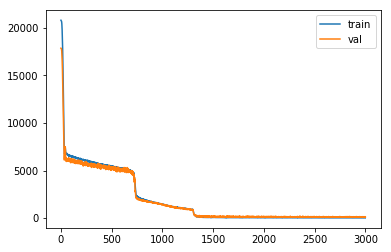

In [370]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

In [371]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

In [372]:
print(updated_neuron_channels.keys())

dict_keys([46, 41, 12, 49, 27, 43, 45, 28, 52, 53, 22, 21, 10, 34, 5, 35, 11, 50, 48, 47, 54, 18, 38, 9, 32, 13, 42, 1, 40, 31, 37, 29, 2, 39, 55, 24, 17, 0, 6, 8, 26, 7, 23, 36, 14, 3, 51, 25, 30, 15, 19, 33, 44, 20, 16, 4])


In [373]:
list_times_ch_test

[(682714, 35),
 (531099, 72),
 (854216, 46),
 (675443, 71),
 (680729, 13),
 (1148942, 1),
 (283588, 71),
 (793842, 58),
 (1145198, 60),
 (182821, 58),
 (452708, 95),
 (524795, 95),
 (280834, 57),
 (646161, 46),
 (22914, 84),
 (490329, 48),
 (693834, 53),
 (1104631, 60),
 (22469, 7),
 (337614, 7),
 (871876, 41),
 (669113, 26),
 (65210, 68),
 (1088085, 35),
 (632463, 28),
 (795280, 68),
 (168863, 53),
 (240653, 66),
 (788705, 17),
 (715990, 60),
 (162230, 28),
 (1050163, 13),
 (78027, 60),
 (342034, 13),
 (642618, 13),
 (538198, 71),
 (768084, 84),
 (388753, 84),
 (1131733, 58),
 (218029, 57),
 (689931, 17),
 (1013502, 33),
 (568671, 26),
 (622839, 53),
 (371074, 46),
 (655087, 11),
 (63532, 68),
 (453000, 58),
 (732361, 37),
 (525330, 93),
 (1011038, 35),
 (179432, 66),
 (763320, 37),
 (29316, 33),
 (154772, 65),
 (123283, 57),
 (890343, 65),
 (1022439, 84),
 (724458, 26),
 (620218, 96),
 (1121343, 66),
 (1032488, 60),
 (205103, 35),
 (926089, 7),
 (854766, 11),
 (838789, 13),
 (1114360

In [392]:
cnn_loc = []
com_loc = []
true_loc = []

for i, val in enumerate(updated_neuron_channels[28]):
    for j, index in enumerate(list_times_ch_test):
        if val == index:
            com_loc.append(location[val])
            cnn_loc.append(out[j])
            true_loc.append(new_location[val])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
true_loc = np.array(true_loc)
#print(cnn_loc)
#print(com_loc)
print(true_loc[0, :])

print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))

[  2.06295723 159.07988044]
CNN:  [ -0.8676647 160.63086  ] [ 11.044512 167.13033 ]
COM:  [ 11.2   155.303] [2.15772753 5.55829302]


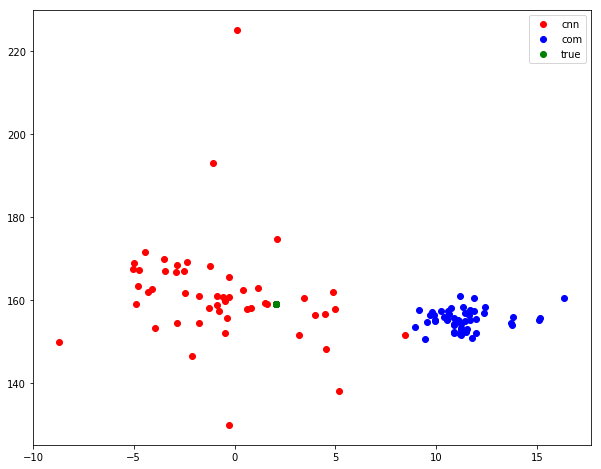

In [393]:
plt.figure(figsize=(10,8))
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', label='cnn')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', label='com')
plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', label='true')
plt.legend()
plt.show()

In [287]:
print(neuron_channels.keys())

dict_keys([46, 41, 12, 49, 27, 43, 45, 28, 52, 53, 22, 21, 10, 34, 5, 35, 11, 50, 48, 47, 54, 18, 38, 9, 32, 13, 42, 1, 40, 31, 37, 29, 2, 39, 55, 24, 17, 0, 6, 8, 26, 7, 23, 36, 14, 3, 51, 25, 30, 15, 19, 33, 44, 20, 16, 4])


In [318]:
# Filter only relevant frames
from collections import Counter

updated_neuron_channels = {}
for i in neuron_channels.keys():
    updated_neuron_channels[i] = []
    elec_list = np.array(neuron_channels[i])[:, 1]
    occ = Counter(elec_list)
    final_elec_list = []
    for d in occ.keys():
        if occ[d] > 80:
            final_elec_list.append(d)
    for j in final_elec_list:
        for k in neuron_channels[i]:
            if k[1] == j:
                updated_neuron_channels[i].append(k)

56


In [323]:
list_loc_ch = []
for i in updated_neuron_channels.values():
    list_loc_ch = list_loc_ch + i
print(len(list_loc_ch))

8977


In [346]:
new_list_times_ch

[(10030, 48),
 (10110, 65),
 (10226, 68),
 (10309, 17),
 (10366, 72),
 (10411, 95),
 (10412, 75),
 (10425, 60),
 (10435, 13),
 (10511, 58),
 (10588, 7),
 (10671, 98),
 (10708, 46),
 (10753, 93),
 (10903, 37),
 (10930, 39),
 (10967, 58),
 (11041, 26),
 (11144, 60),
 (11269, 95),
 (11272, 84),
 (11301, 74),
 (11336, 28),
 (11418, 48),
 (11422, 57),
 (11677, 93),
 (11693, 46),
 (11769, 26),
 (11784, 58),
 (11883, 58),
 (11977, 60),
 (12112, 7),
 (12118, 35),
 (12301, 39),
 (12362, 33),
 (12371, 58),
 (12398, 98),
 (12437, 26),
 (12447, 84),
 (12618, 71),
 (12651, 17),
 (12734, 93),
 (12812, 60),
 (12828, 48),
 (12839, 95),
 (12931, 33),
 (13041, 35),
 (13111, 68),
 (13126, 53),
 (13155, 26),
 (13224, 98),
 (13422, 13),
 (13431, 7),
 (13469, 84),
 (13511, 75),
 (13520, 33),
 (13556, 60),
 (13638, 95),
 (13765, 72),
 (13940, 98),
 (13987, 93),
 (14233, 57),
 (14314, 75),
 (14353, 60),
 (14356, 58),
 (14395, 26),
 (14468, 84),
 (14596, 95),
 (14608, 7),
 (14636, 13),
 (14669, 68),
 (14826, 1

In [395]:
len(list_loc_ch)

8977